In [40]:
# import relevant packages
import scipy.signal as ssig
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance

# Load Initial Data

In [41]:
# [pd.read_csv(video_path+'/'+file_name) for file_name in file_names][0][['DLC_resnet50_minimal-lip-readingNov19shuffle1_20000.7', 'DLC_resnet50_minimal-lip-readingNov19shuffle1_20000.10']]

In [42]:
# get path files
video_path = "/Users/quinnwaiwong/projects/lip_reading/2-4-21-data"
# file_names = !cd "/Volumes/BIG BOI/Research/words_only_avi"; find *.csv

# df_videos = [pd.read_csv(video_path+'/'+file_name, header=[1,2]) for file_name in file_names]

file_names = !cd "/Users/quinnwaiwong/projects/lip_reading/2-4-21-data"; find *.h5
df_videos = [pd.read_hdf(video_path+'/'+file_name).droplevel(level=0,axis=1) for file_name in file_names]

assert len(file_names) == len(df_videos), "could not upload all videos"

In [43]:
# list of words associated with each file name
words = [file.split(' ')[0] for file in file_names]
words

['Fill',
 'Film',
 'Find',
 'Fine',
 'Flea',
 'Fleet',
 'Leader',
 'Leather',
 'Less',
 'Liar',
 'Locker',
 'Ocean',
 'Open',
 'Oven',
 'Shadow',
 'Shallow']

Visualizing data below, you can see that columns have multiple indices, accesible as ("Title", "Subtitle")

In [44]:
df_videos[0].head()

bodyparts  leftCorner                        rightCorner              \
coords              x           y likelihood           x           y   
0          356.233124  269.419067   0.999996  410.383453  264.216278   
1          356.233124  269.419067   0.999996  410.383453  264.216278   
2          356.233124  269.419067   0.999996  410.383453  264.216278   
3          356.233124  269.419067   0.999996  410.383453  264.216278   
4          356.233124  269.419067   0.999996  410.383453  264.216278   

bodyparts                 topLip                          bottomLip  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
1           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
2           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
3           0.999991  385.635437  253.604446   0.999995  385.857452  ...   
4           0.999991  385.635437  253.604446   0.999995  385.857452  ...   

bodyparts bottomTeeth      tongue                           topLipLo  \
coords     likelihood           x           y likelihood           x   
0            0.756491  383.875916  267.207977   0.350048  386.023895   
1            0.756491  383.875916  267.207977   0.350048  386.023895   
2            0.756491  383.875916  267.207977   0.350048  386.023895   
3            0.756491  383.875916  267.207977   0.350048  386.023895   
4            0.756491  383.875916  267.207977   0.350048  386.023895   

bodyparts                        bottomLipHi                         
coords              y likelihood           x           y likelihood  
0          259.620392   0.999996   384.84079  271.208923   0.999993  
1          259.620392   0.999996   384.84079  271.208923   0.999993  
2          259.620392   0.999996   384.84079  271.208923   0.999993  
3          259.620392   0.999996   384.84079  271.208923   0.999993  
4          259.620392   0.999996   384.84079  271.208923   0.999993  

[5 rows x 27 columns]

In [45]:
df_videos[0].columns

MultiIndex([( 'leftCorner',          'x'),
            ( 'leftCorner',          'y'),
            ( 'leftCorner', 'likelihood'),
            ('rightCorner',          'x'),
            ('rightCorner',          'y'),
            ('rightCorner', 'likelihood'),
            (     'topLip',          'x'),
            (     'topLip',          'y'),
            (     'topLip', 'likelihood'),
            (  'bottomLip',          'x'),
            (  'bottomLip',          'y'),
            (  'bottomLip', 'likelihood'),
            (   'topTeeth',          'x'),
            (   'topTeeth',          'y'),
            (   'topTeeth', 'likelihood'),
            ('bottomTeeth',          'x'),
            ('bottomTeeth',          'y'),
            ('bottomTeeth', 'likelihood'),
            (     'tongue',          'x'),
            (     'tongue',          'y'),
            (     'tongue', 'likelihood'),
            (   'topLipLo',          'x'),
            (   'topLipLo',          'y'),
           

In [46]:
df_videos[0][[('bottomLip','y'),('topLip','y')]]

bodyparts,bottomLip,topLip
coords,y,y
0,278.869781,253.604446
1,278.869781,253.604446
2,278.869781,253.604446
3,278.869781,253.604446
4,278.869781,253.604446
...,...,...
61,278.476227,258.666260
62,278.316010,258.763458
63,278.164276,258.858582


In [47]:
# calculates area for a polygon given points 
def PolyArea(x,y):
    """
    Calculates the area of a 2D polygon enclosed by coordinates specified by (x[i], y[i]) for i from 0 to len(x)
    Assumes that the coordinates are ordered in a clockwise or counterclockwise fashion
    Source: https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
    """
    
    assert len(x) == len(y), "x and y are not the same length"
    
    # TODO: find way to make sure coordinates don't cross each other?
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [48]:
# calculating area test
# validated area works using https://www.mathopenref.com/coordpolygonareacalc.html 
# Notice that 0 of the y coordinate starts at the top border of the video so topLip is a low value than bottomLip
test = df_videos[0]

pts = ["bottomLipHi", "leftCorner", "topLipLo", "rightCorner"]
x_cols = [(pt,'x') for pt in pts]
y_cols = [(pt,'y') for pt in pts]


x_coord = np.array([test.iloc[0][col] for col in x_cols])
y_coord = np.array([test.iloc[0][col] for col in y_cols])

print(pts)
print(f'x: {x_coord}')
print(f'y: {y_coord}')
print(f'Area: {PolyArea(x_coord,y_coord)}')

['bottomLipHi', 'leftCorner', 'topLipLo', 'rightCorner']
x: [384.84078979 356.23312378 386.02389526 410.38345337]
y: [271.20892334 269.41906738 259.62039185 264.21627808]
Area: 310.6836756942794


In [49]:
x_coords = np.array([test.iloc[i][x_cols] for i in range(len(test))])
y_coords = np.array([test.iloc[i][y_cols] for i in range(len(test))])

# assert thing.shape == (len(test),len(x_cols)), "wrong shape"

areas = [PolyArea(x_coords[i],y_coords[i]) for i in range(len(x_coords))]
areas[0:10]

[310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 310.6836756942794,
 308.7984172133729,
 302.36905922042206]

In [50]:
# to show that the first noticeable change is from the 9th to the 10th frame (see topLip x and bottomLip y)
test.iloc[0:10][x_cols + y_cols]

bodyparts,bottomLipHi,leftCorner,topLipLo,rightCorner,bottomLipHi,leftCorner,topLipLo,rightCorner
coords,x,x,x,x,y,y,y,y
0,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
1,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
2,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
3,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
4,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
5,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
6,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
7,384.840790,356.233124,386.023895,410.383453,271.208923,269.419067,259.620392,264.216278
8,384.743988,356.439056,385.997437,410.236481,271.394989,269.516083,259.795654,264.396210


In [51]:
# to show that from above, the change in distances are
print(x_coords[8]-x_coords[7])
print(y_coords[8]-y_coords[7])

[-0.09680176  0.20593262 -0.02645874 -0.14697266]
[0.18606567 0.09701538 0.17526245 0.17993164]


#  Create Features from Data

In [52]:
def appendPolyArea(df):
    pts = ["bottomLipHi", "leftCorner", "topLipLo", "rightCorner"]
    x_cols = [(pt,'x') for pt in pts]
    y_cols = [(pt,'y') for pt in pts]
    
    x_coords = np.array([df.iloc[i][x_cols] for i in range(len(df))])
    y_coords = np.array([df.iloc[i][y_cols] for i in range(len(df))])

    areas = [PolyArea(x_coords[i],y_coords[i]) for i in range(len(x_coords))]
    return areas

In [53]:
def appendIndicatorVariables(df, colName):
    col = df[(colName, "likelihood")]
    stats = df[(colName, "likelihood")].describe()
    threshold = stats['50%']
    return (col >= threshold).astype(int)

In [54]:
def appendMouthShape(df):
    # should word comparisons
    x_diff = abs(df[("rightCorner", "x")]-df[("leftCorner", "x")])
    y_diff = abs(df[("bottomLip", "y")]-df[("topLip", "y")]) # (bottom-top) because y axis indexes the top as 0
    return y_diff/x_diff

In [55]:
df_new_features = [0 for i in range(len(df_videos))]

for i,df in enumerate(df_videos):
    df_new_features[i] = pd.DataFrame()
    df_new = df_new_features[i]
    
    df_new["MouthArea"] = appendPolyArea(df)
    df_new["HasTopTeeth"] = appendIndicatorVariables(df, "topTeeth")
    df_new["HasBottomTeeth"] = appendIndicatorVariables(df, "bottomTeeth")
    df_new["HasTongue"] = appendIndicatorVariables(df, "tongue")
    df_new["MouthShape"] = appendMouthShape(df)

In [56]:
# sample df
df_new_features[0]

,MouthArea,HasTopTeeth,HasBottomTeeth,HasTongue,MouthShape
0,310.683676,1,1,1,0.466578
1,310.683676,1,1,1,0.466578
2,310.683676,1,1,1,0.466578
3,310.683676,1,1,1,0.466578
4,310.683676,1,1,1,0.466578
...,...,...,...,...,...
61,183.901443,0,0,0,0.348771
62,168.859432,0,0,0,0.343788
63,163.438804,0,0,0,0.338903
64,157.324066,0,0,0,0.337136


In [57]:
df_new_features[0].describe()

,MouthArea,HasTopTeeth,HasBottomTeeth,HasTongue,MouthShape
count,66.000000,66.000000,66.000000,66.000000,66.000000
mean,259.504921,0.500000,0.500000,0.500000,0.433999
std,69.897169,0.503831,0.503831,0.503831,0.080955
min,148.346936,0.000000,0.000000,0.000000,0.330126
25%,204.412739,0.000000,0.000000,0.000000,0.361899
50%,239.454816,0.500000,0.500000,0.500000,0.422040
75%,310.212361,1.000000,1.000000,1.000000,0.472692
max,461.534797,1.000000,1.000000,1.000000,0.638688


# Create Correlation Matrices

In [111]:
# normalize (z-score) all columns of dataframes
df_normed = [pd.DataFrame(StandardScaler().fit_transform(df.to_numpy()), index=df.index, columns=df.columns)
             for df in df_new_features]

# example of normalized df 
df_normed[0]

,MouthArea,HasTopTeeth,HasBottomTeeth,HasTongue,MouthShape
0,0.737811,1.0,1.0,1.0,0.405513
1,0.737811,1.0,1.0,1.0,0.405513
2,0.737811,1.0,1.0,1.0,0.405513
3,0.737811,1.0,1.0,1.0,0.405513
4,0.737811,1.0,1.0,1.0,0.405513
...,...,...,...,...,...
61,-1.089927,-1.0,-1.0,-1.0,-1.060854
62,-1.306778,-1.0,-1.0,-1.0,-1.122868
63,-1.384924,-1.0,-1.0,-1.0,-1.183680
64,-1.473076,-1.0,-1.0,-1.0,-1.205672


In [129]:
def plotCorMatrix(ft_vecs_1, ft_vecs_2, labels, title="Correlation Matrix", flatten=True):
    '''
    Takes two arrays of features, optionally flattens them,
    and creates a matrix of the pairwise correlations
    '''
    if flatten:
        ft_vecs_1 = [np.array(df).flatten() for df in ft_vecs_1]
        ft_vecs_2 = [np.array(df).flatten() for df in ft_vecs_2]
    
    cor_matrix = np.zeros((len(ft_vecs_1),len(ft_vecs_2)))
    for i, vec1 in enumerate(ft_vecs_1):
        for j in range(i,len(ft_vecs_2)):
            vec2 = ft_vecs_2[j]
            cor_matrix[i,j] = 1-distance.cosine(vec1,vec2)
            cor_matrix[j,i] = cor_matrix[i,j]
    
    print(cor_matrix[:5,:5])
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    cor_plot = sns.heatmap(cor_matrix, xticklabels=labels, yticklabels=labels)
    cor_plot.set(title=title)

[[1.         0.96224393 0.95751739 0.97394095 0.9786135 ]
 [0.96224393 1.         0.89554963 0.91540527 0.93815307]
 [0.95751739 0.89554963 1.         0.99511457 0.97146654]
 [0.97394095 0.91540527 0.99511457 1.         0.98142842]
 [0.9786135  0.93815307 0.97146654 0.98142842 1.        ]]


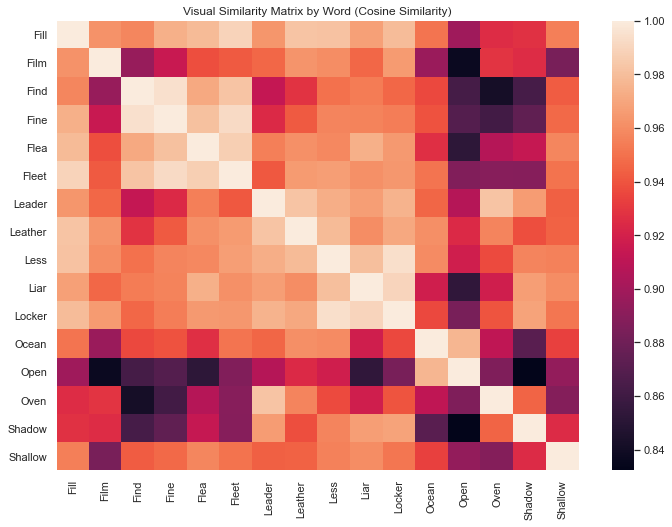

In [130]:
# correlation matrix for non-normalized values
plotCorMatrix(df_new_features,df_new_features, words, 'Visual Similarity Matrix by Word (Cosine Similarity)')

[[1.         0.57745202 0.38249101 0.70710013 0.63820332]
 [0.57745202 1.         0.29978074 0.45260951 0.45620778]
 [0.38249101 0.29978074 1.         0.59420268 0.45783465]
 [0.70710013 0.45260951 0.59420268 1.         0.5522249 ]
 [0.63820332 0.45620778 0.45783465 0.5522249  1.        ]]


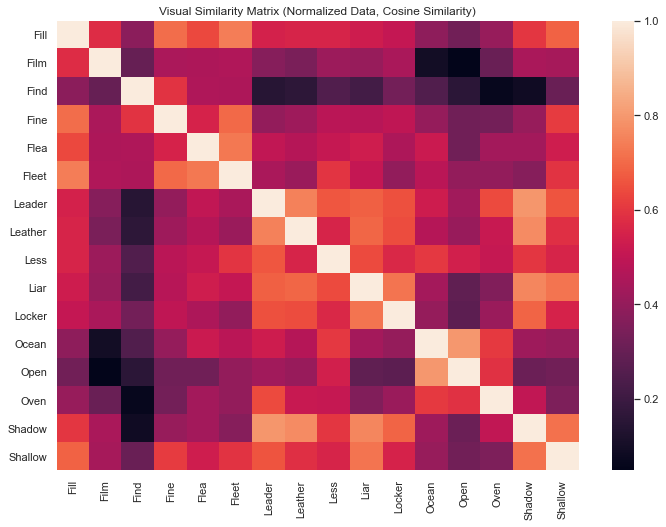

In [131]:
# correlation matrix for normalized values
plotCorMatrix(df_normed,df_normed, words, 'Visual Similarity Matrix (Normalized Data, Cosine Similarity)')

In [94]:
x = df_normed[0]["MouthArea"]
df_normed[0]

,MouthArea,HasTopTeeth,HasBottomTeeth,HasTongue,MouthShape
0,0.737811,-1.0,1.0,1.0,1.108072
1,-0.029368,-1.0,-1.0,-1.0,0.343430
2,-0.910507,-1.0,1.0,-1.0,0.405513
3,0.737811,1.0,1.0,-1.0,-1.026480
4,-0.982835,-1.0,1.0,1.0,-1.016635
...,...,...,...,...,...
61,-0.068249,1.0,1.0,-1.0,-0.656838
62,-0.843543,-1.0,-1.0,-1.0,-0.115080
63,0.737811,-1.0,1.0,-1.0,-1.010493
64,-1.602494,1.0,-1.0,-1.0,0.405513


# Comparison to Randomized DataFrame

In [70]:
# # TODO: Fix

# df_rand = [df.to_numpy() for df in df_normed]

# for df_idx, df in enumerate(df_rand):
#     for i,col in enumerate(df.T):
#         print(col, np.random.permutation(col))
#         df[:,i] = np.random.permutation(col)
    
#     assert (df.mean(axis=0) != df_normed[df_idx].mean().to_numpy()).sum() == 0, "you are shuffling values outside of the columne"
#     assert df[0,0] != df_normed[df_idx].iloc[0,0], f"no shuffle occurred, {df[0,0]}, {df_normed[df_idx].iloc[0,0]}" 

# df_rand[0][:5,:5], df_normed[0].to_numpy()[:5,:5]

[ 0.37802749 -0.84354265 -1.60249385 -1.09803737 -0.77582301  0.61794497
 -0.12344449 -0.64656718 -1.01202335 -0.98283482 -1.47307629 -0.76726477
  0.16438298 -0.31537587 -0.36713196 -1.03290252  1.95066228 -0.3163097
  2.912536    0.7378115   0.85550179 -0.66344502 -0.02936795 -1.04351236
  0.62513756  1.4521268  -0.76190331  0.78718611 -0.33527812 -1.30677826
 -1.08992717 -0.44482083 -1.384924   -0.06824888  0.7378115  -0.97808381
  1.06632111 -0.37341379 -0.91050748 -0.56635934 -0.26272331 -0.80036418
  0.7378115  -0.408772    0.17583094 -0.04773681 -0.34567862  2.36477277
  0.07171234  0.52658017  0.7378115   0.54758135 -0.37980627 -0.59992883
  0.71063293  0.7378115  -0.91143996  0.7378115   0.64072078 -0.93390898
  0.7378115   2.15880343  2.61737861 -0.84777767  0.32520238  0.7378115 ] [-0.97808381  1.95066228 -0.98283482 -0.56635934  2.61737861 -1.47307629
  0.78718611 -0.84354265 -0.33527812  0.32520238  0.7378115  -0.44482083
 -0.37980627  0.64072078  0.16438298  0.07171234 -0

AssertionError: no shuffle occurred, 0.737811496271055, 0.737811496271055

In [ ]:
# plotCorMatrix(df_normed,df_rand, 'Visual Similarity Matrix by Word (Cosine Similarity) (x-axis: randomized)')

# Use 4x4 word comparisons

In [113]:
small_words = ['Fill', 'Find', 'Ocean', 'Open']
idxs = [words.index(i) for i in small_words]

small_dfs = [df_new_features[i] for i in idxs]
small_normed_dfs = [df_normed[i] for i in idxs]

small_normed_dfs[0]

,MouthArea,HasTopTeeth,HasBottomTeeth,HasTongue,MouthShape
0,0.737811,1.0,1.0,1.0,0.405513
1,0.737811,1.0,1.0,1.0,0.405513
2,0.737811,1.0,1.0,1.0,0.405513
3,0.737811,1.0,1.0,1.0,0.405513
4,0.737811,1.0,1.0,1.0,0.405513
...,...,...,...,...,...
61,-1.089927,-1.0,-1.0,-1.0,-1.060854
62,-1.306778,-1.0,-1.0,-1.0,-1.122868
63,-1.384924,-1.0,-1.0,-1.0,-1.183680
64,-1.473076,-1.0,-1.0,-1.0,-1.205672


In [ ]:
# plot all vectors 
df = dfs[]
plt.figure()
plt.scatter(range(len(df)), df[feature])
plt.title(f"{feature} Feature for '{words[i]}'")
plt.xlabel("Time")
plt.ylabel("Values")
plt.ylim(ylo, yhi)

plt.show()

[[1.         0.95751739 0.95136116 0.89870178]
 [0.95751739 1.         0.9359461  0.86243452]
 [0.95136116 0.9359461  1.         0.97673654]
 [0.89870178 0.86243452 0.97673654 1.        ]]


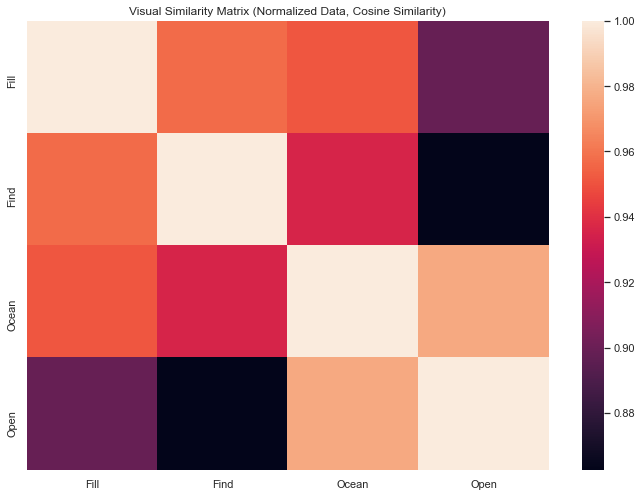

In [132]:
# small correlation matrix 
plotCorMatrix(small_dfs, small_dfs, small_words, 'Visual Similarity Matrix (Normalized Data, Cosine Similarity)')

[[1.         0.38249101 0.38749517 0.32414144]
 [0.38249101 1.         0.25055218 0.15670391]
 [0.38749517 0.25055218 1.         0.79818755]
 [0.32414144 0.15670391 0.79818755 1.        ]]


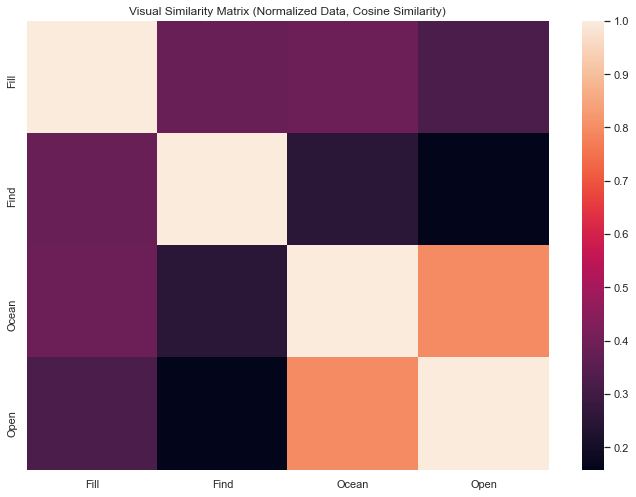

In [133]:
# small correlation matrix for normalized values
plotCorMatrix(small_normed_dfs,small_normed_dfs, small_words, 'Visual Similarity Matrix (Normalized Data, Cosine Similarity)')

# Plots of Each Feature by Word

In [71]:
def plotFeature(features, dfs, words, ylo, yhi, save_path=None):
    """
    Creates feature plots for all

    Parameters
    ----------
    columns : iter
        names of features to process
    dfs : iter[DataFrames]
        list of DataFrames to process
    words : iter
        list of words associated with each DataFrame
    ylo : int
        lower bound for y axis
    yhi : int
        upper bound for y axis
    Returns
    -------
    None
    """
    for feature in features:
        for i in range(len(dfs)):
            df = dfs[i]
            plt.figure()
            plt.scatter(range(len(df)), df[feature])
            plt.title(f"{feature} Feature for '{words[i]}'")
            plt.xlabel("Time")
            plt.ylabel("Values")
            plt.ylim(ylo, yhi)
            
            if save_path is not None: plt.savefig(f"{save_path}{words[i]}_{feature}.png", bbox_inches='tight')
    
    
    plt.show()


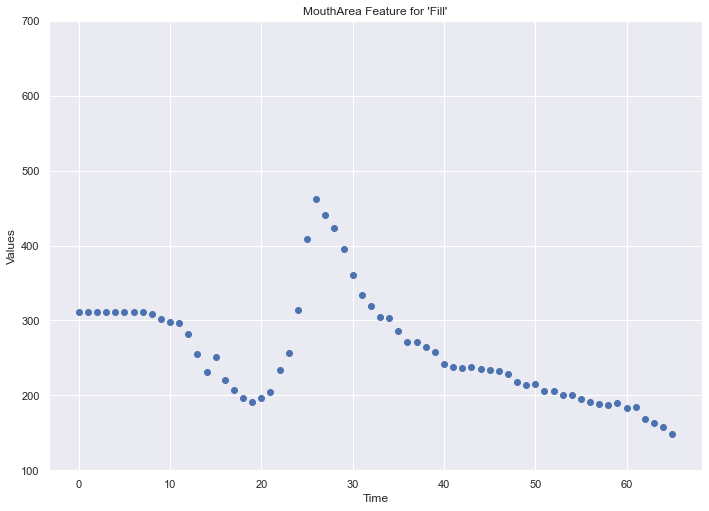

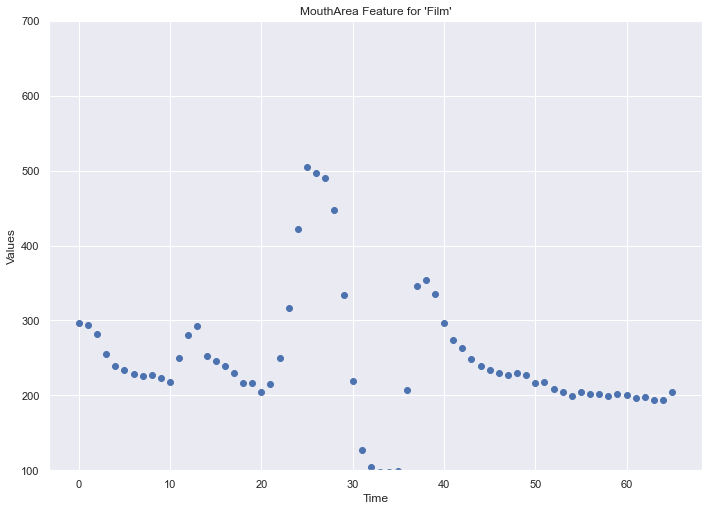

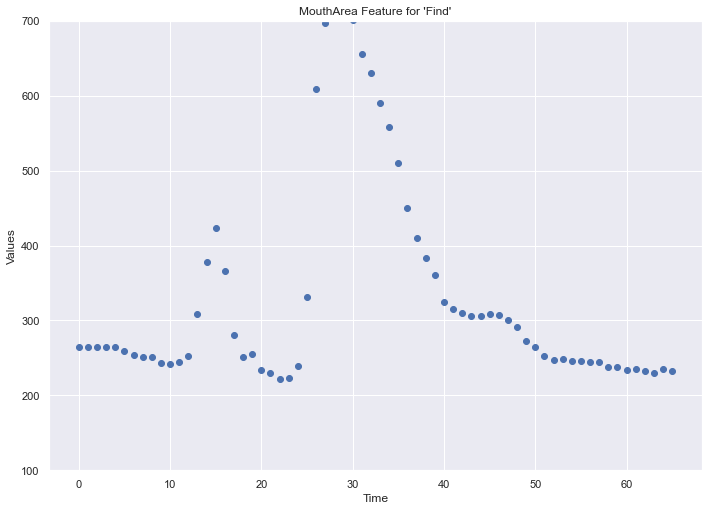

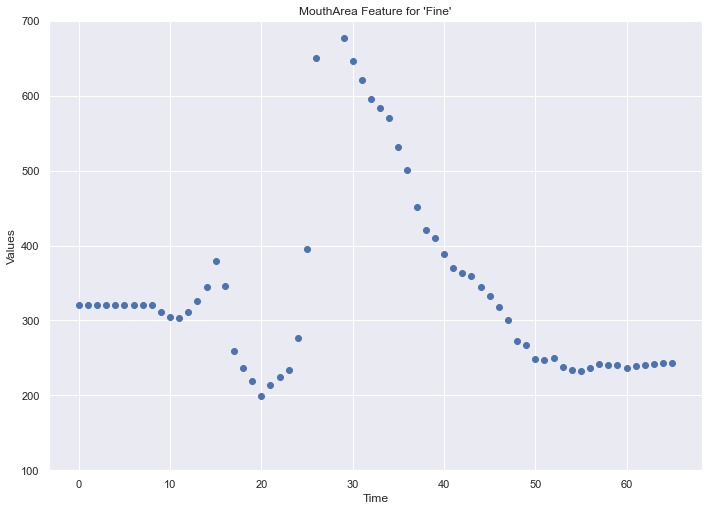

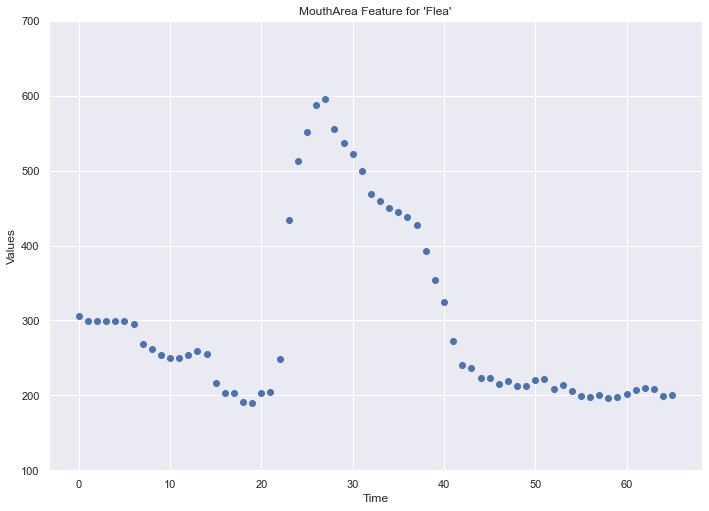

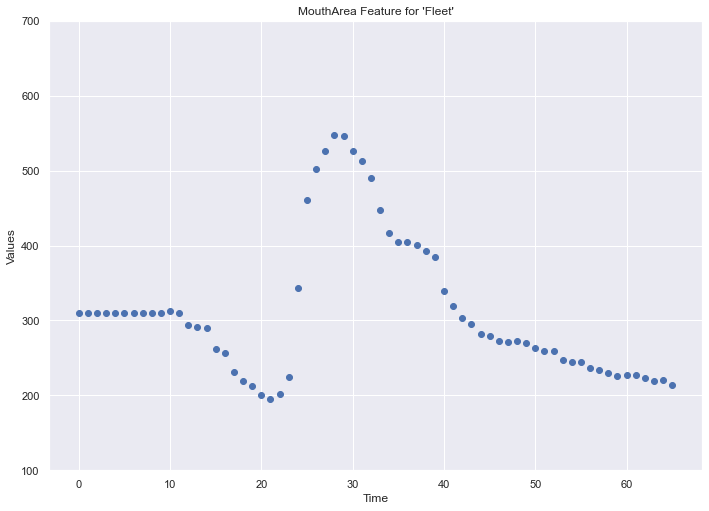

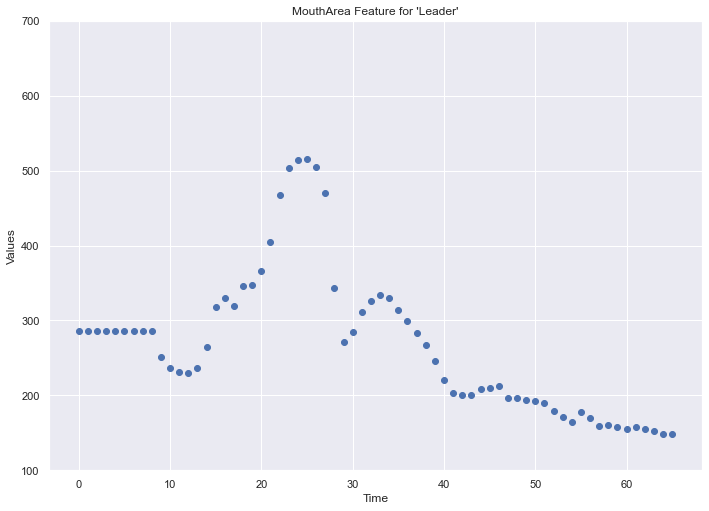

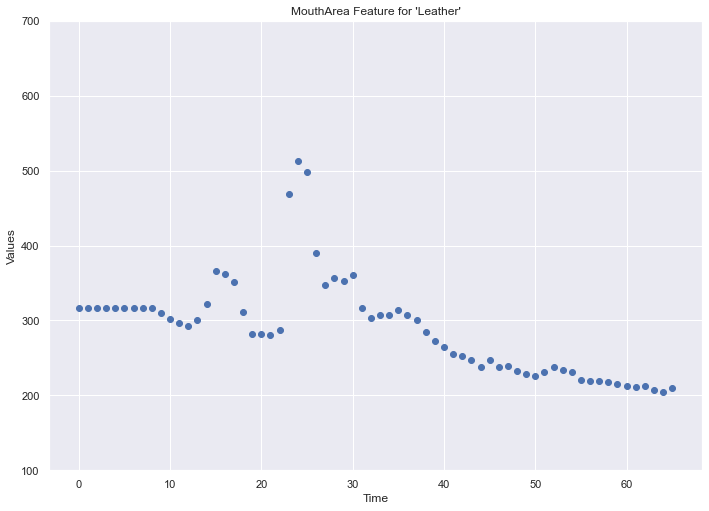

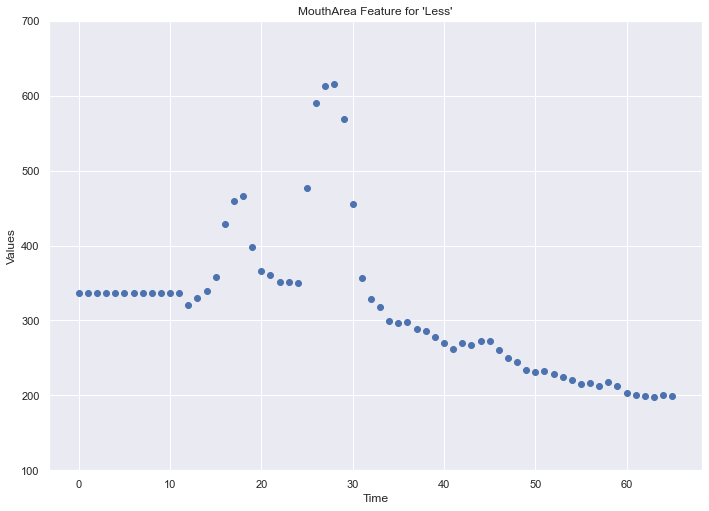

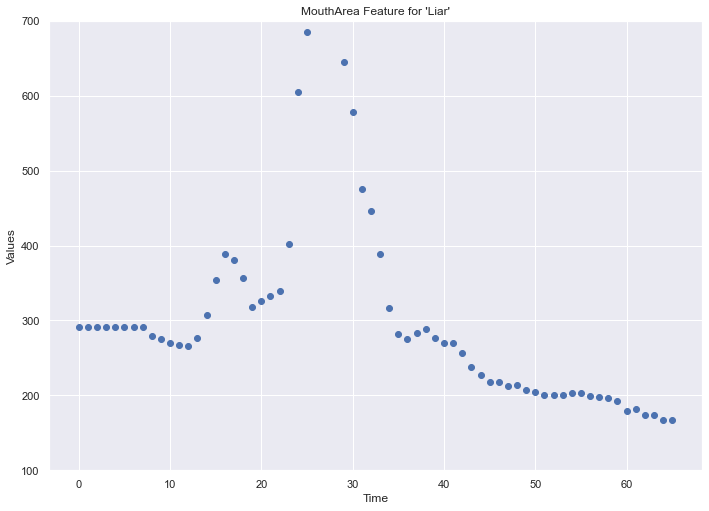

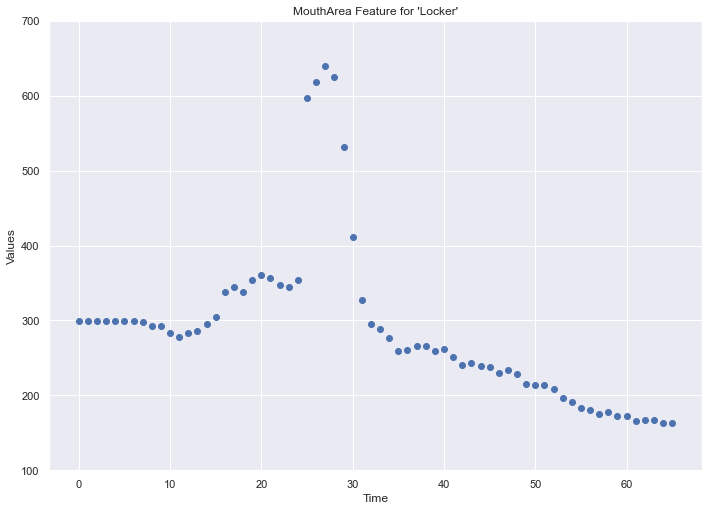

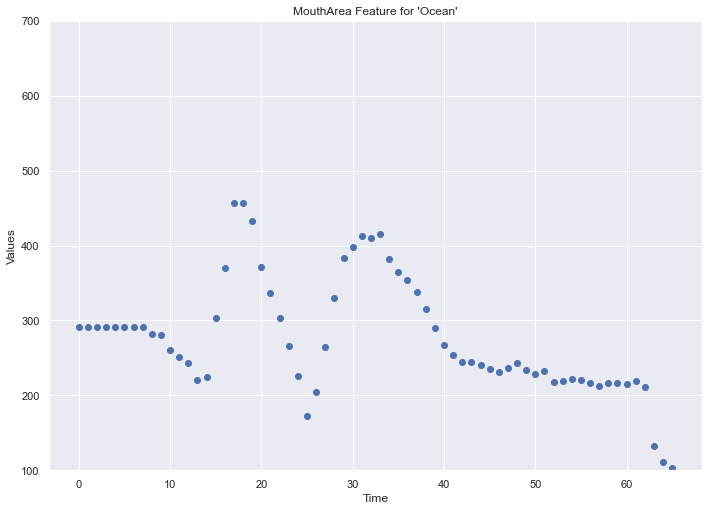

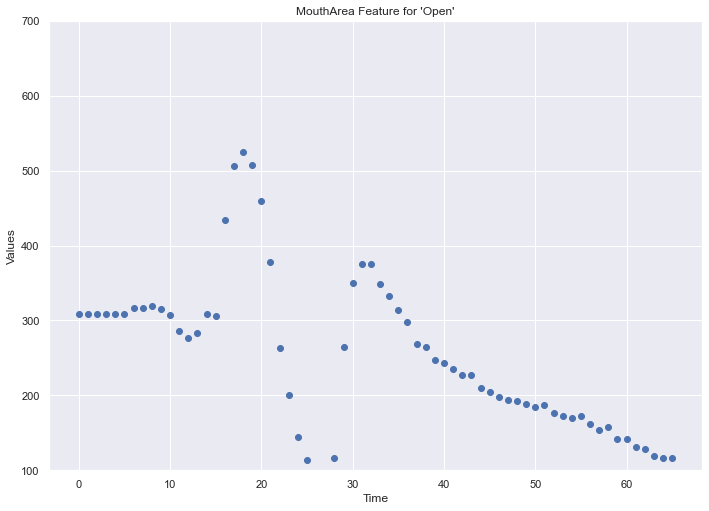

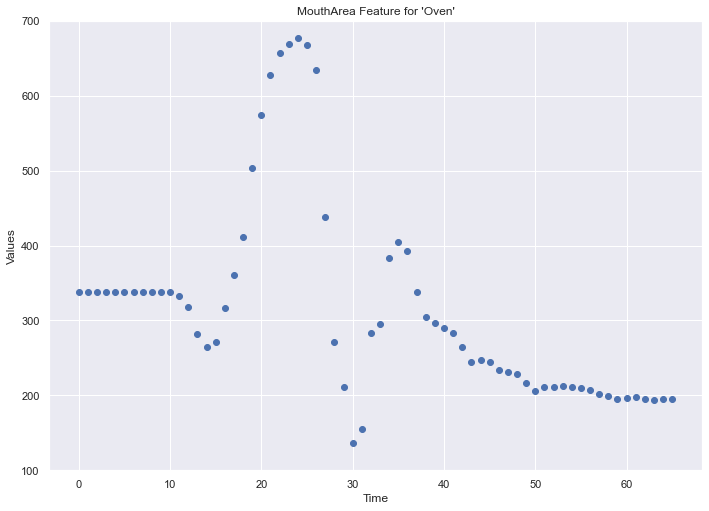

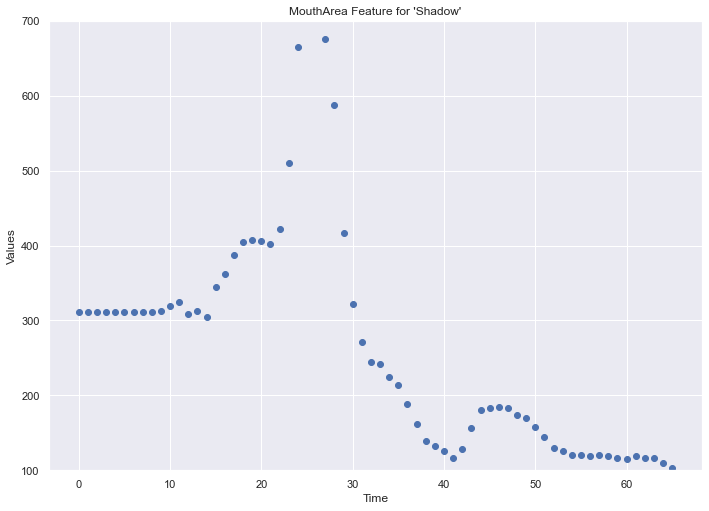

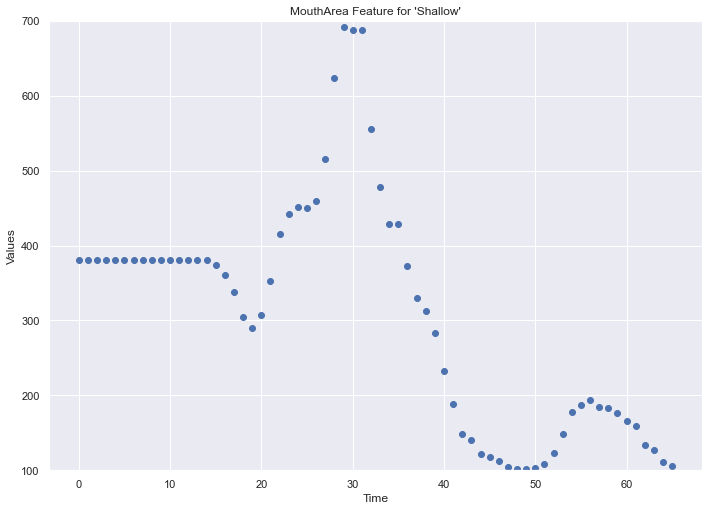

In [72]:
plotFeature(["MouthArea"], df_new_features, words, 100,700, save_path = "./figures/")

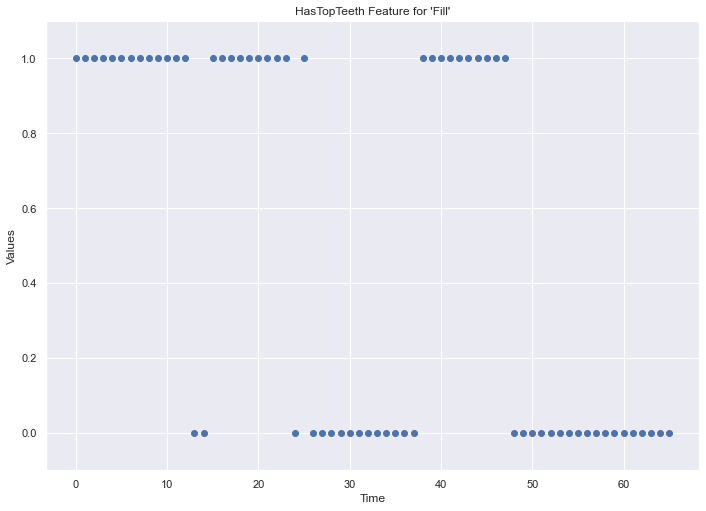

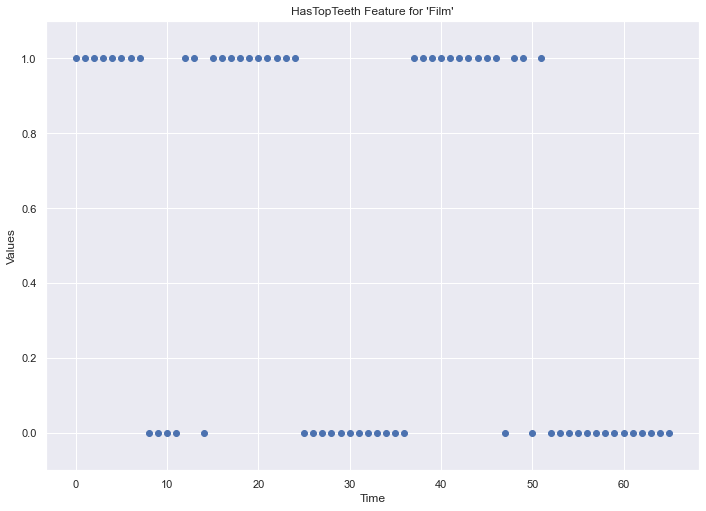

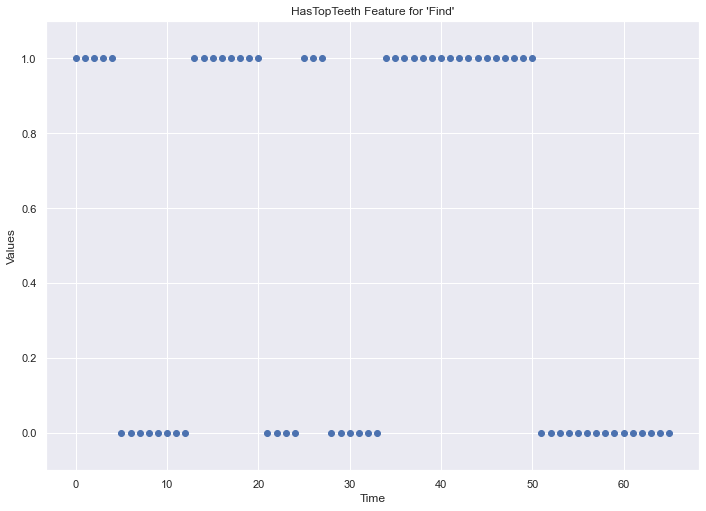

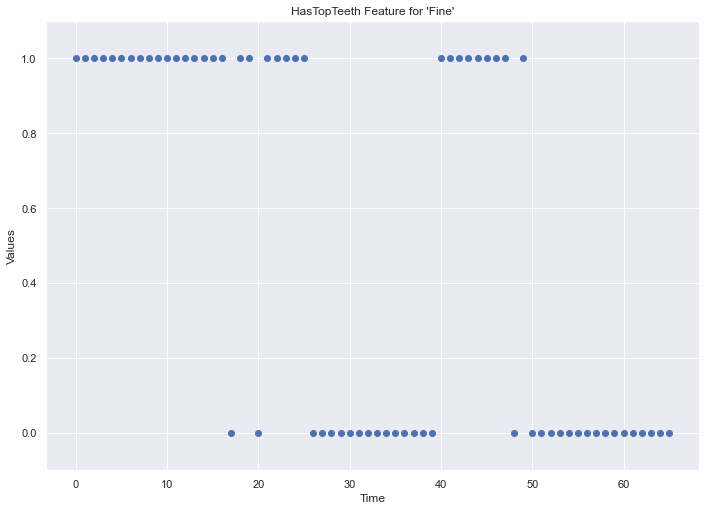

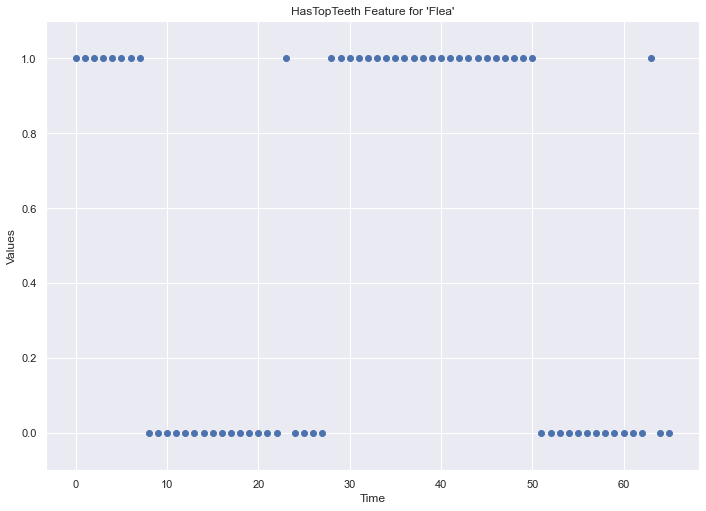

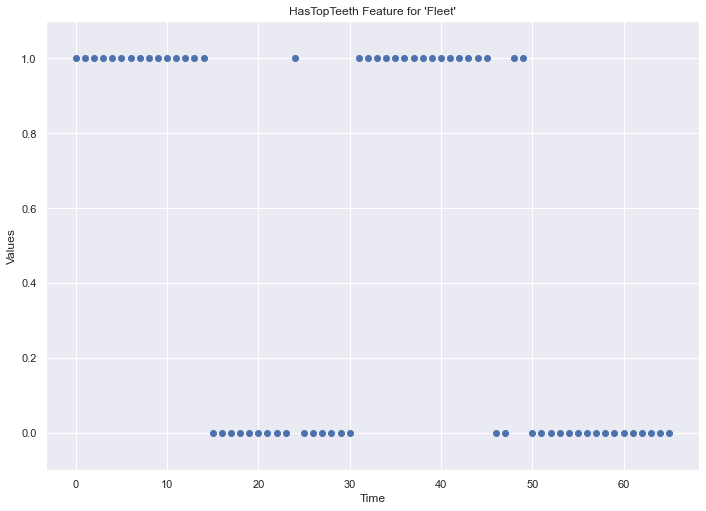

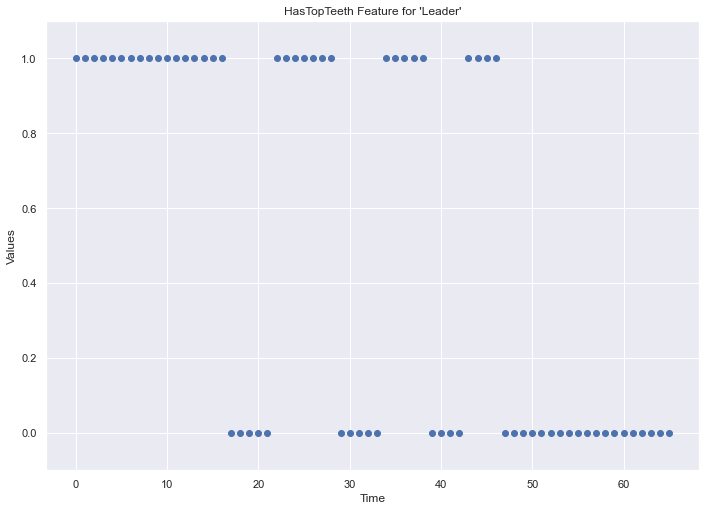

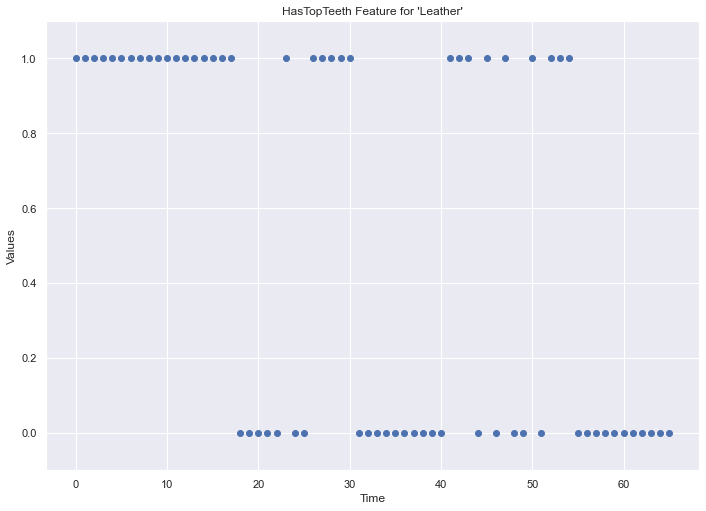

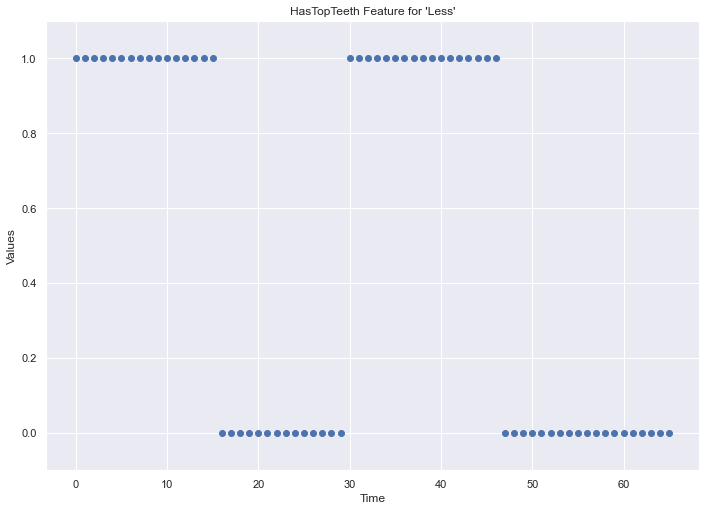

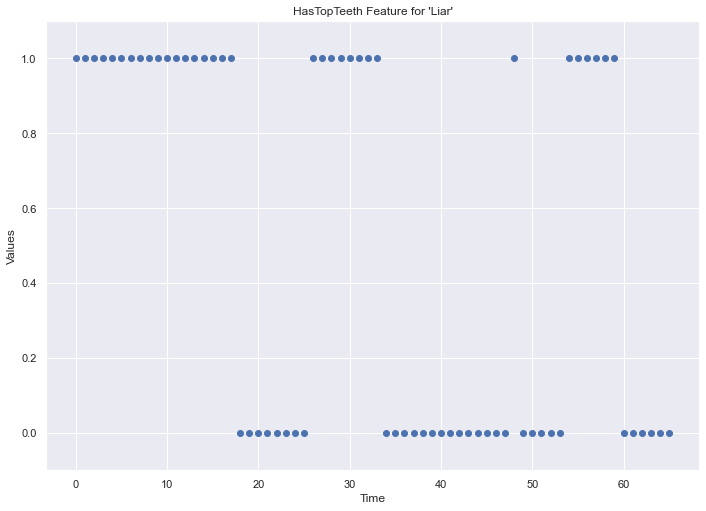

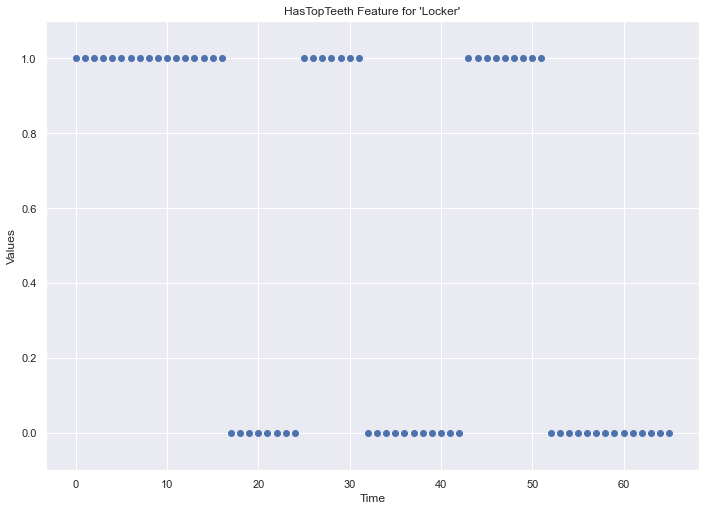

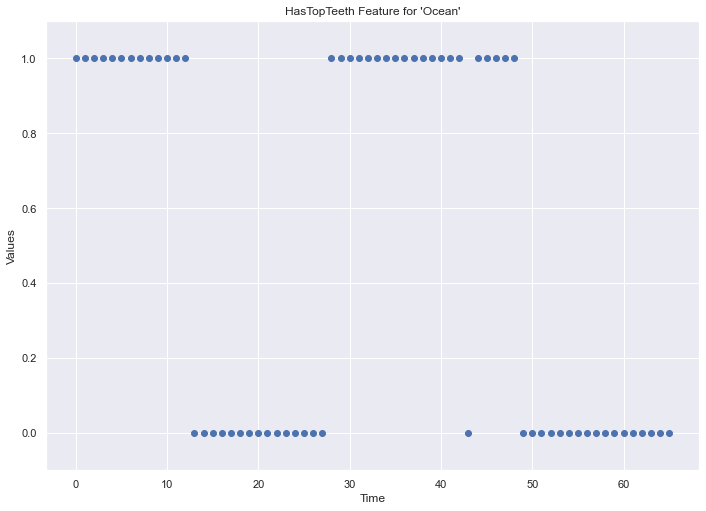

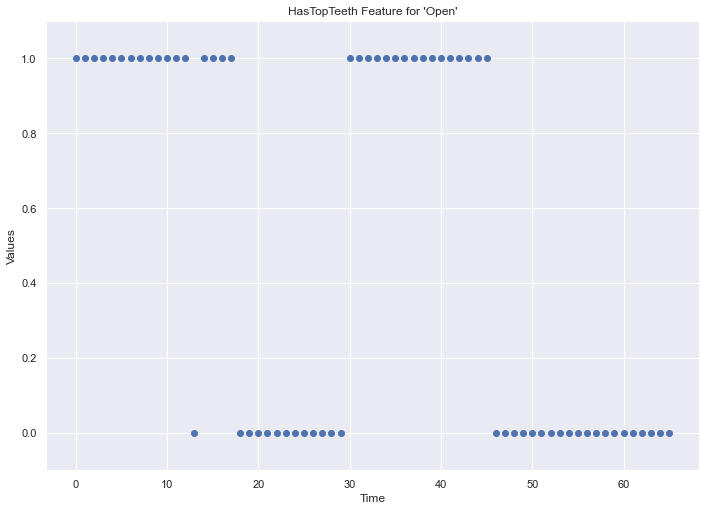

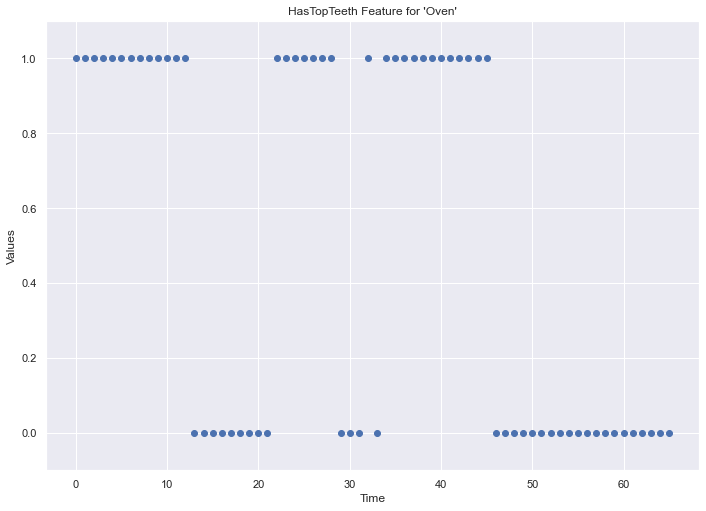

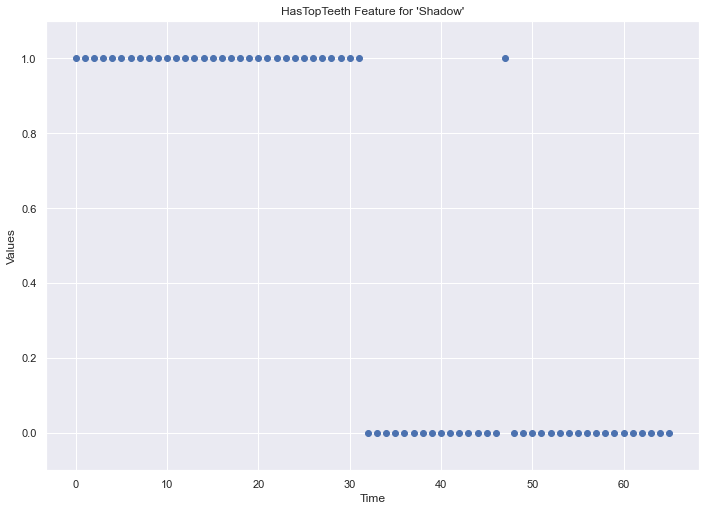

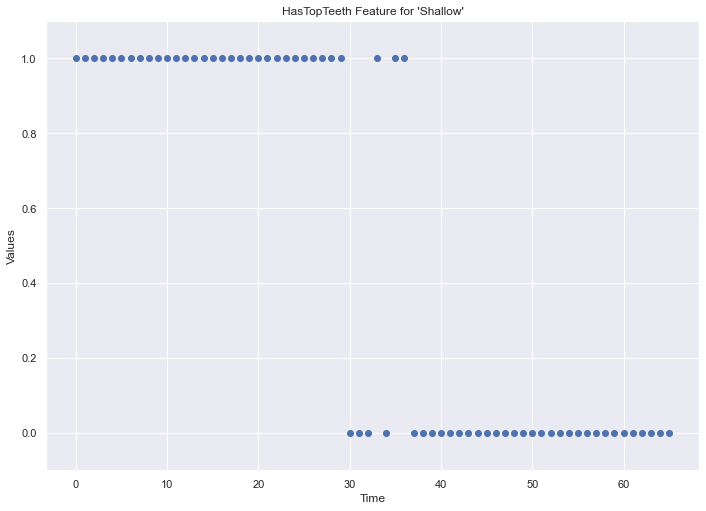

In [73]:
plotFeature(["HasTopTeeth"],df_new_features, words, -0.1,1.1)

/Users/quinnwaiwong/opt/anaconda3/envs/cse217a/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


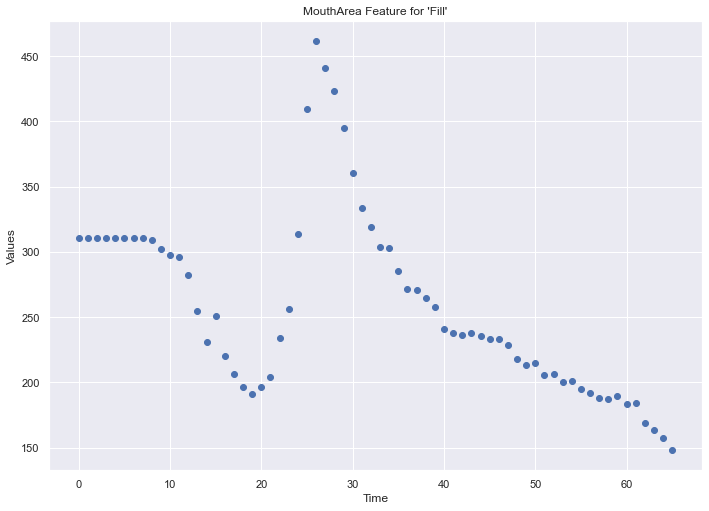

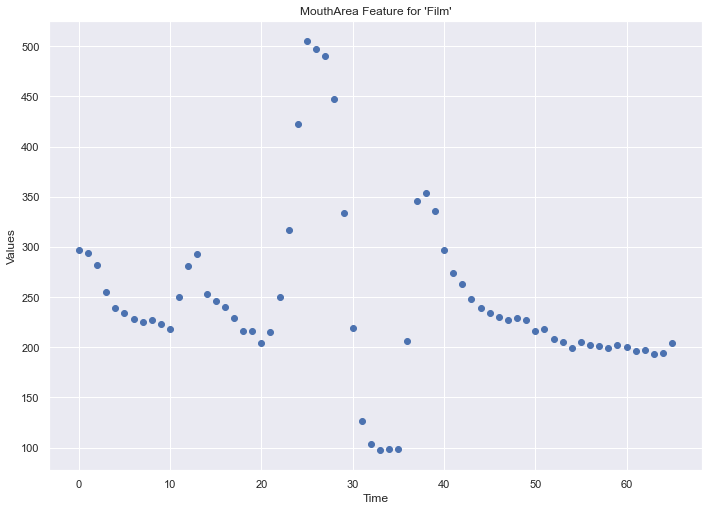

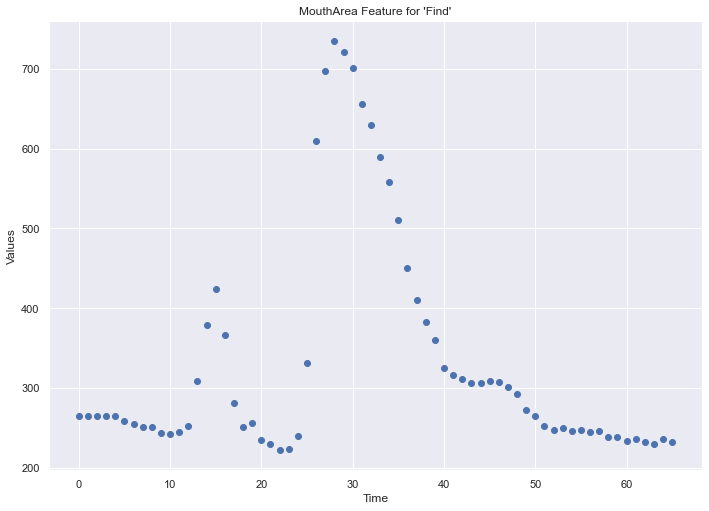

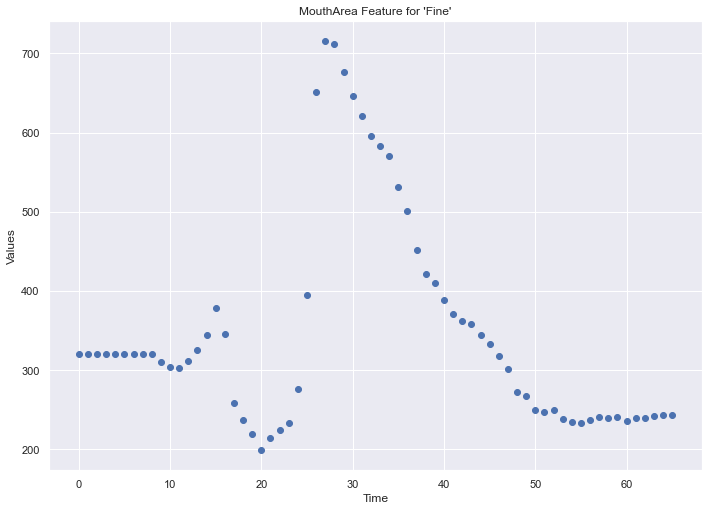

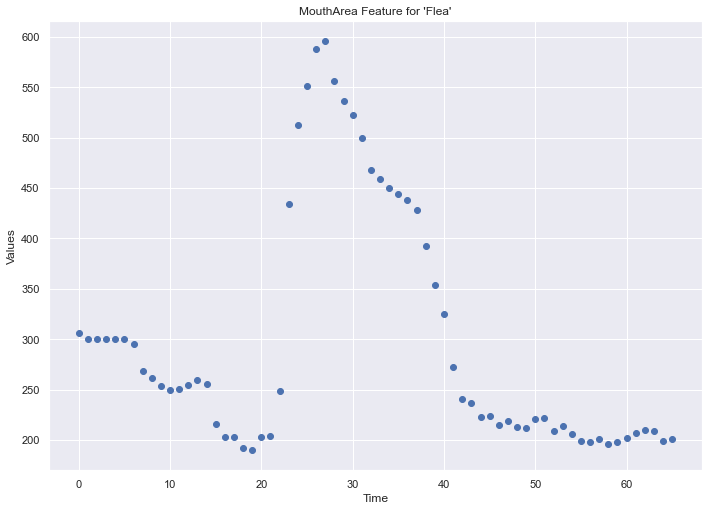

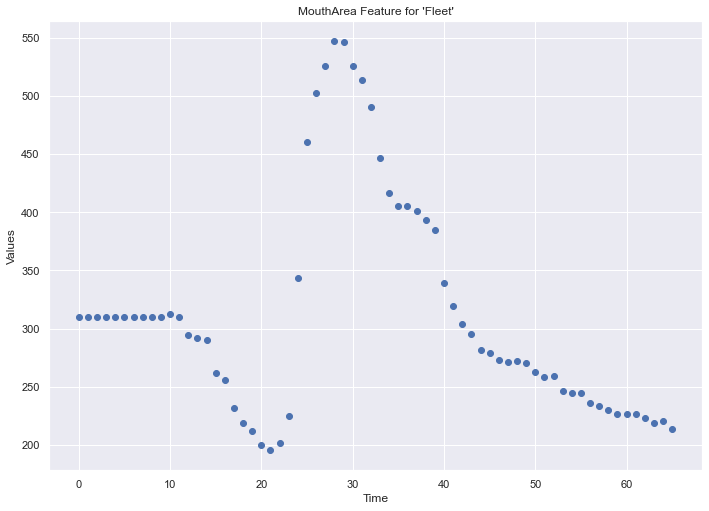

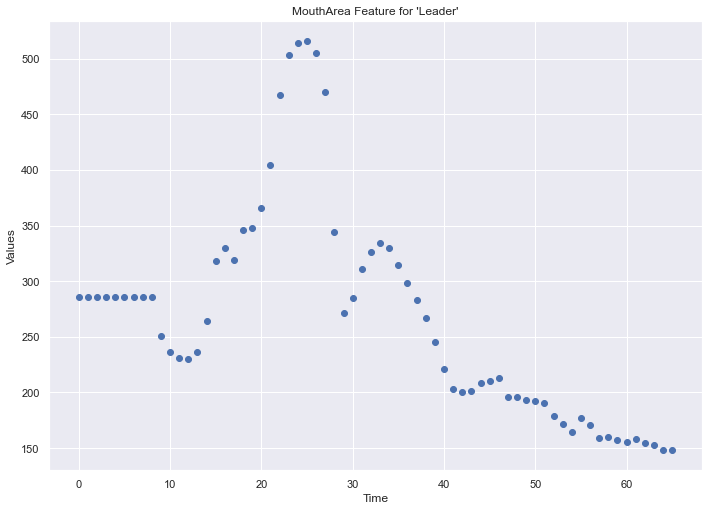

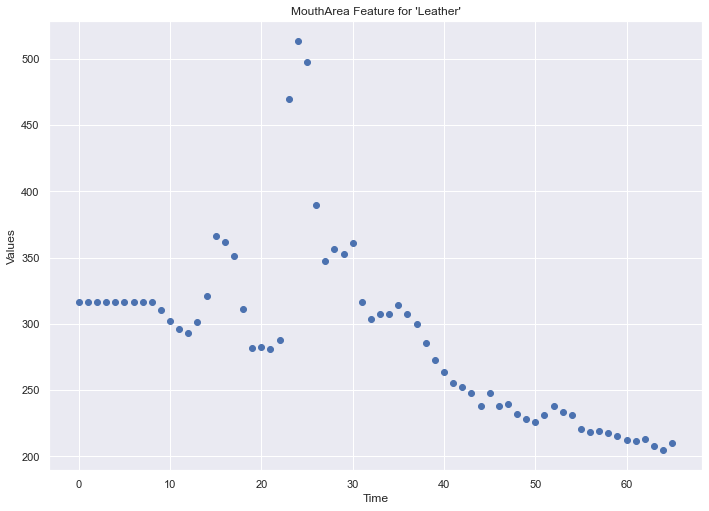

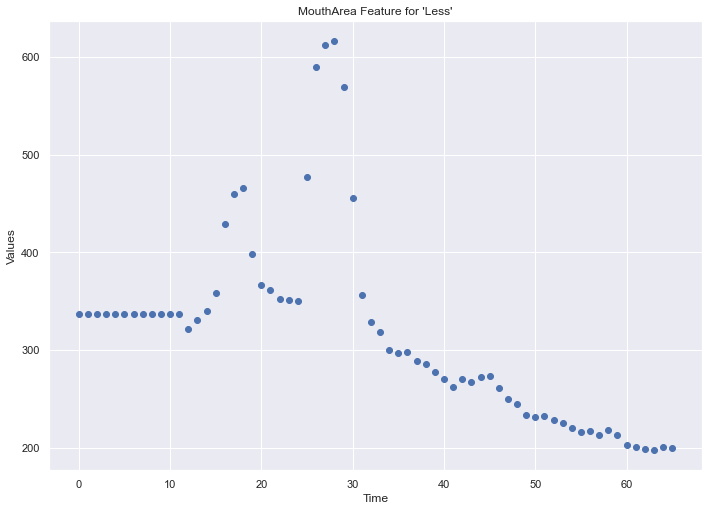

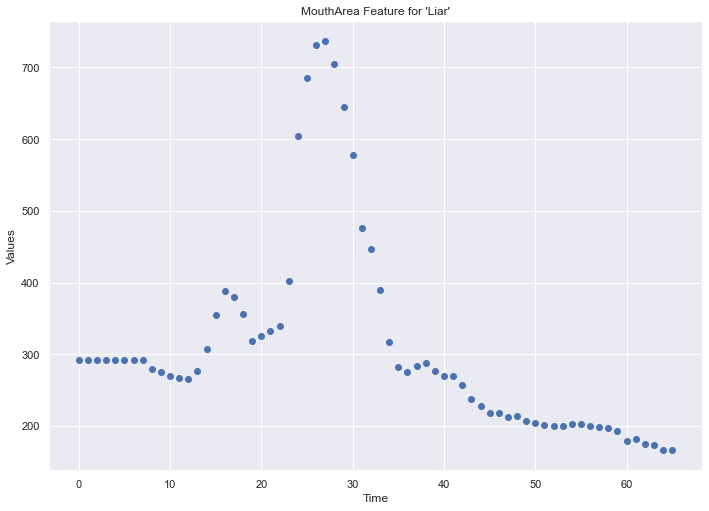

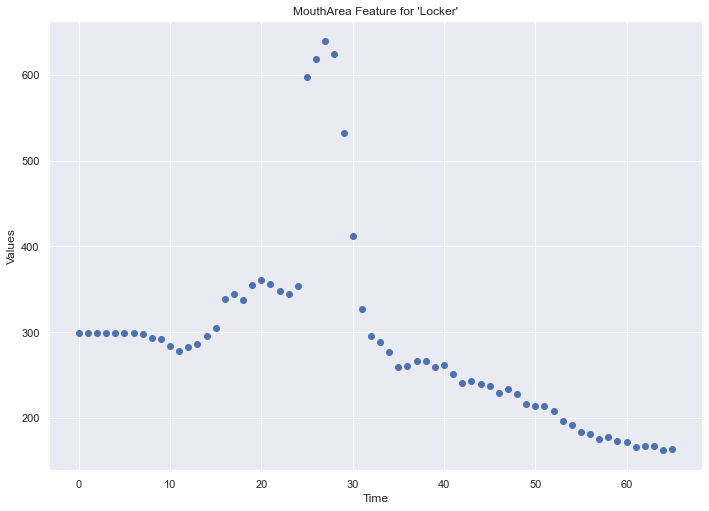

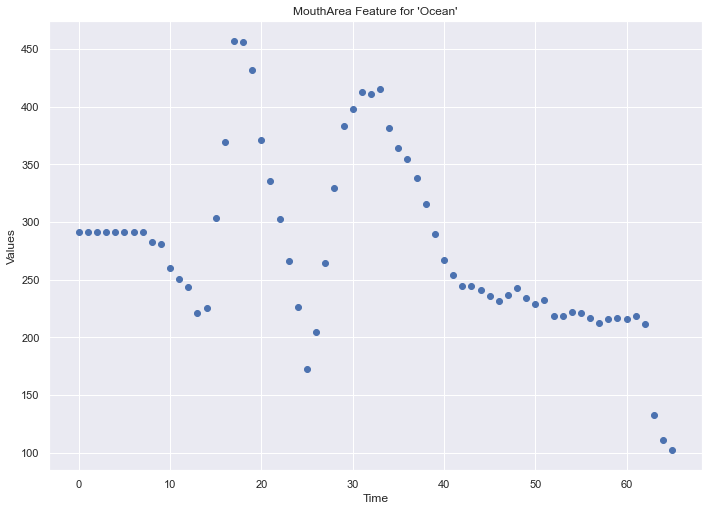

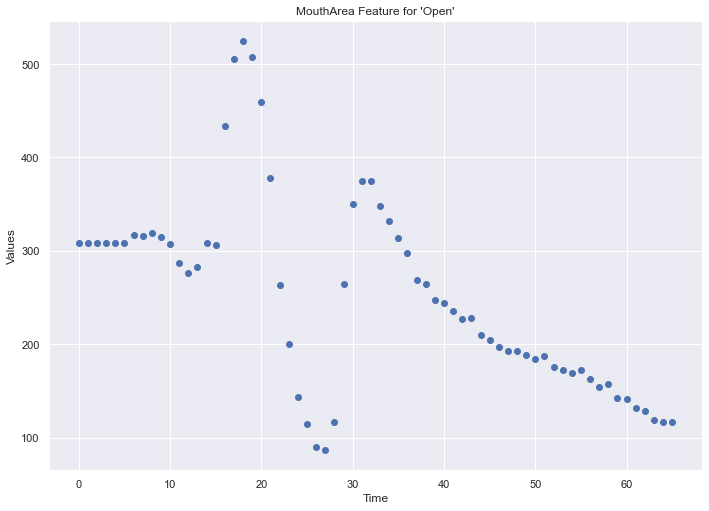

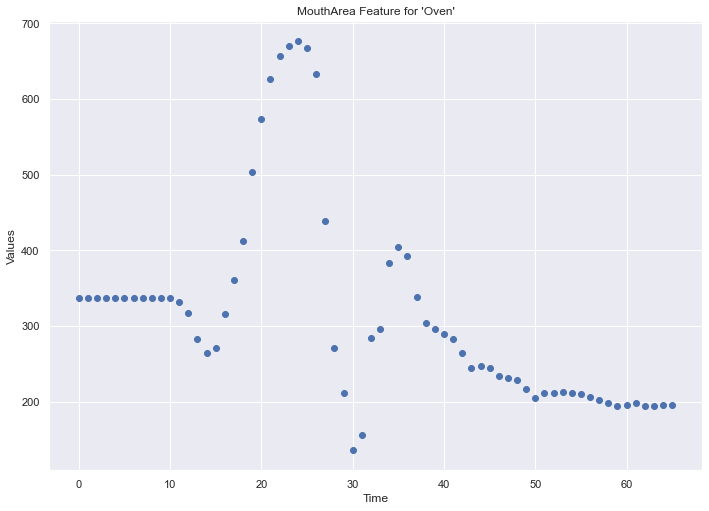

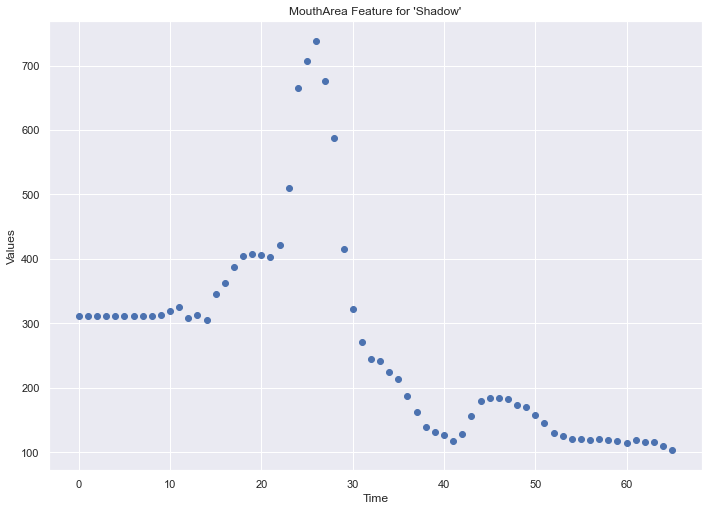

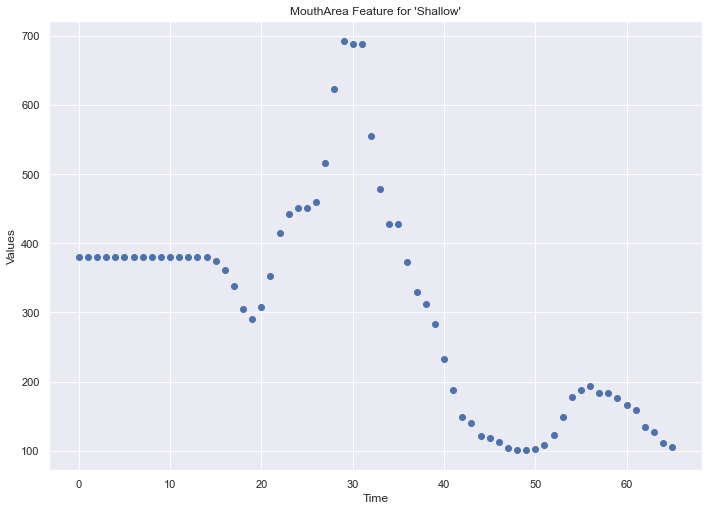

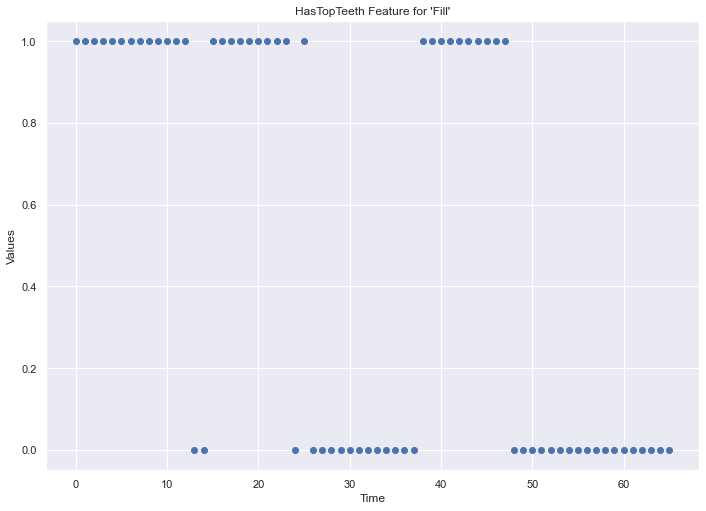

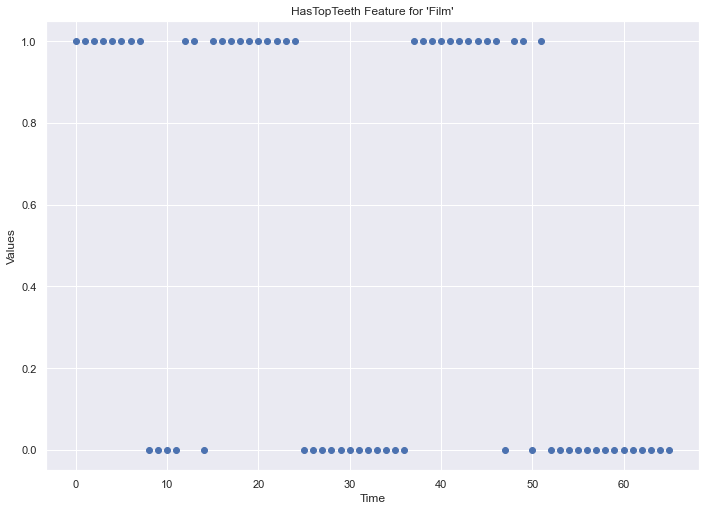

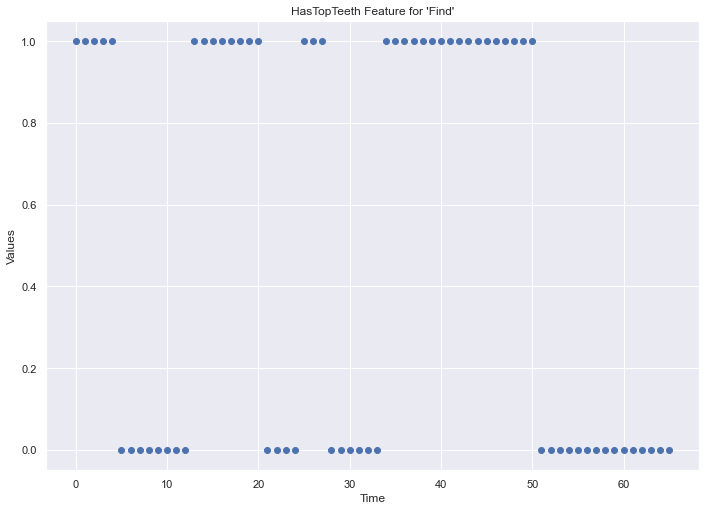

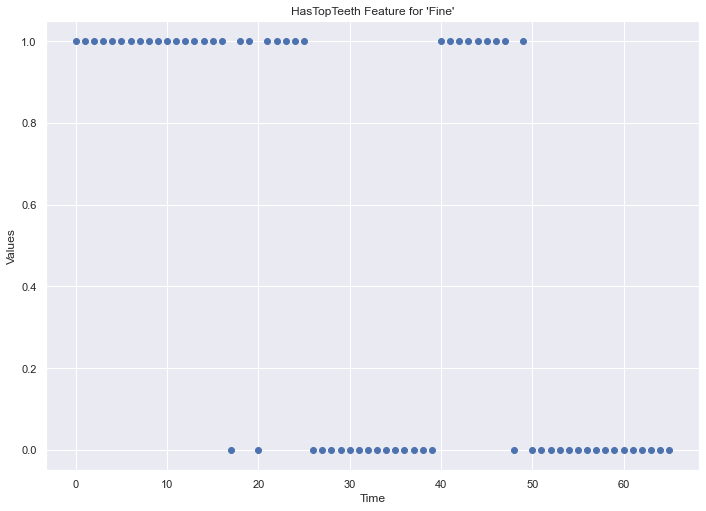

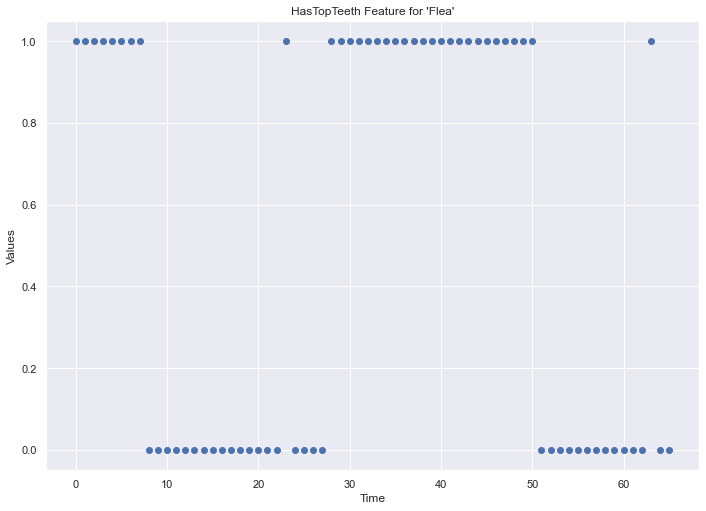

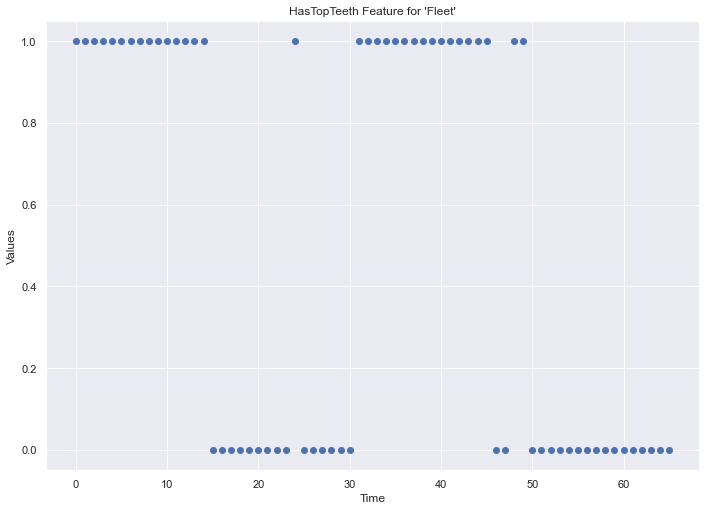

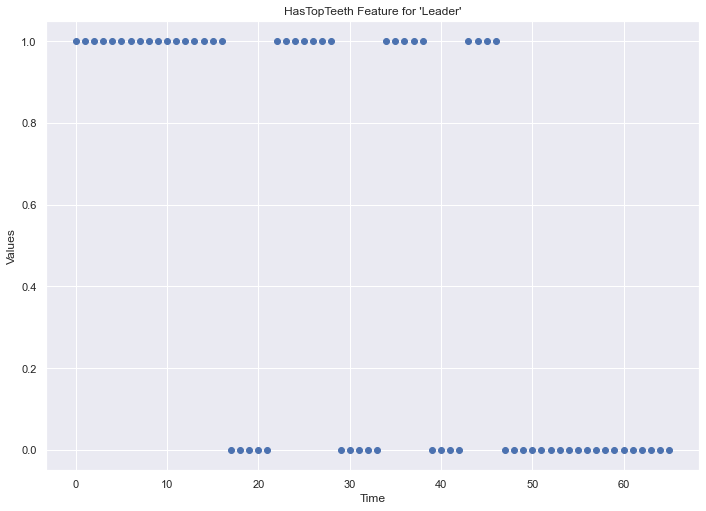

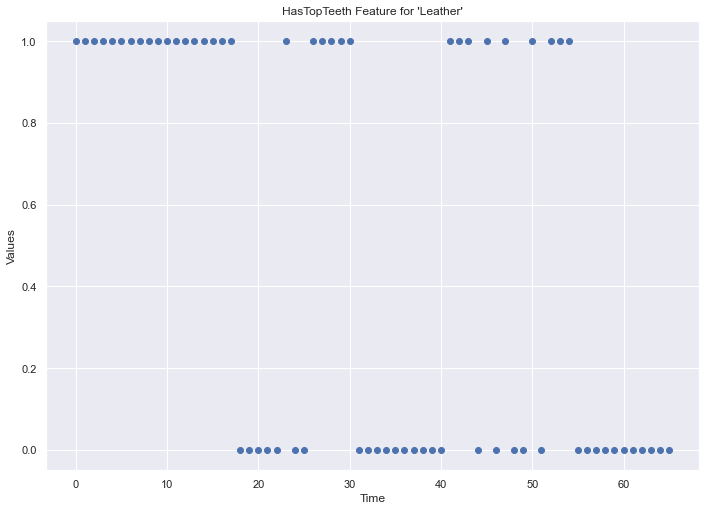

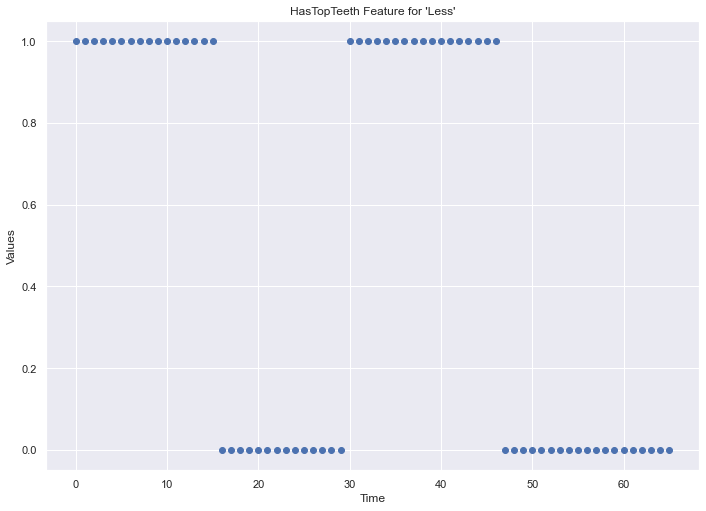

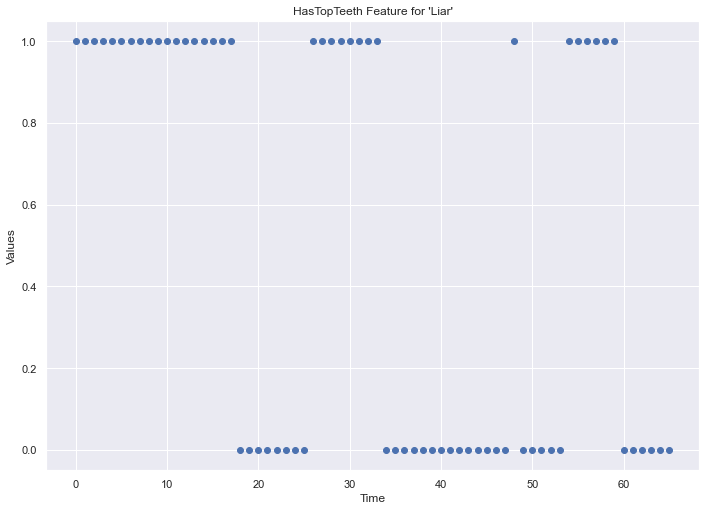

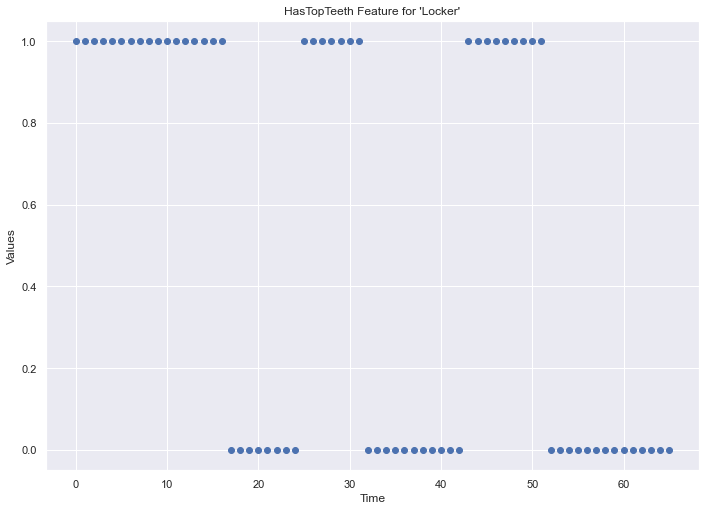

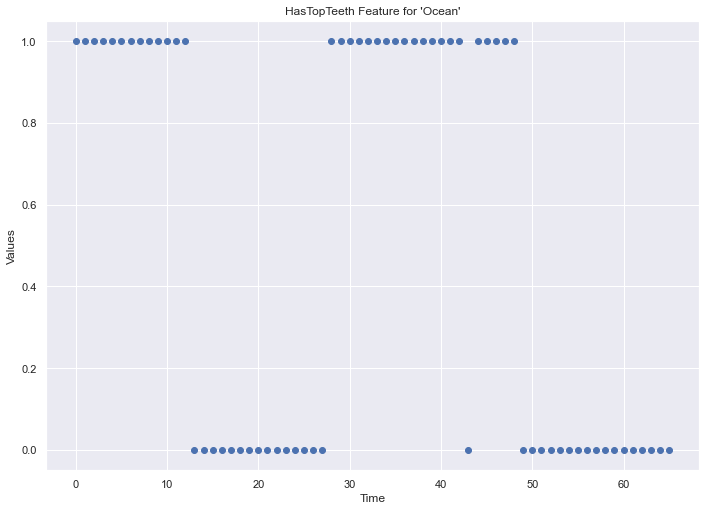

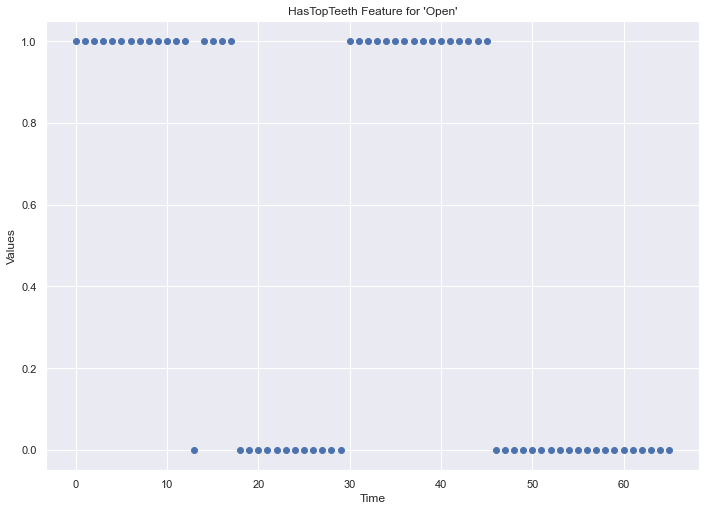

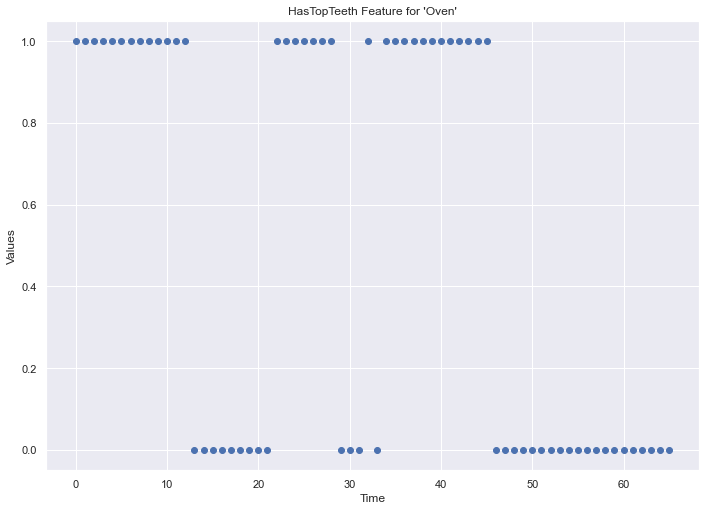

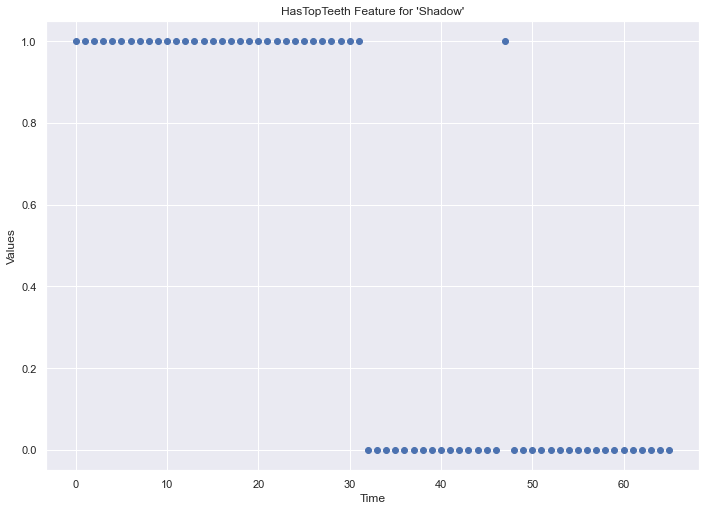

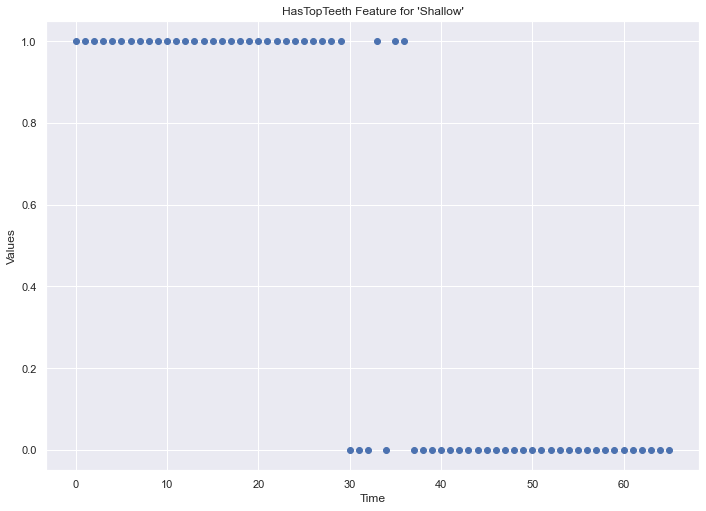

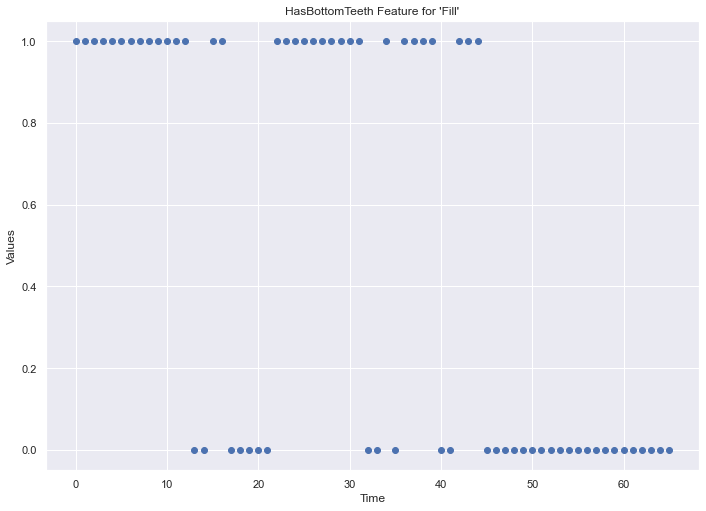

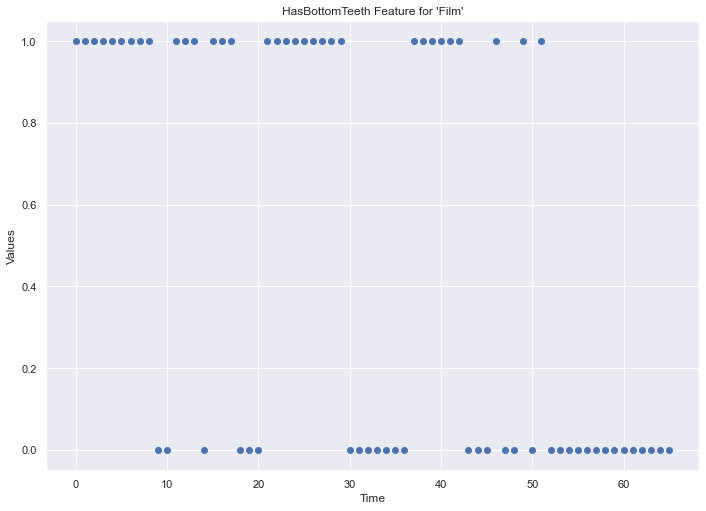

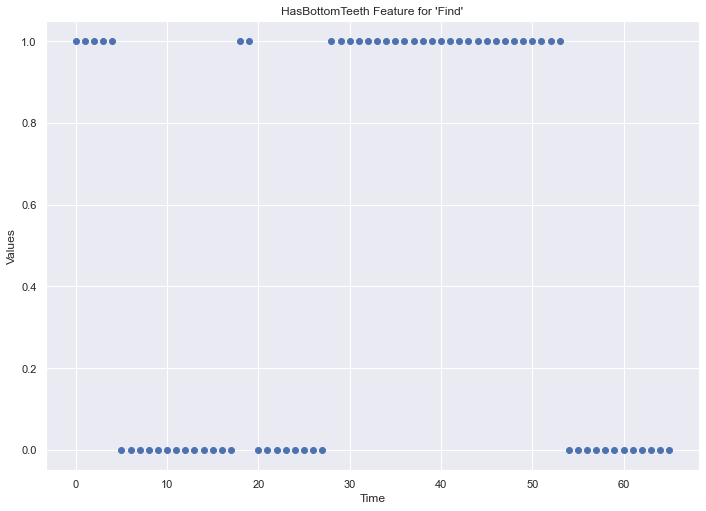

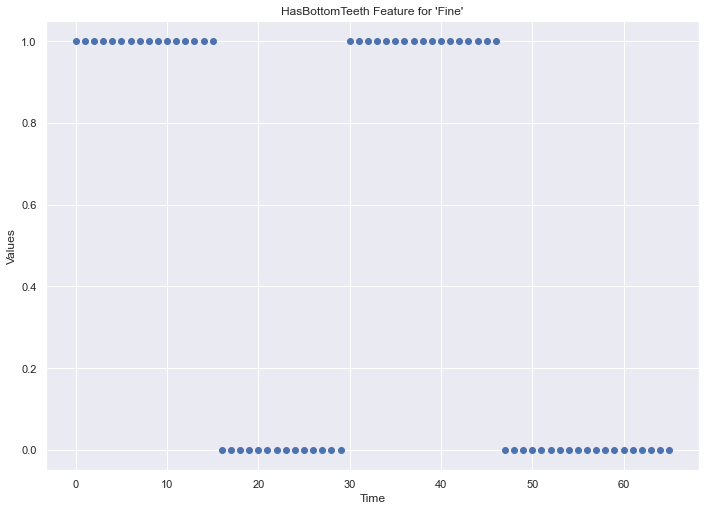

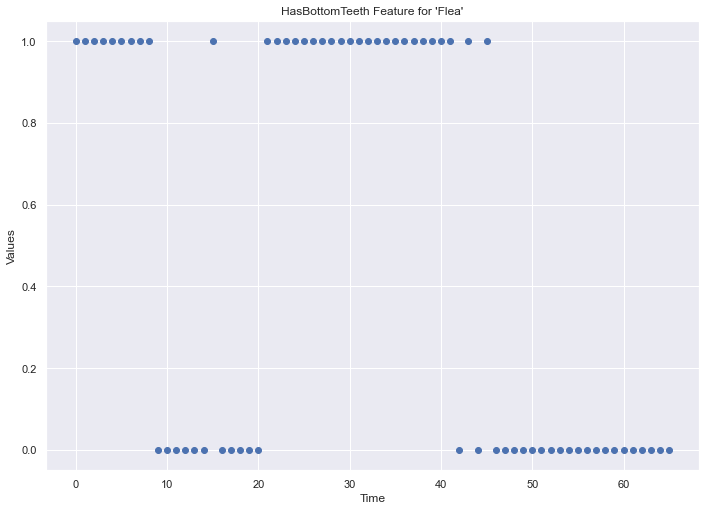

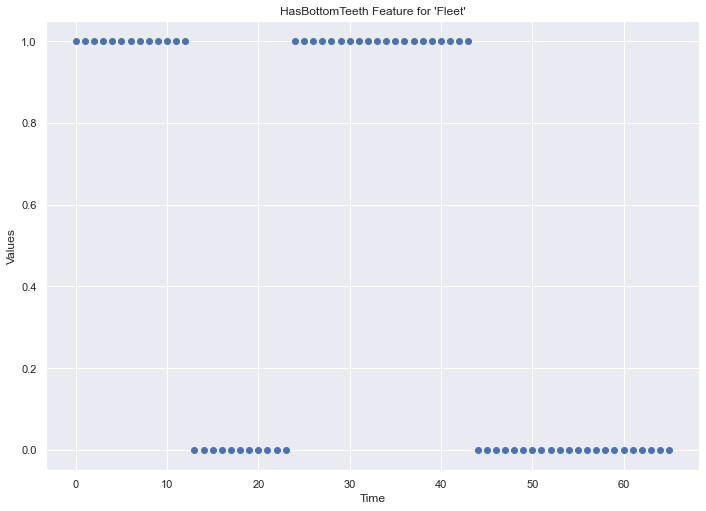

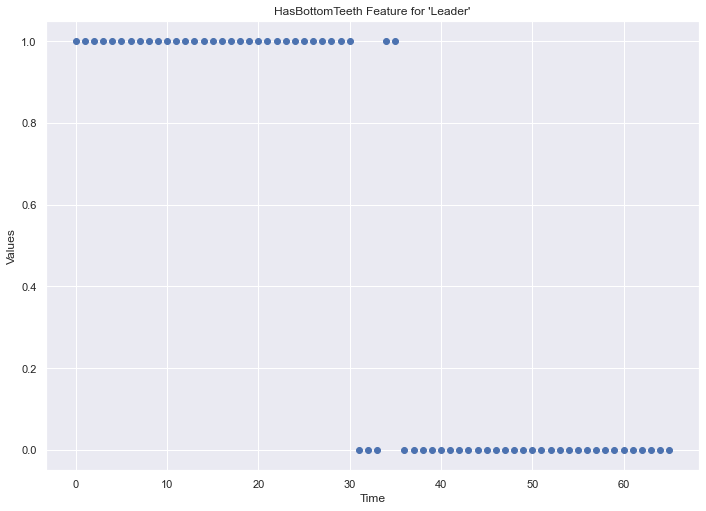

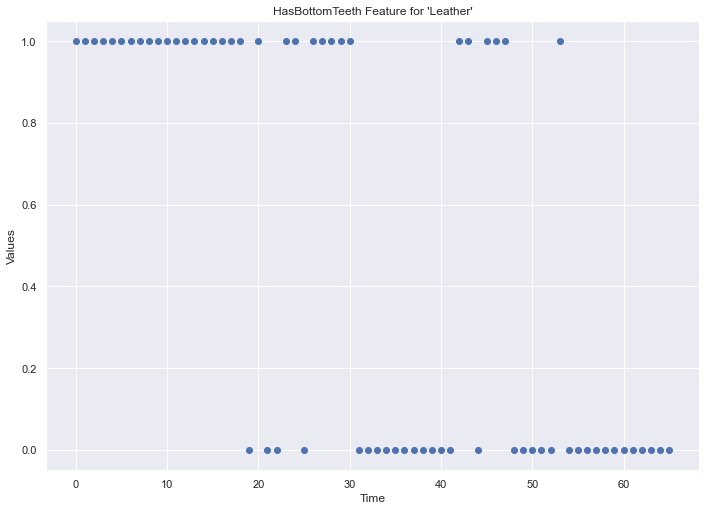

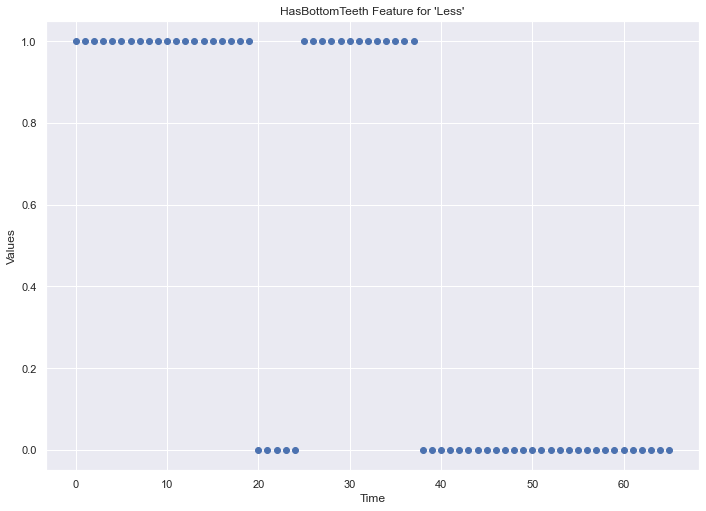

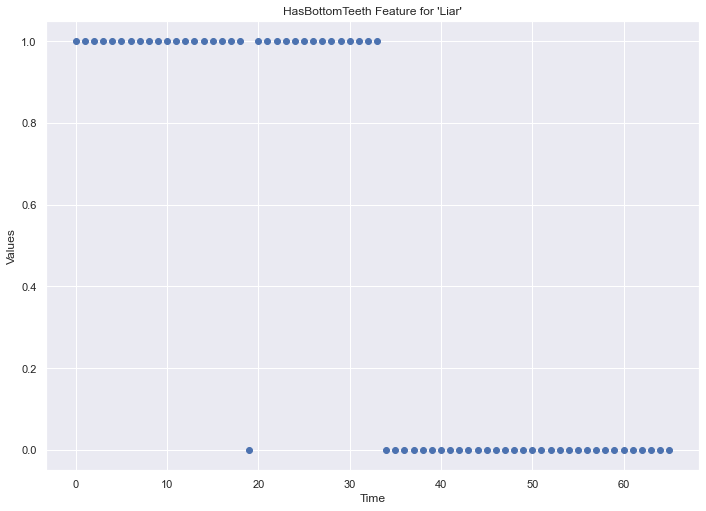

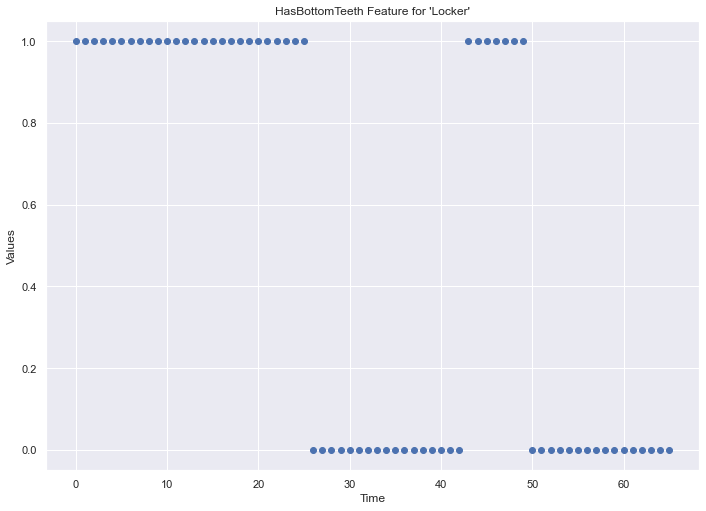

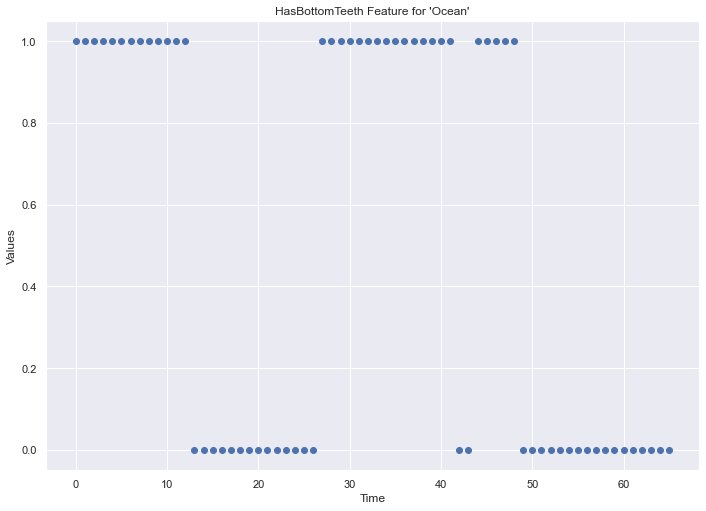

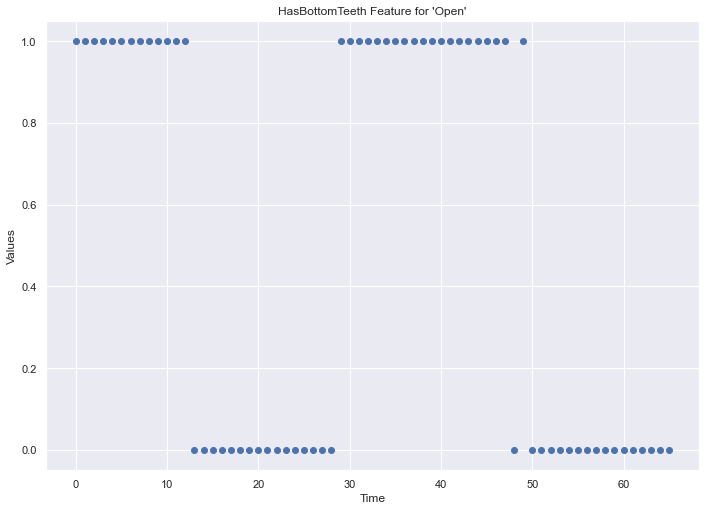

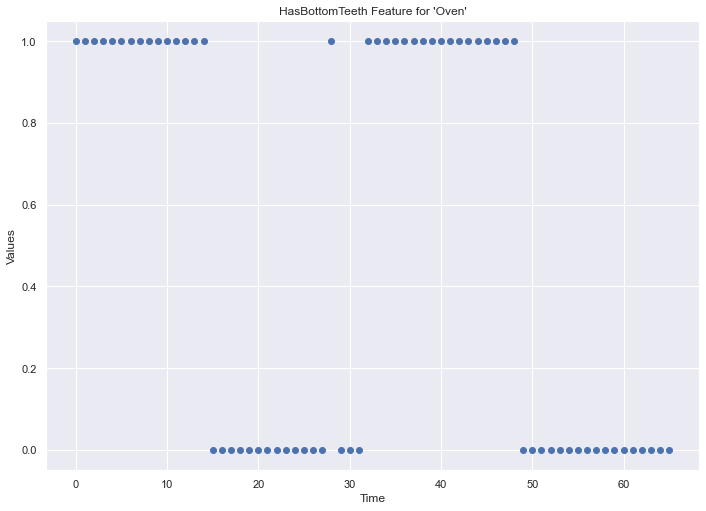

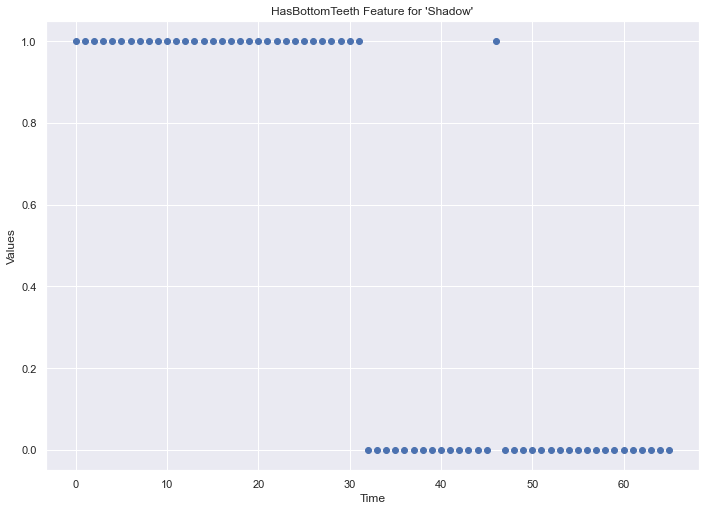

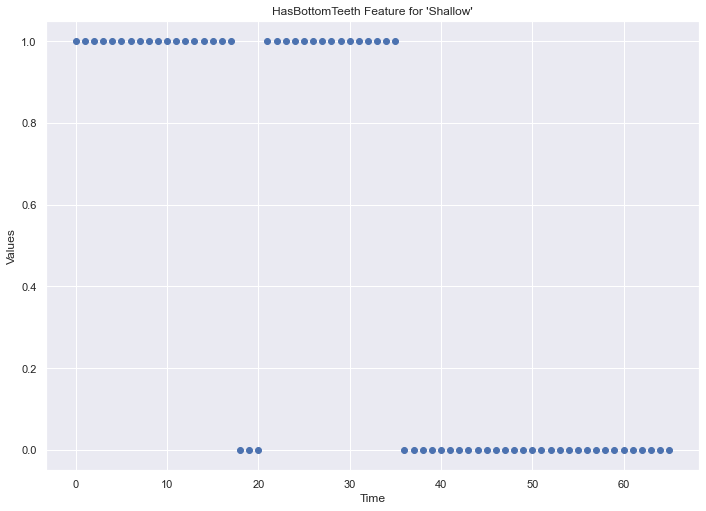

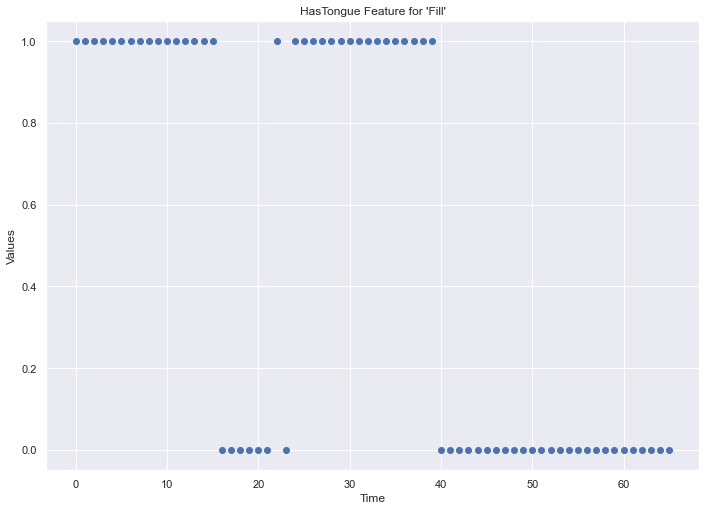

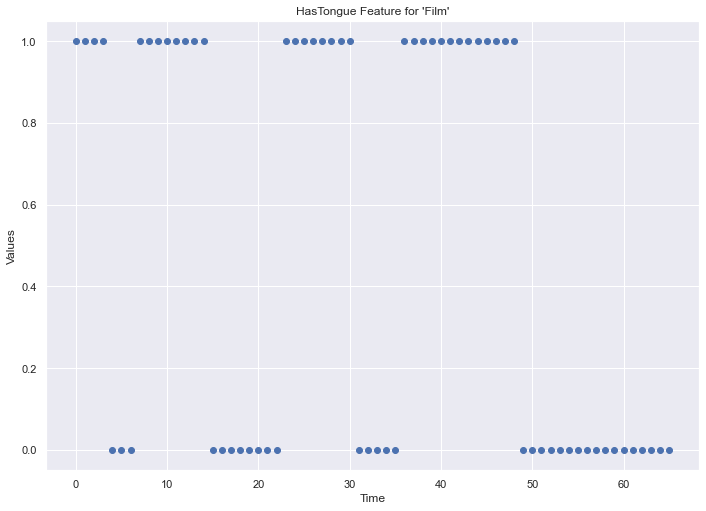

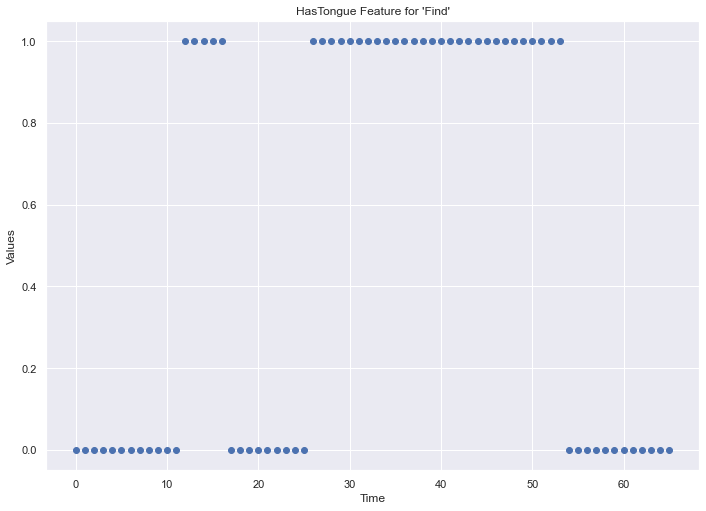

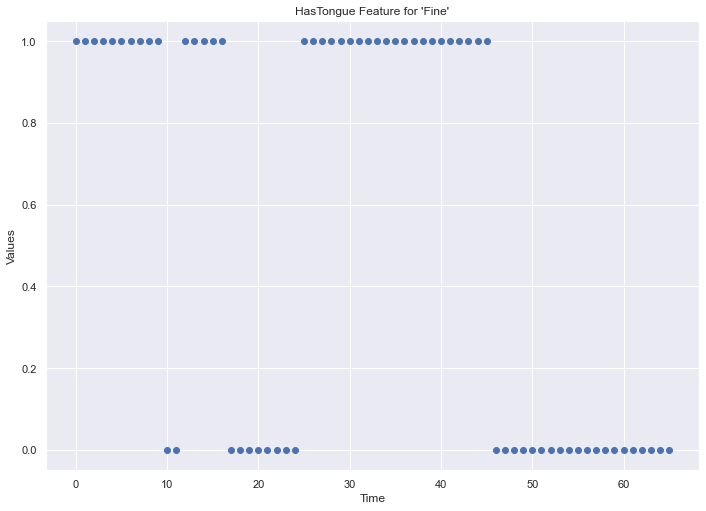

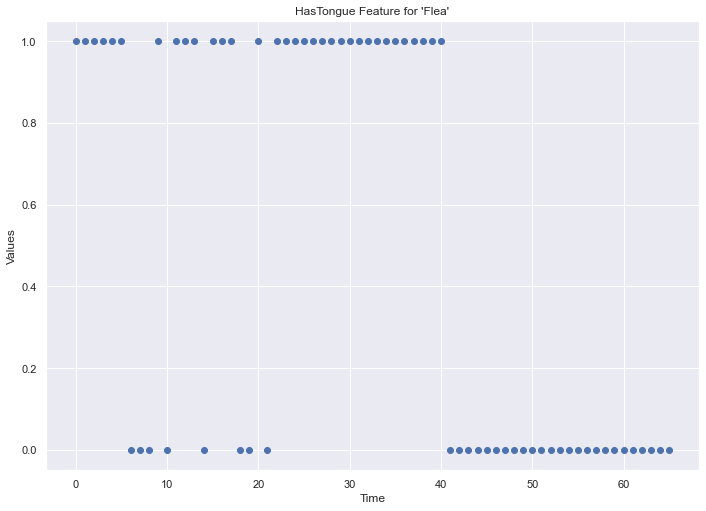

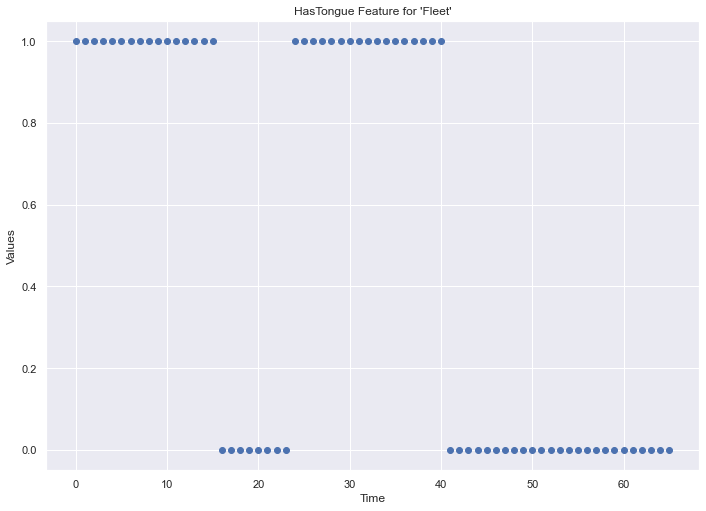

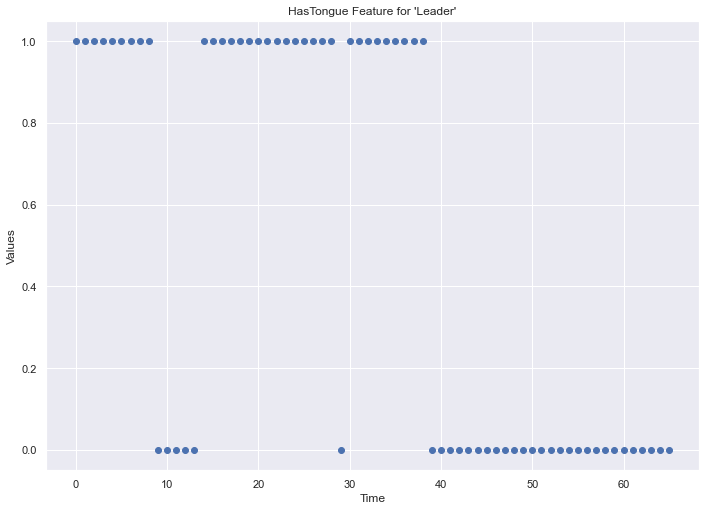

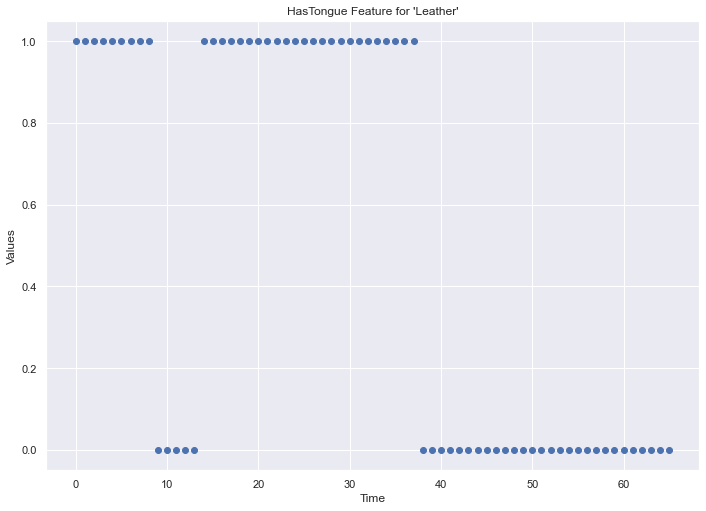

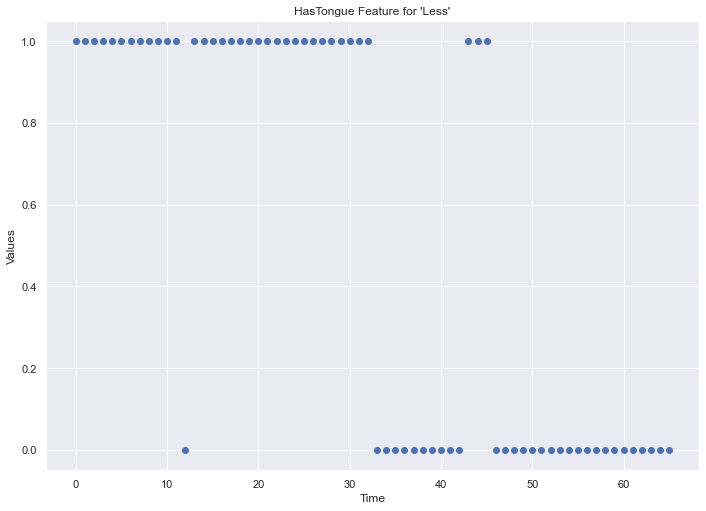

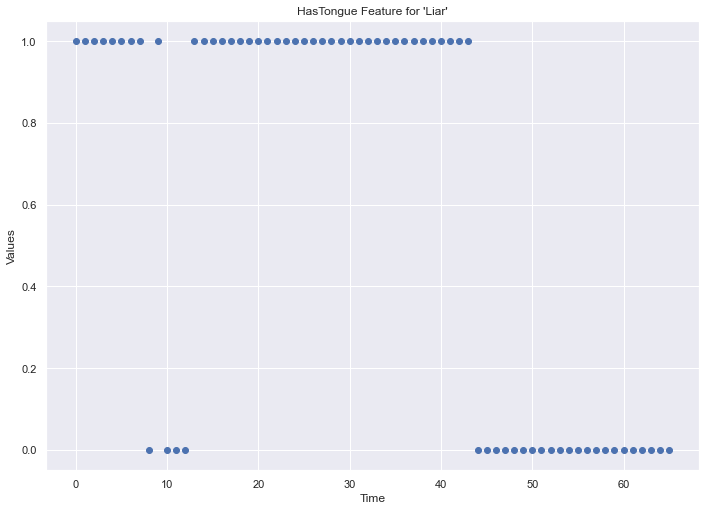

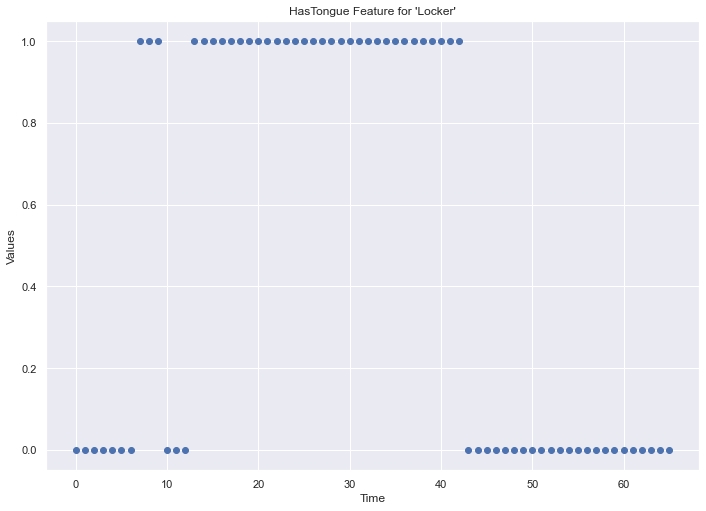

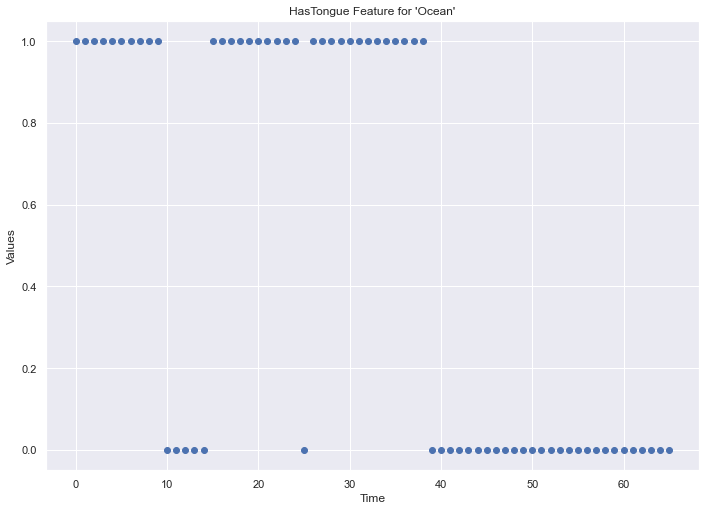

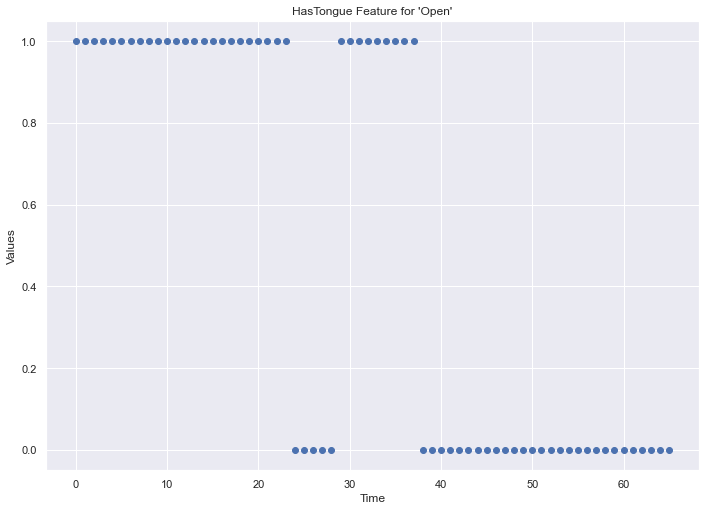

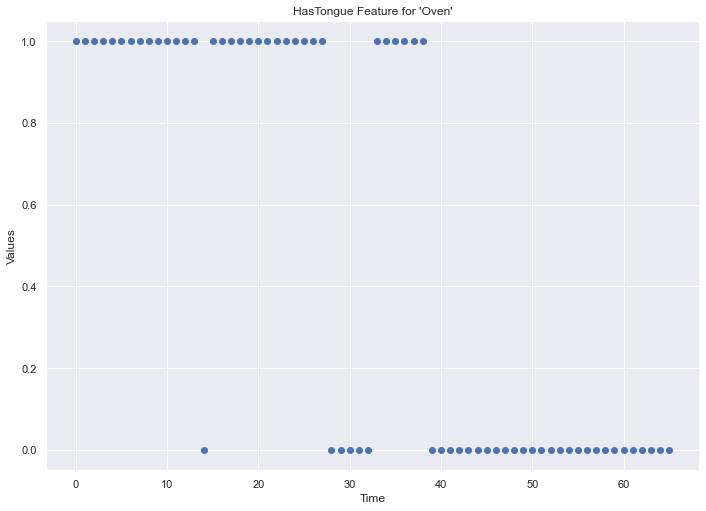

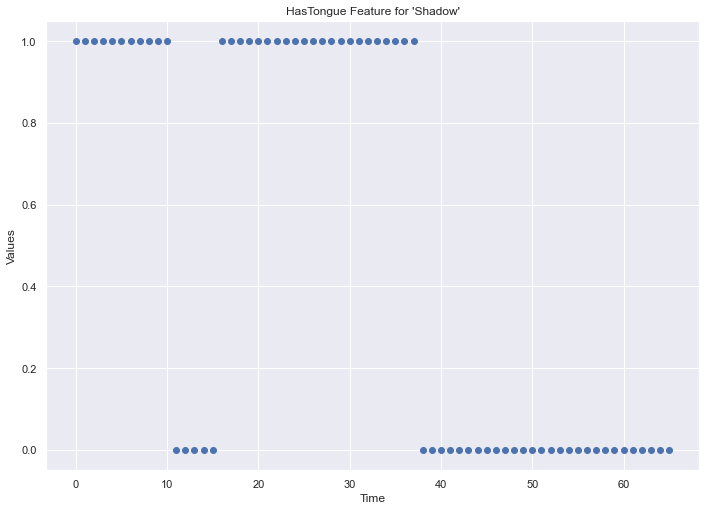

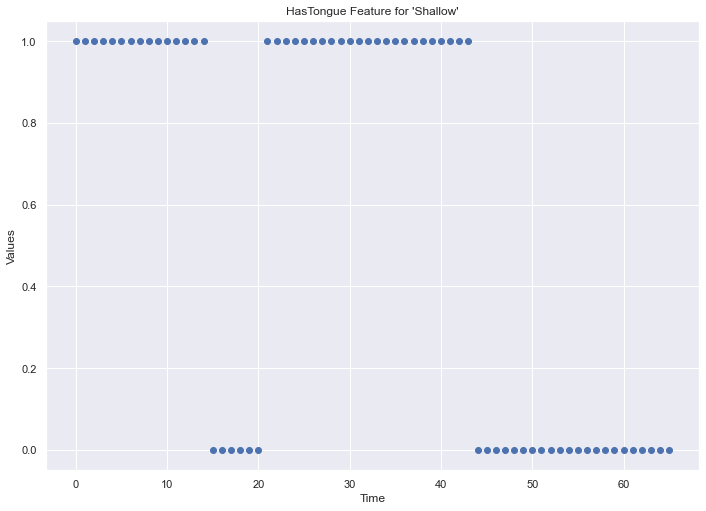

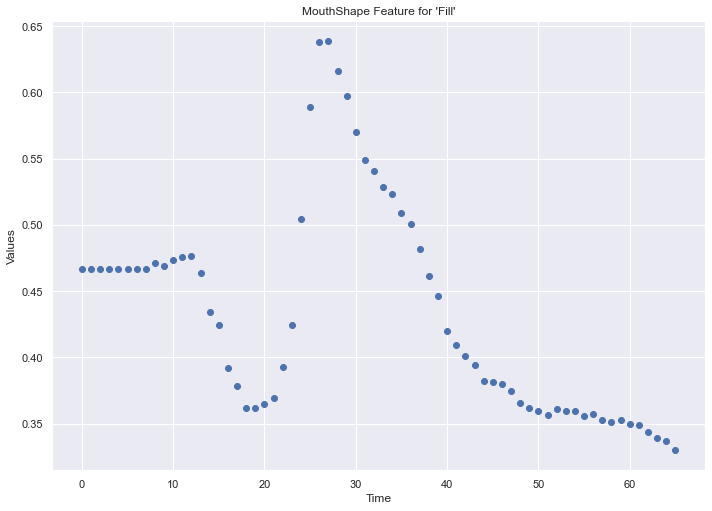

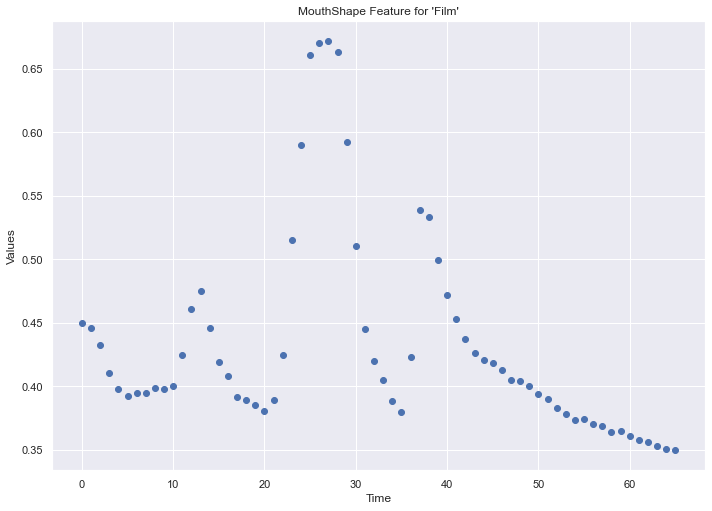

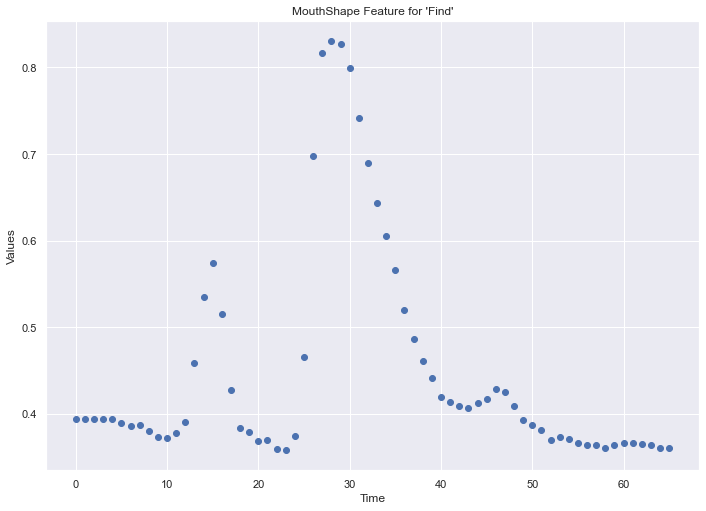

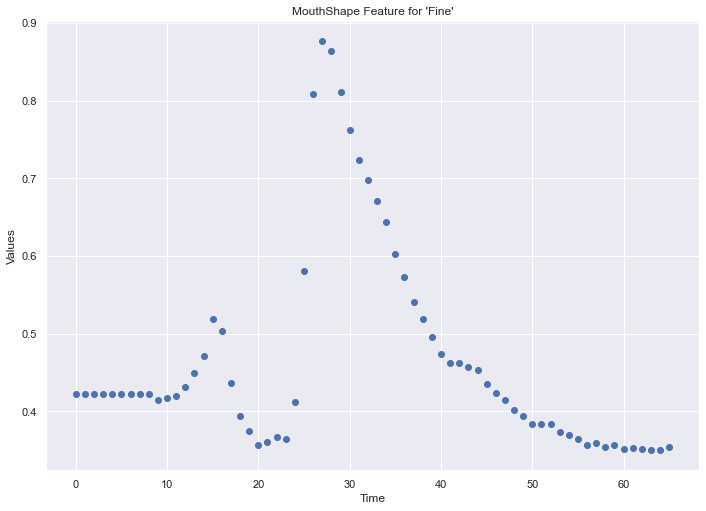

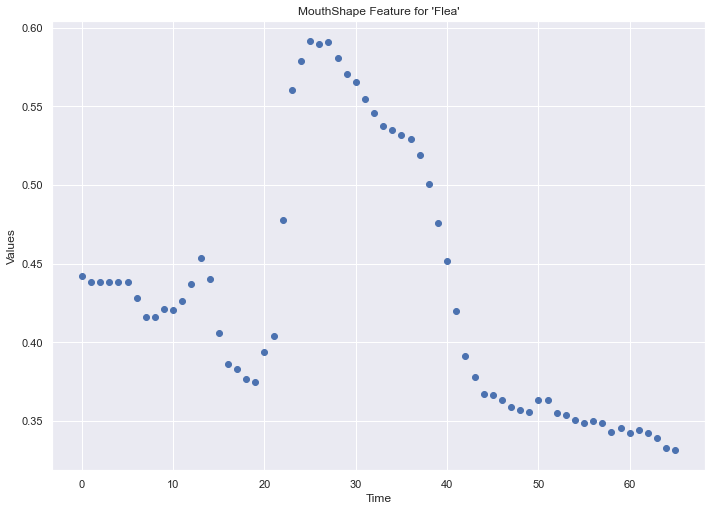

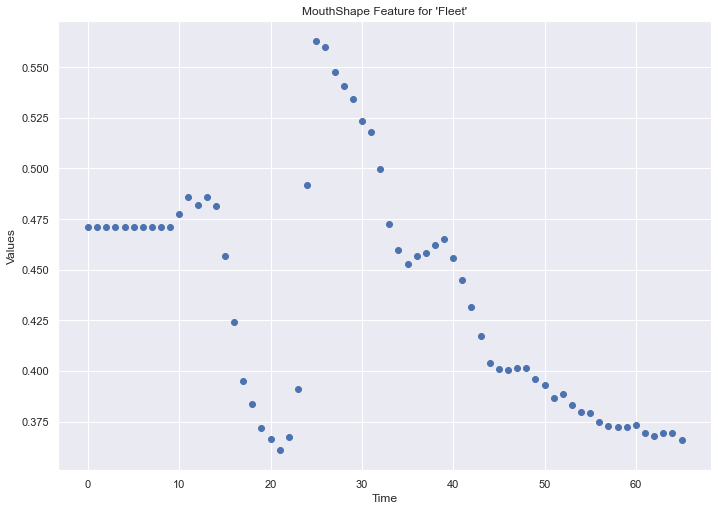

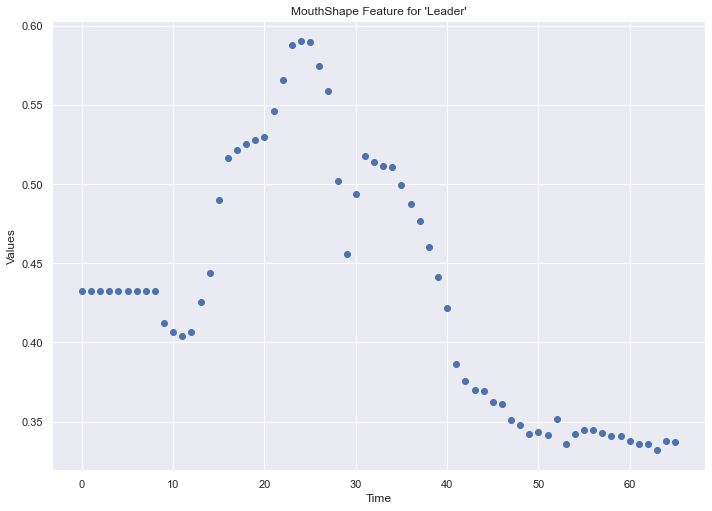

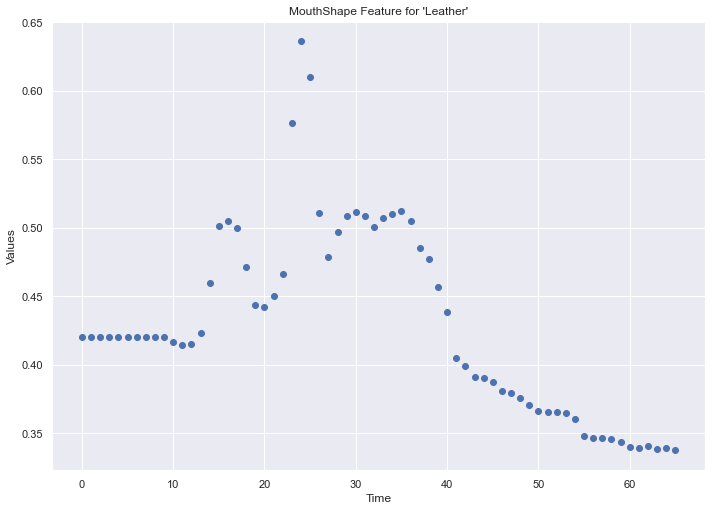

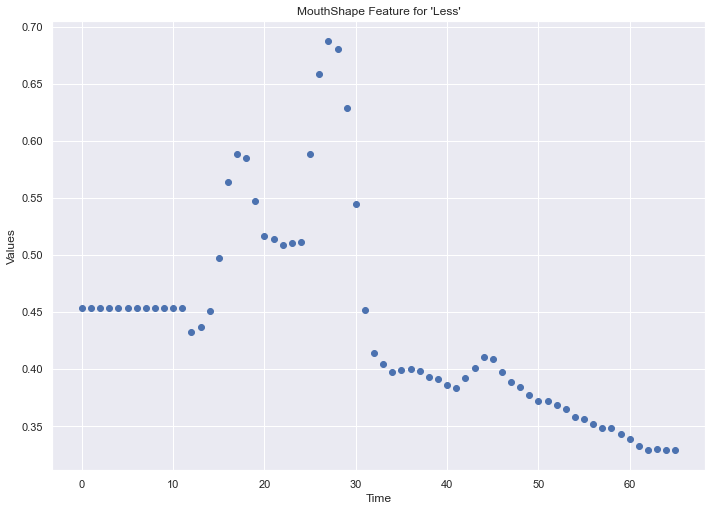

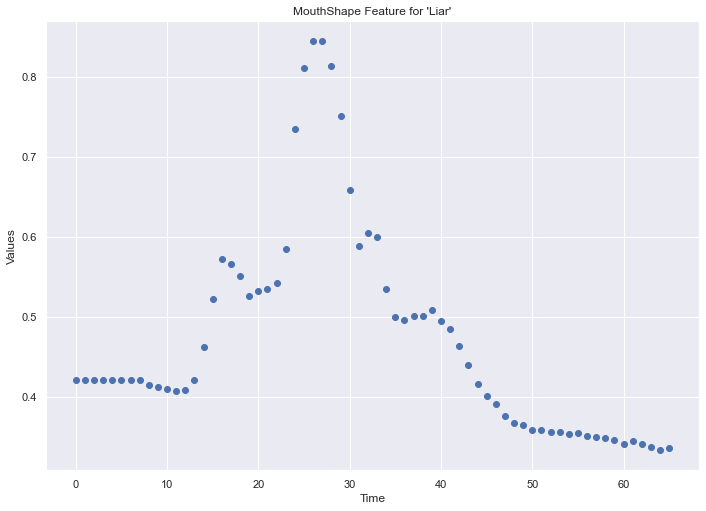

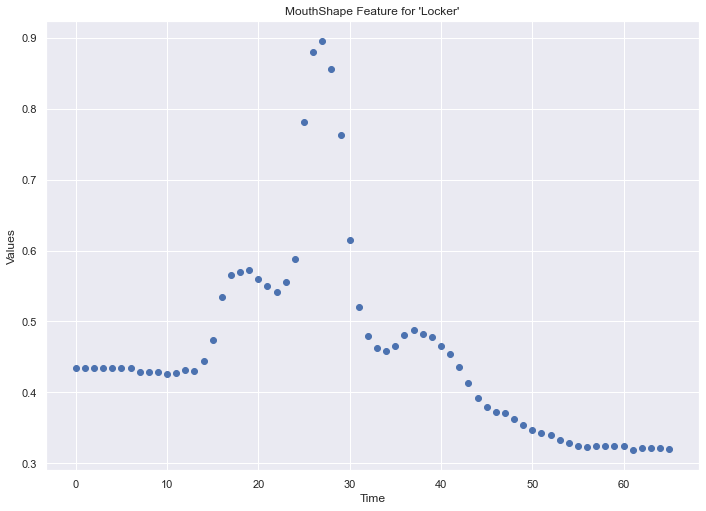

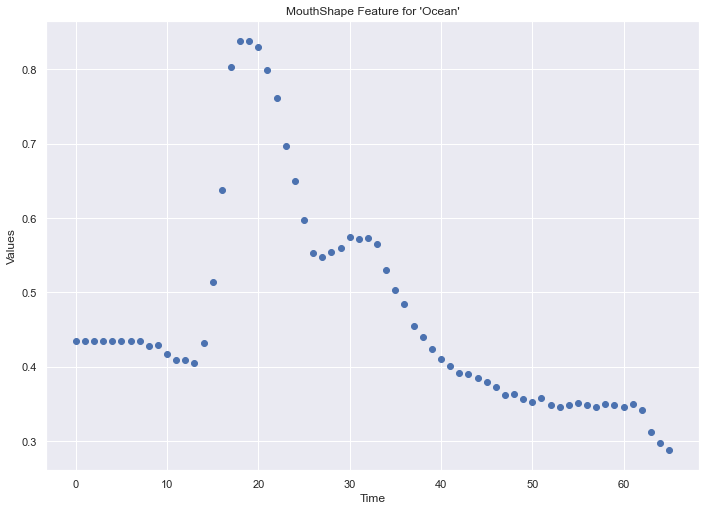

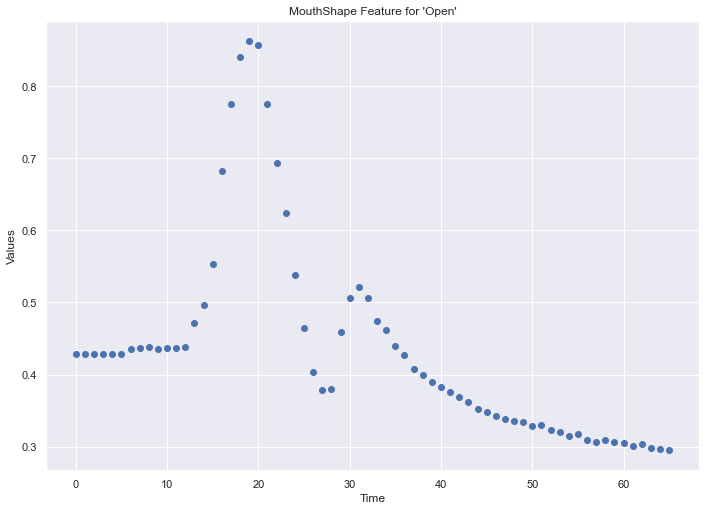

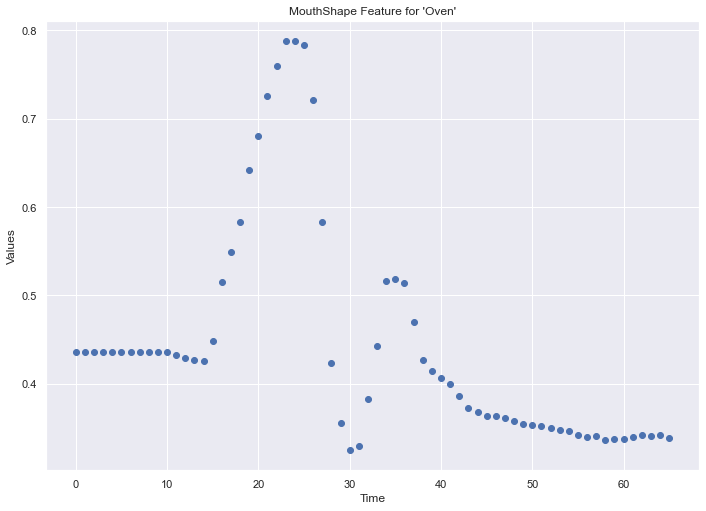

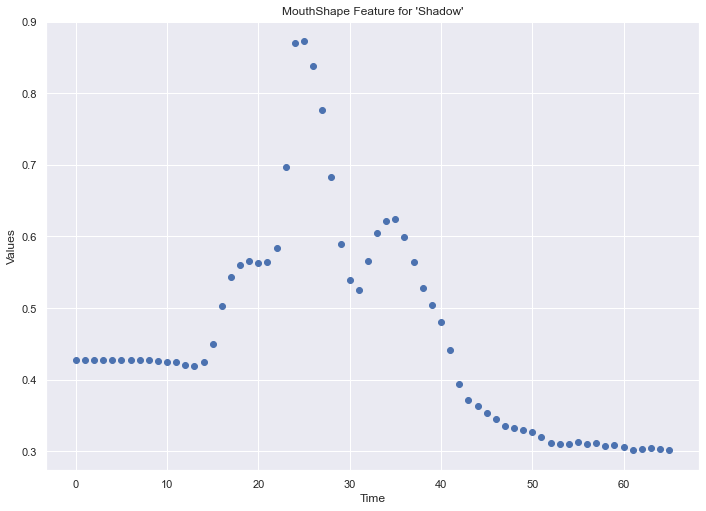

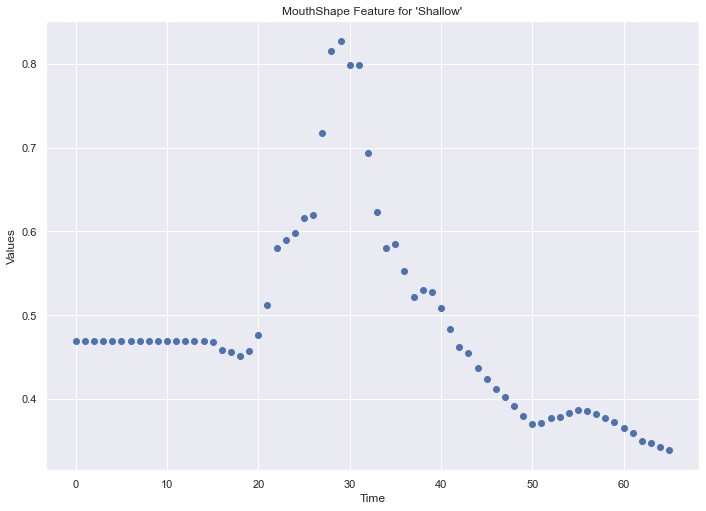

In [74]:
for col in df_new_features[0].columns:
    for i in range(len(df_new_features)):
        df = df_new_features[i]
        plt.figure()
        plt.scatter(range(len(df)), df[col])
        plt.title(f"{col} Feature for '{words[i]}'")
        plt.xlabel("Time")
        plt.ylabel("Values")
    

plt.show()

In [75]:
## TODO: create vectors according to threshold for thing (how to determine threshold?)

In [76]:
# get distributions to see whether use min-max scaling/normalization (0-1) or standardization (mean 0, std 1)

mouth_areas = np.zeros((len(df_new_features), len(df_new_features[0])))
for i, df in enumerate(df_new_features):
    mouth_areas[i,:] = df["MouthArea"]
    
mouth_areas = mouth_areas.reshape(-1)

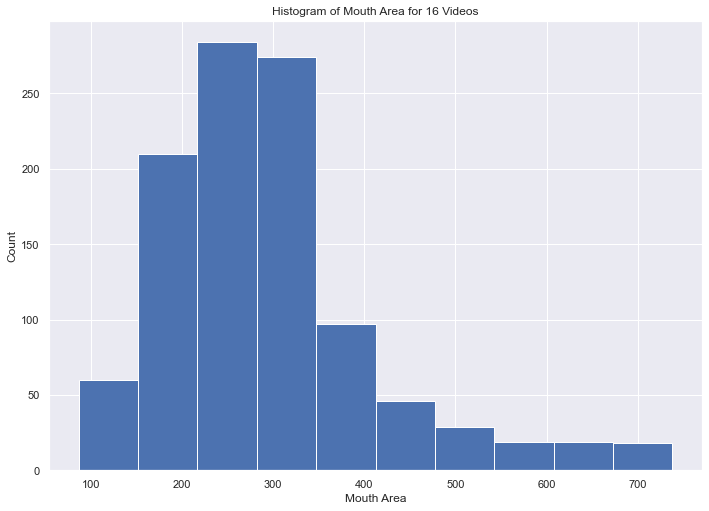

In [77]:
plt.hist(mouth_areas)
plt.title(f"Histogram of Mouth Area for {len(df_new_features)} Videos")
plt.xlabel("Mouth Area")
plt.ylabel("Count")
plt.show()

# New Normalization

In [78]:
# create single vector of all word features
all_mouth_areas = []

for i,df in enumerate(df_new_features):
    all_mouth_areas = np.concatenate([all_mouth_areas, df['MouthArea']])

# fit data using all mouth areas
scaler = MinMaxScaler().fit(all_mouth_areas.reshape(-1,1))    

# fill in mouth area
mouth_areas_scaled = np.zeros((len(df_new_features), len(df_new_features[0])))
for i, df in enumerate(df_new_features):
    mouth_areas_scaled[i,:] = df["MouthArea"]
    
mouth_areas_scaled = scaler.fit_transform(mouth_areas_scaled)
mouth_areas_scaled_flat = mouth_areas_scaled.reshape(-1)

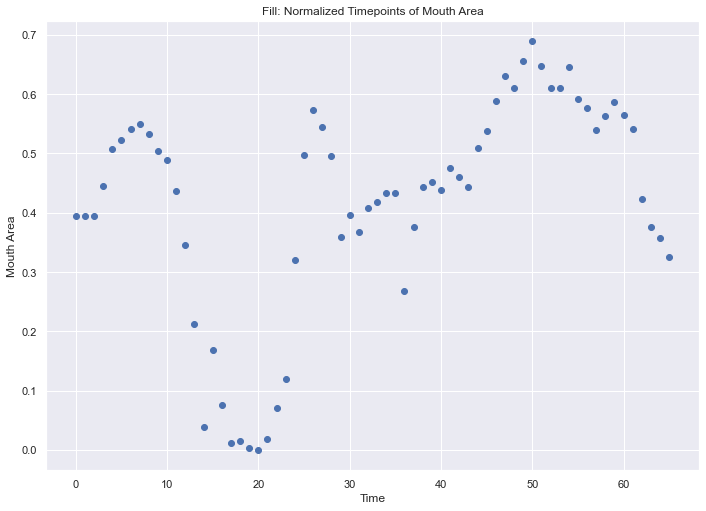

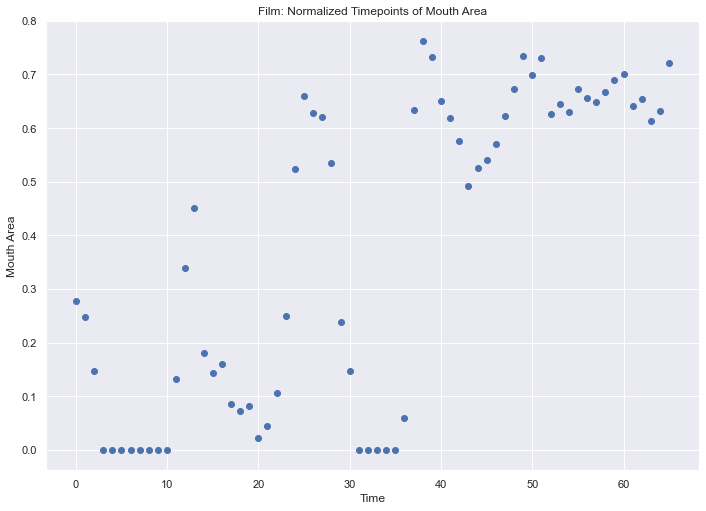

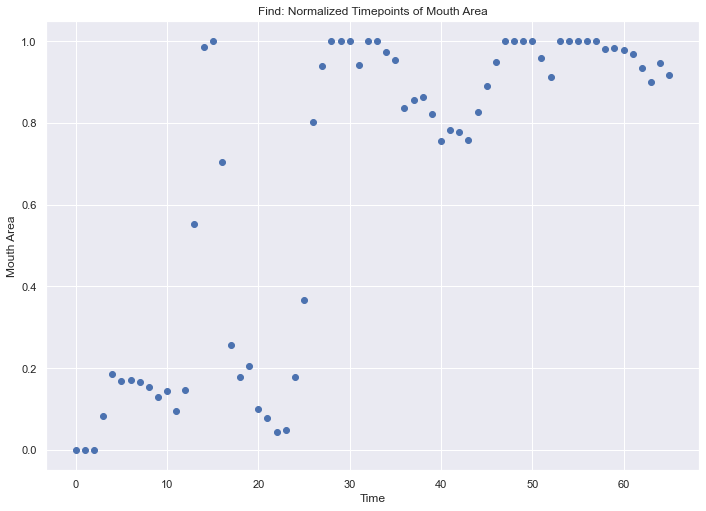

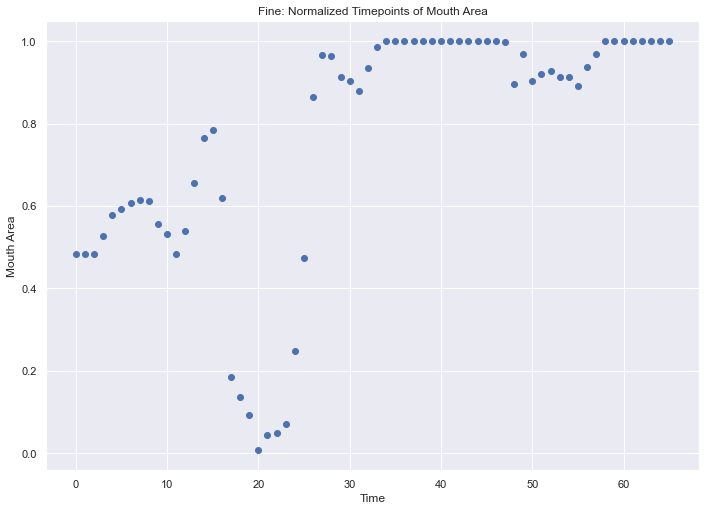

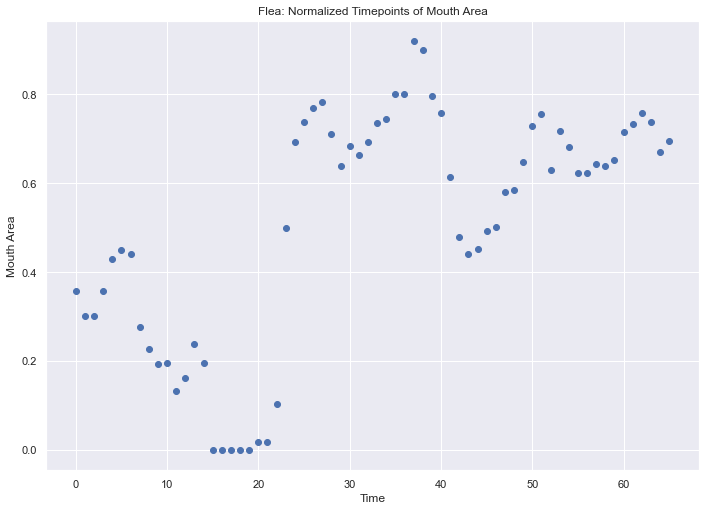

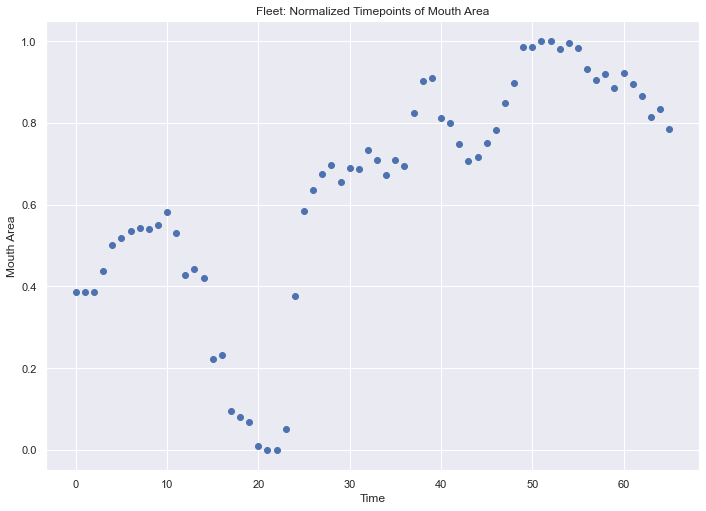

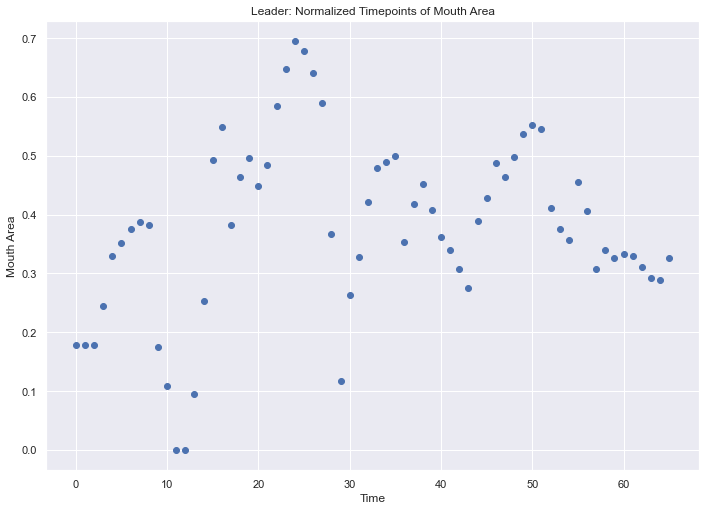

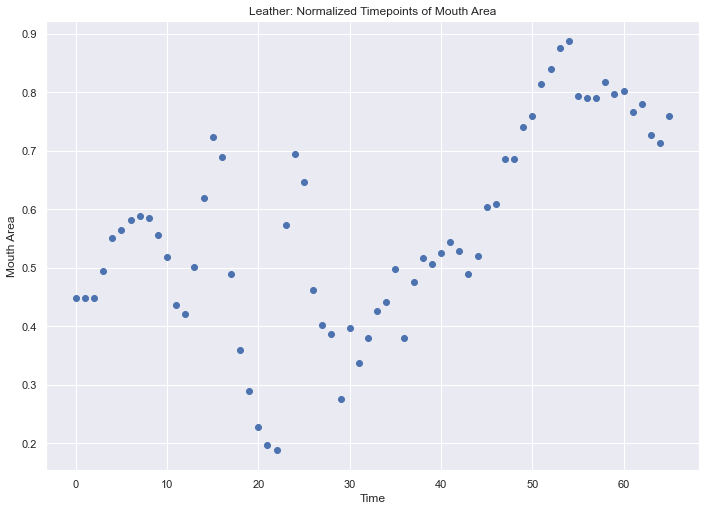

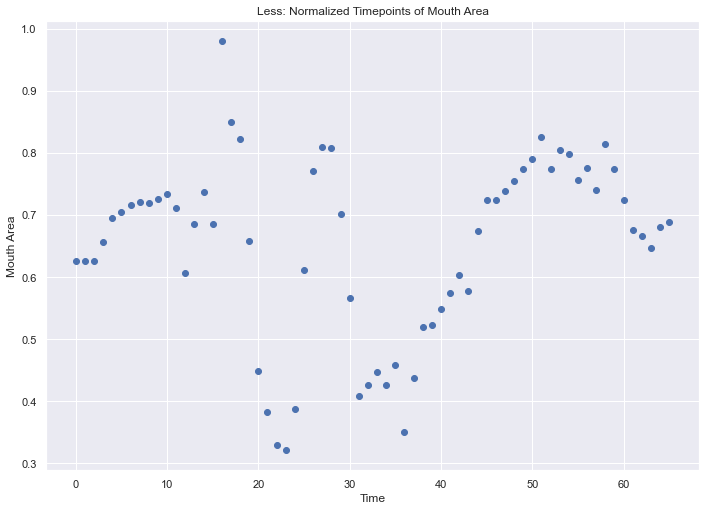

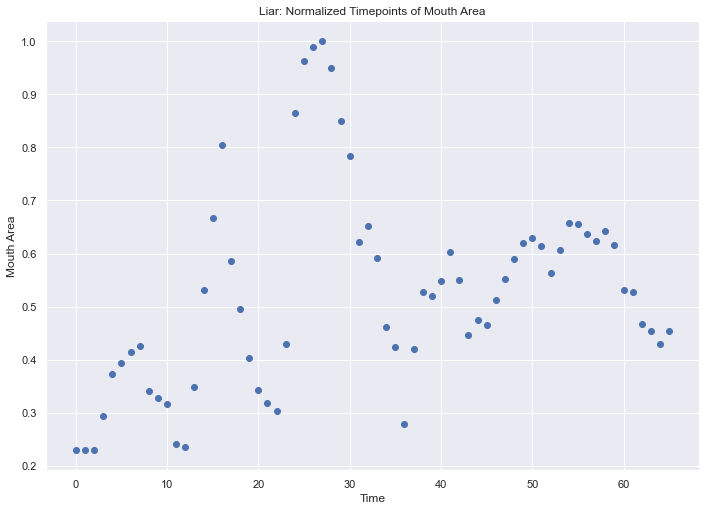

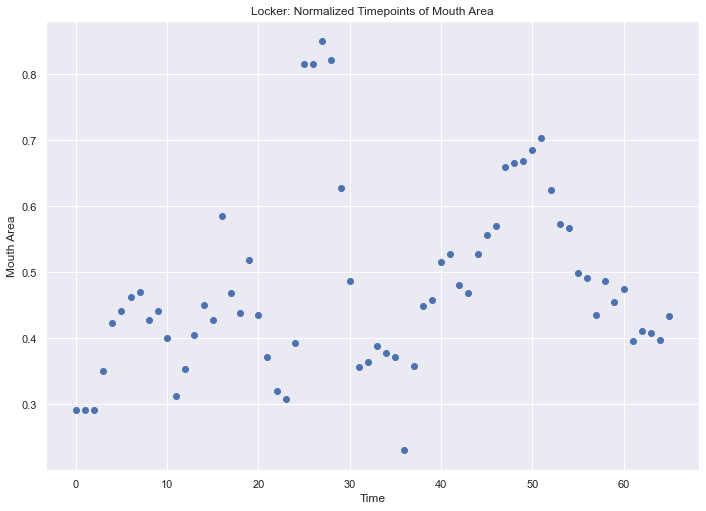

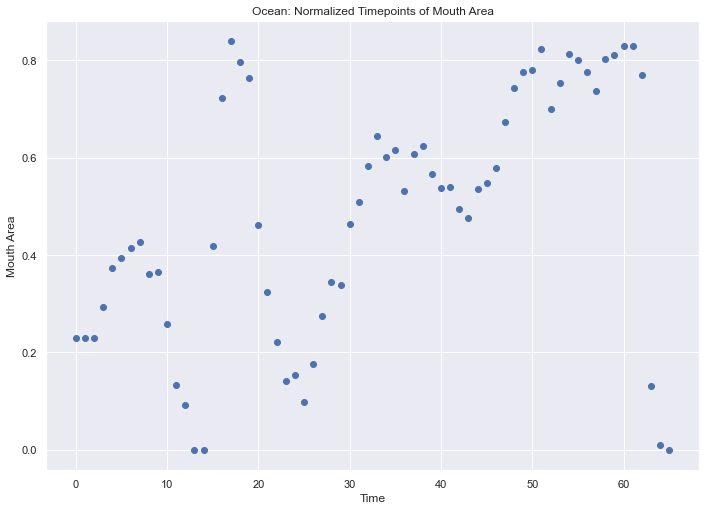

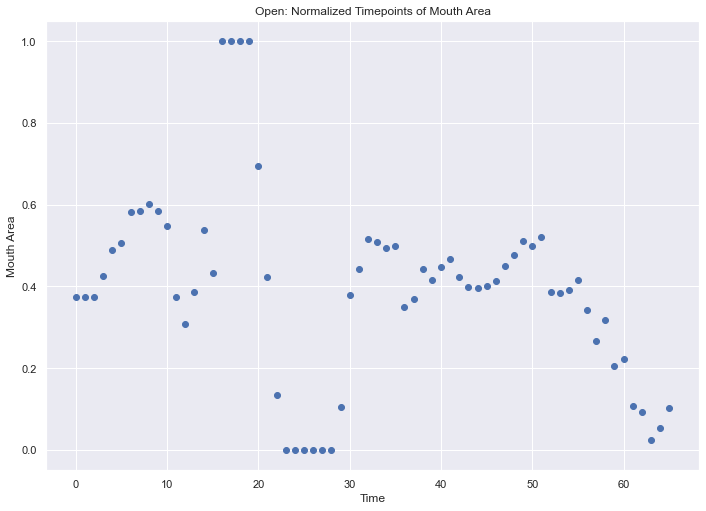

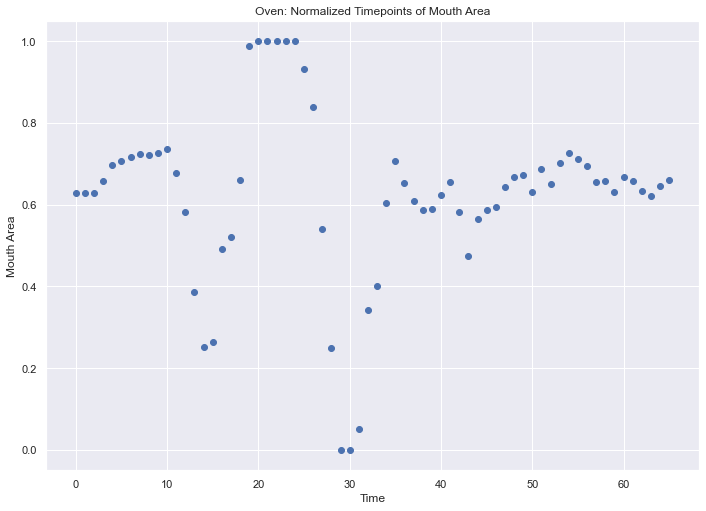

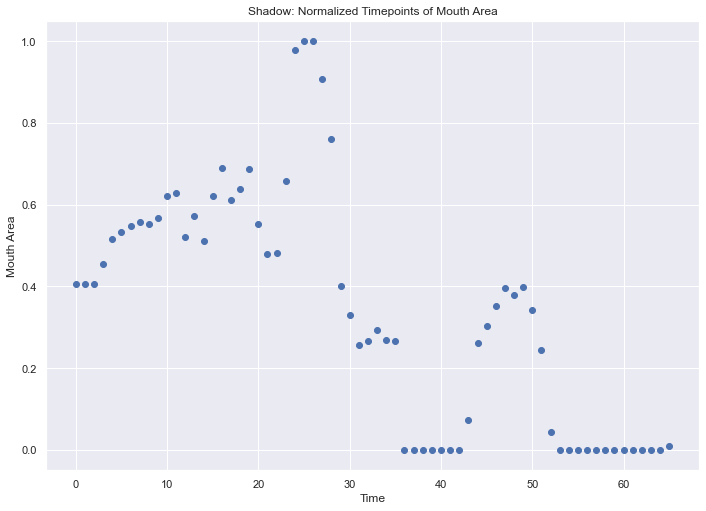

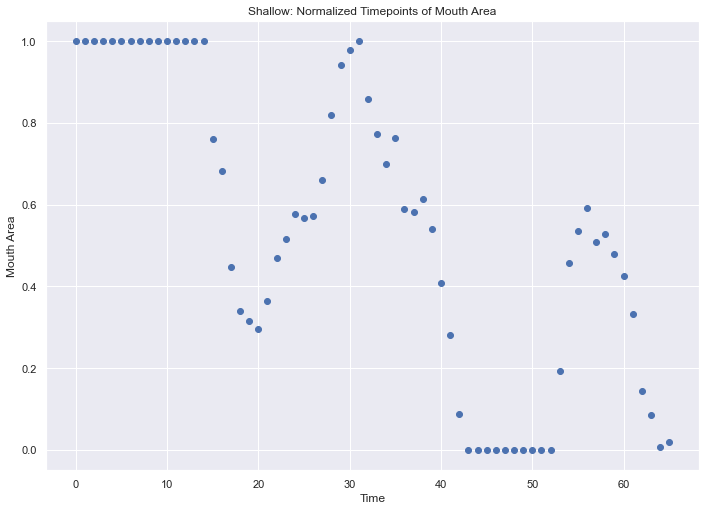

In [79]:
# generate plots of new feature data
for i in range(len(df_new_features)):
    plt.figure()
    plt.scatter(range(len(df_new_features[0])), mouth_areas_scaled[i,:])
    plt.title(f"{words[i].capitalize()}: Normalized Timepoints of Mouth Area")
    plt.xlabel("Time")
    plt.ylabel("Mouth Area")

plt.show()

# Old Normalization

In [80]:
scaler = MinMaxScaler()
mouth_areas_scaled = np.zeros((len(df_new_features), len(df_new_features[0])))
for i, df in enumerate(df_new_features):
    mouth_areas_scaled[i,:] = df["MouthArea"]
    
mouth_areas_scaled = scaler.fit_transform(mouth_areas_scaled)
mouth_areas_scaled_flat = mouth_areas_scaled.reshape(-1)

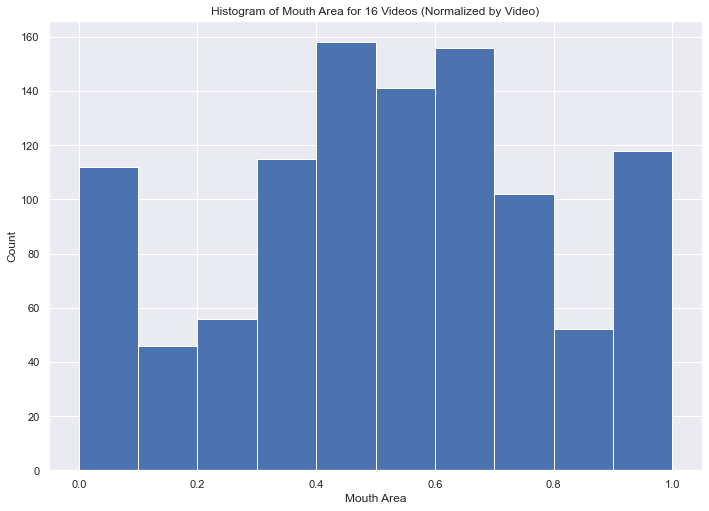

In [81]:
plt.hist(mouth_areas_scaled_flat)
plt.title(f"Histogram of Mouth Area for {len(df_new_features)} Videos (Normalized by Video)")
plt.xlabel("Mouth Area")
plt.ylabel("Count")
plt.show()

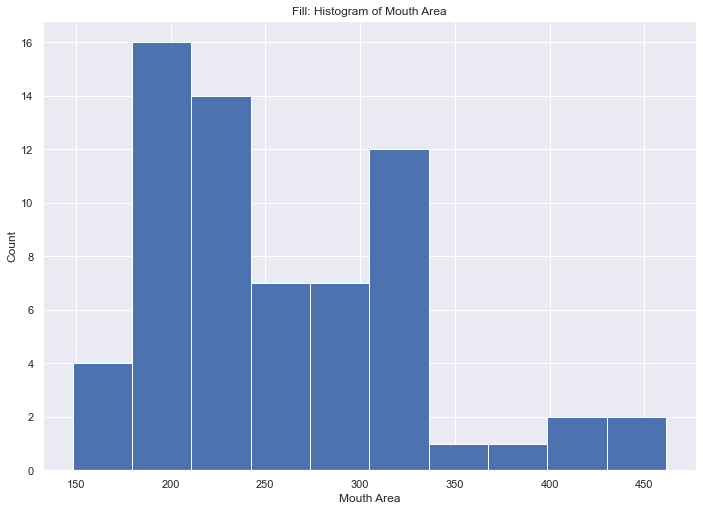

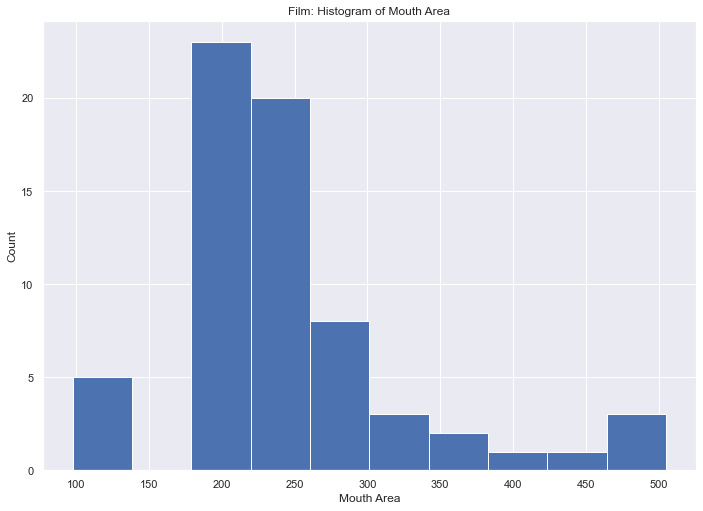

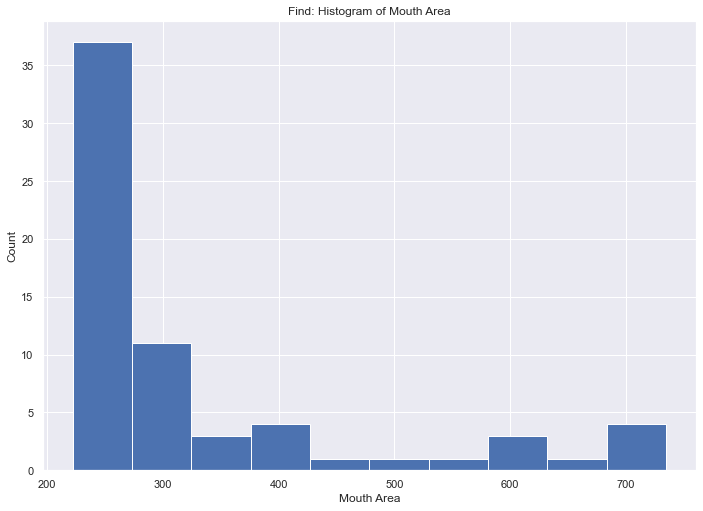

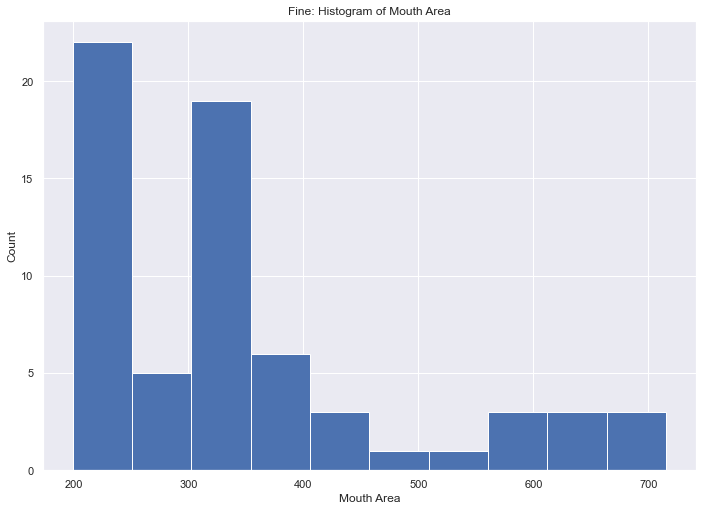

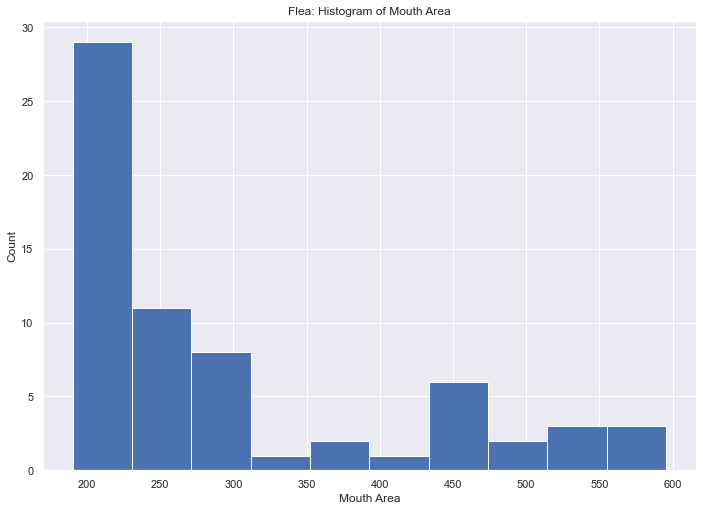

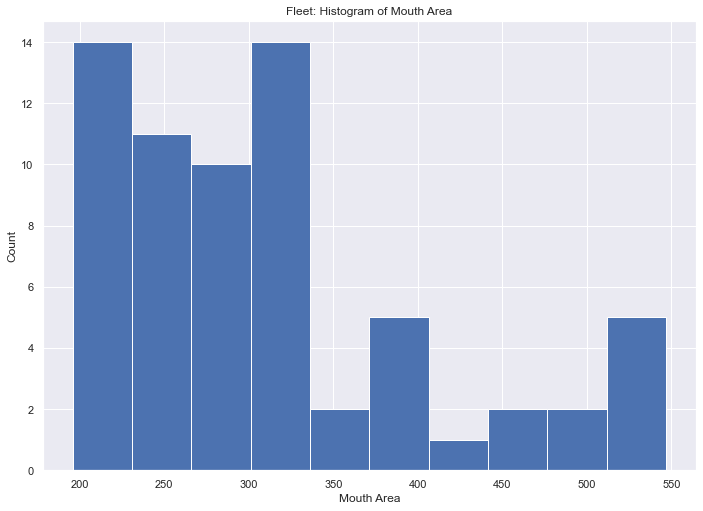

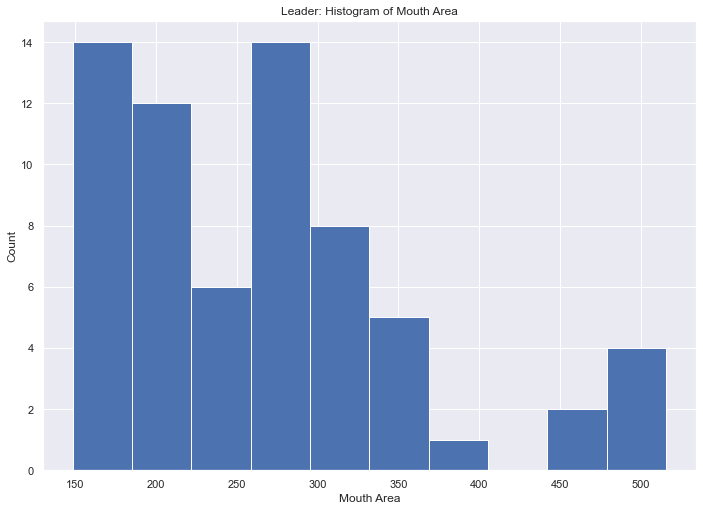

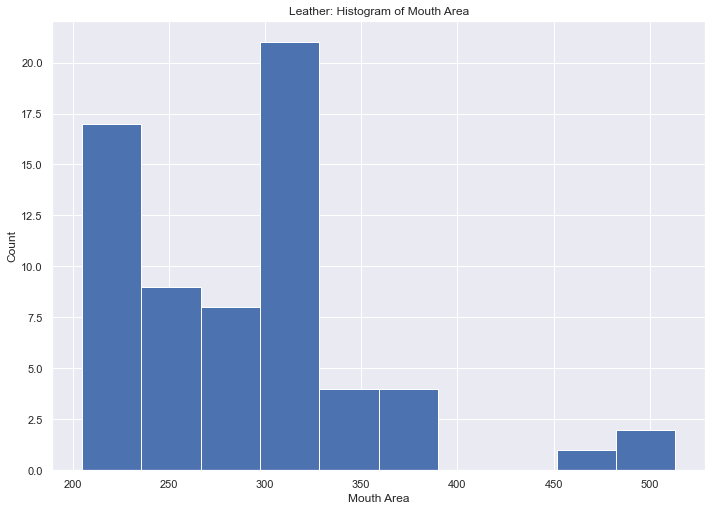

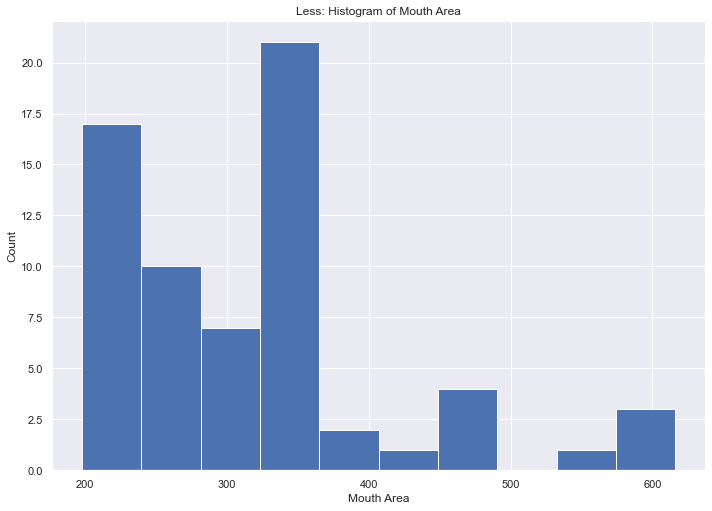

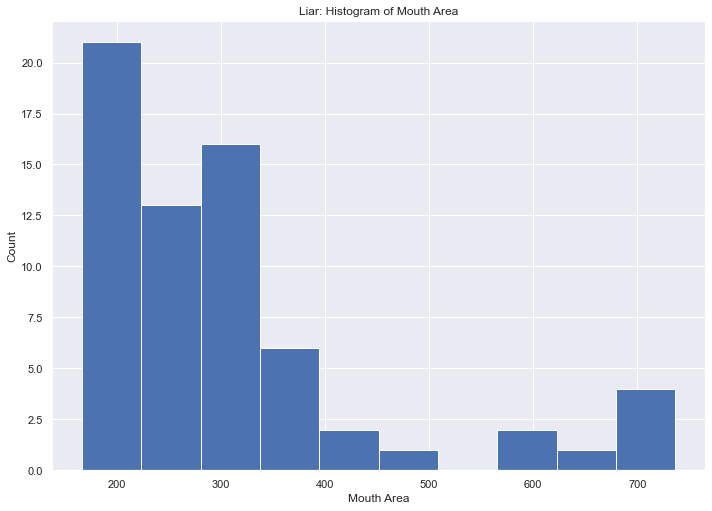

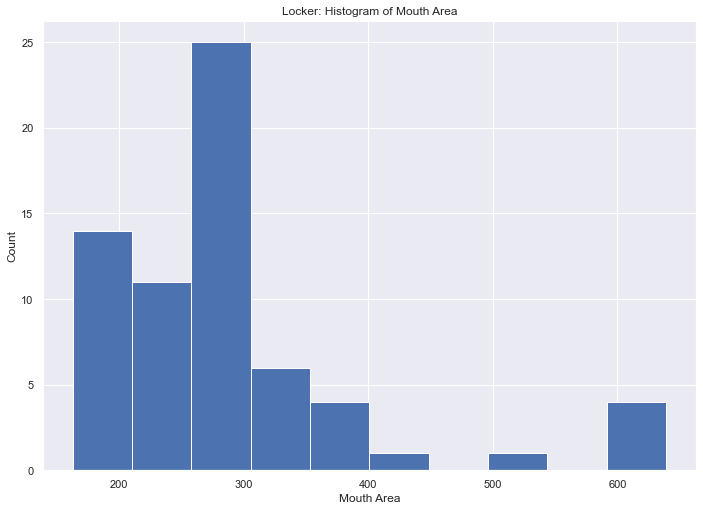

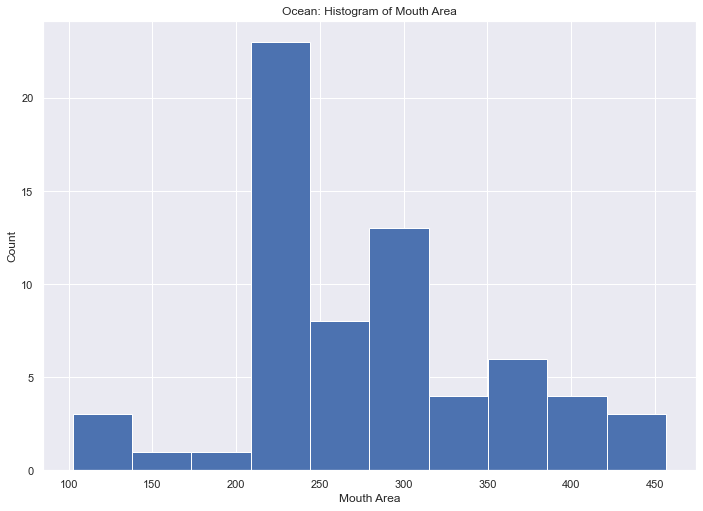

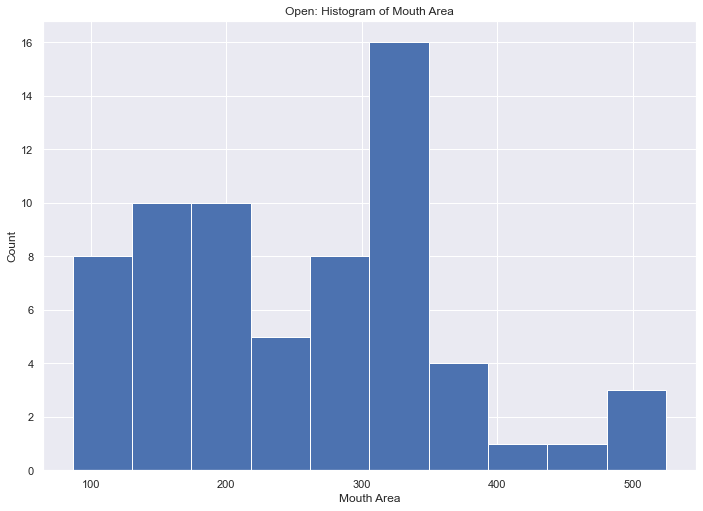

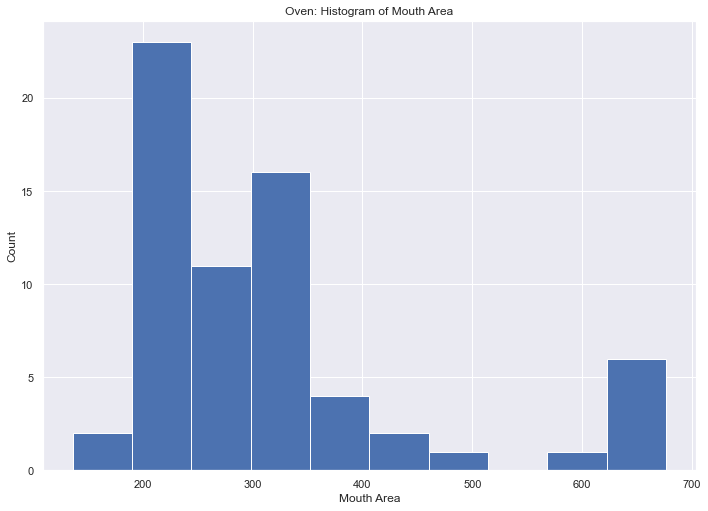

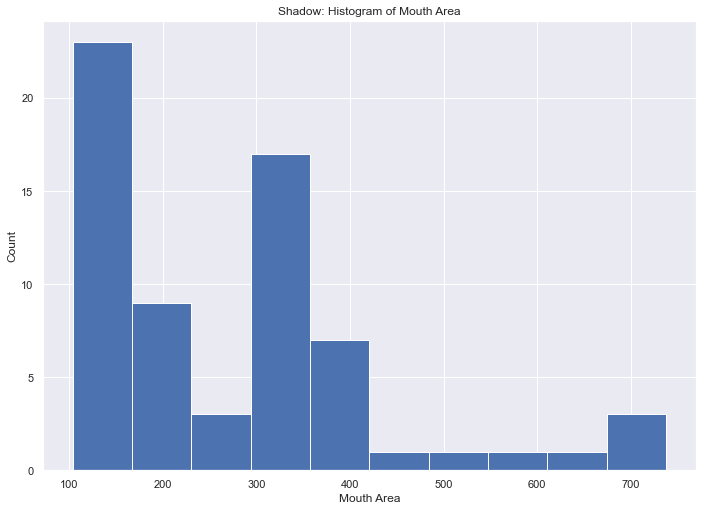

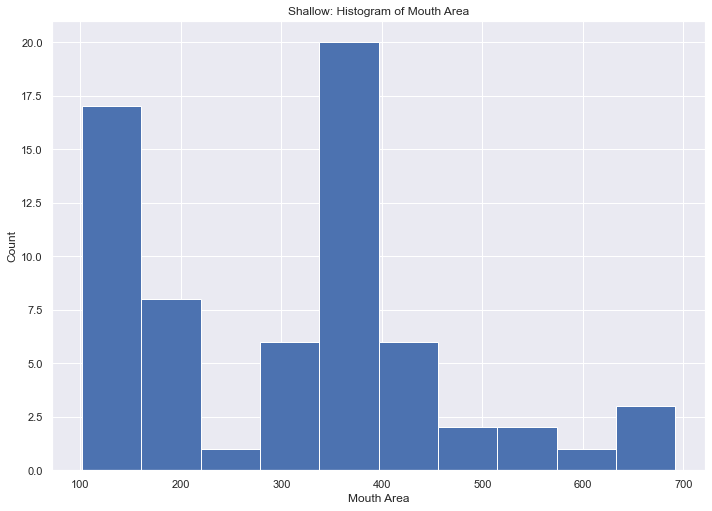

In [82]:
for i,df in enumerate(df_new_features):
    plt.figure()
    plt.hist(df["MouthArea"])
    plt.title(f"{words[i].capitalize()}: Histogram of Mouth Area")
    plt.xlabel("Mouth Area")
    plt.ylabel("Count")

# TOplt.show()

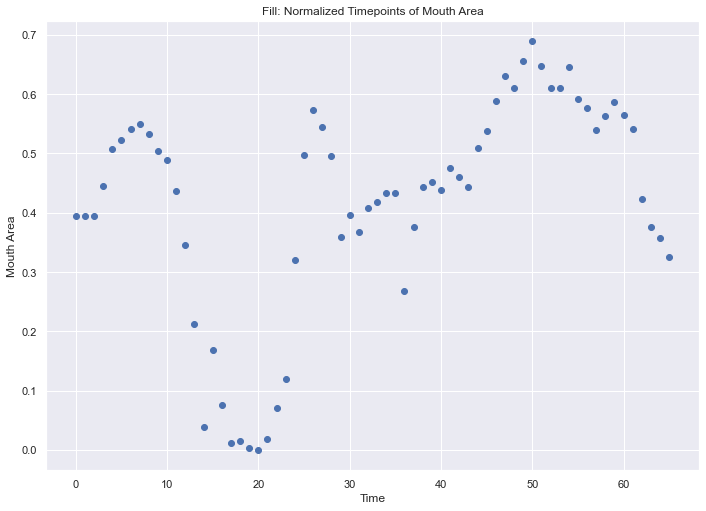

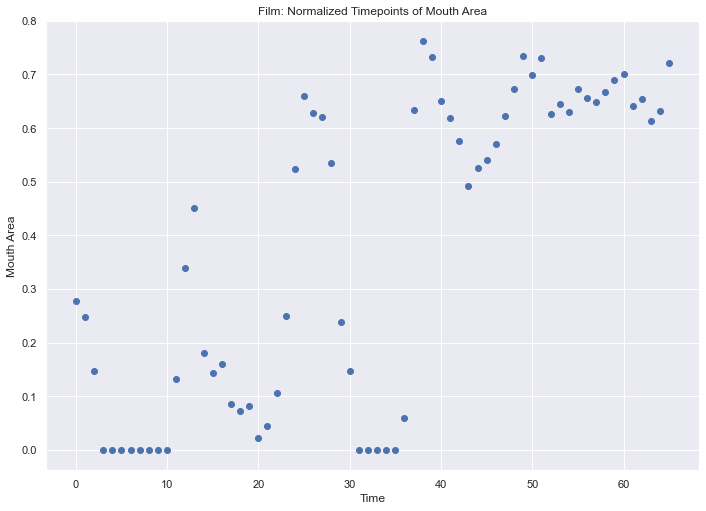

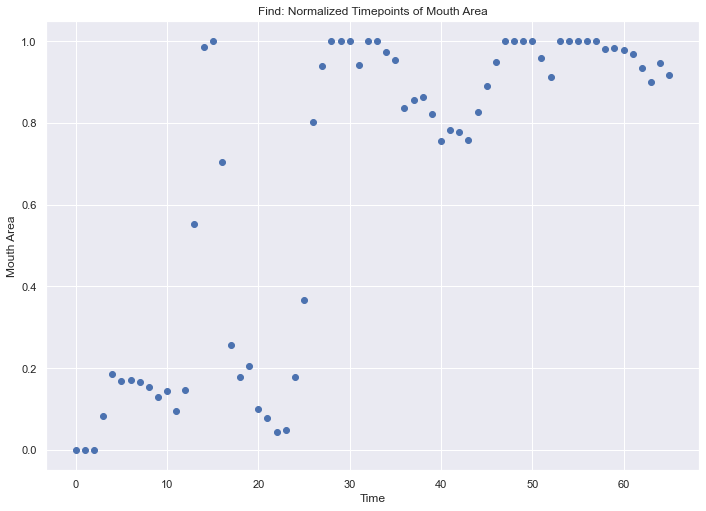

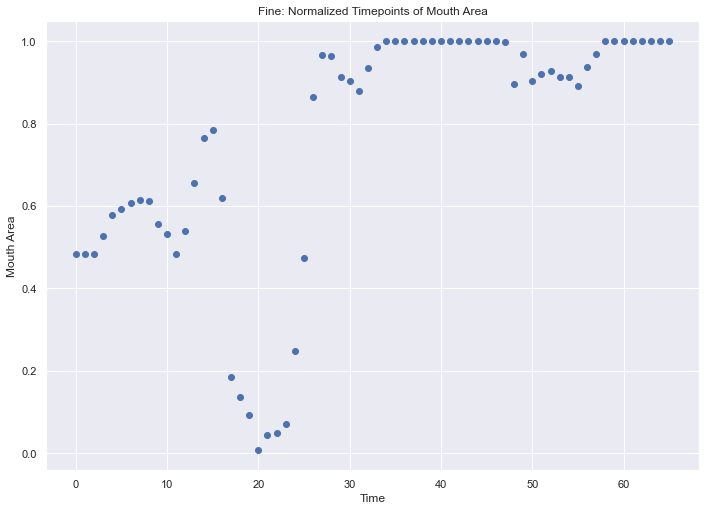

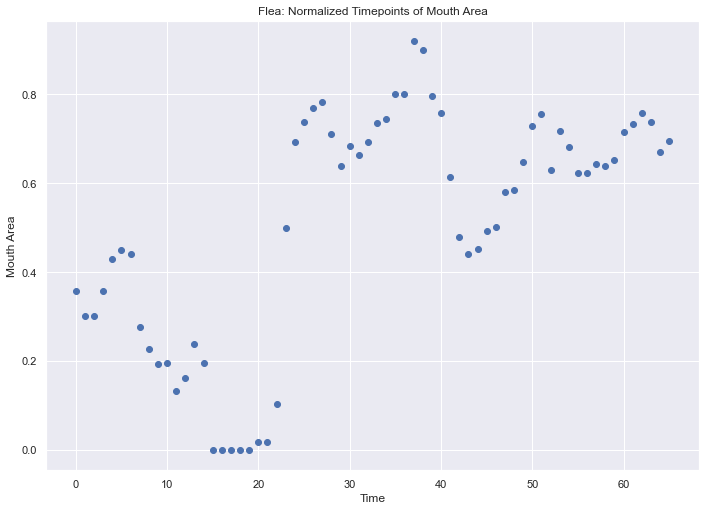

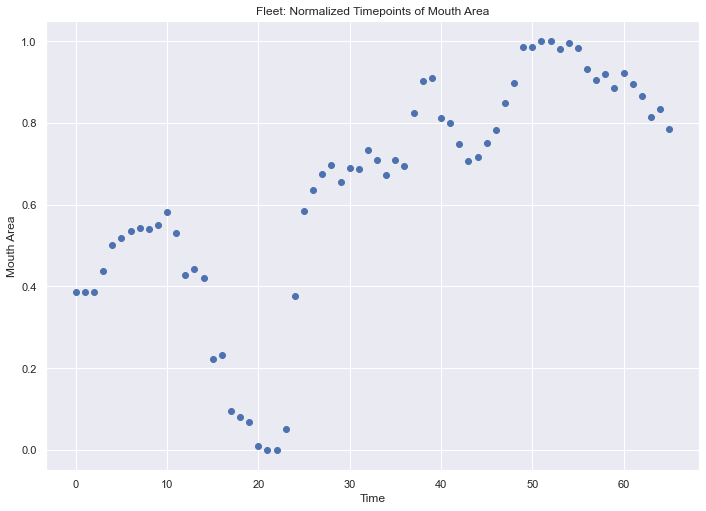

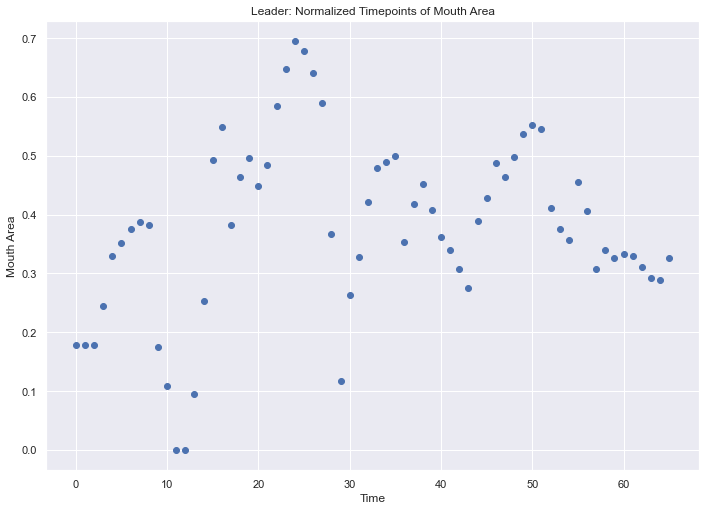

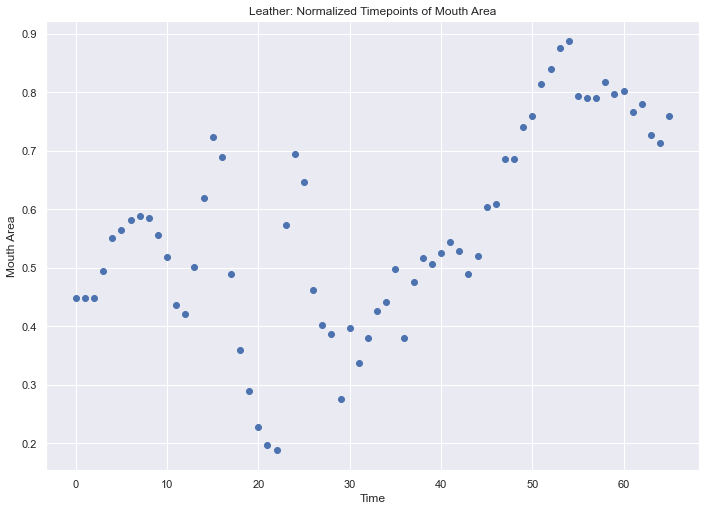

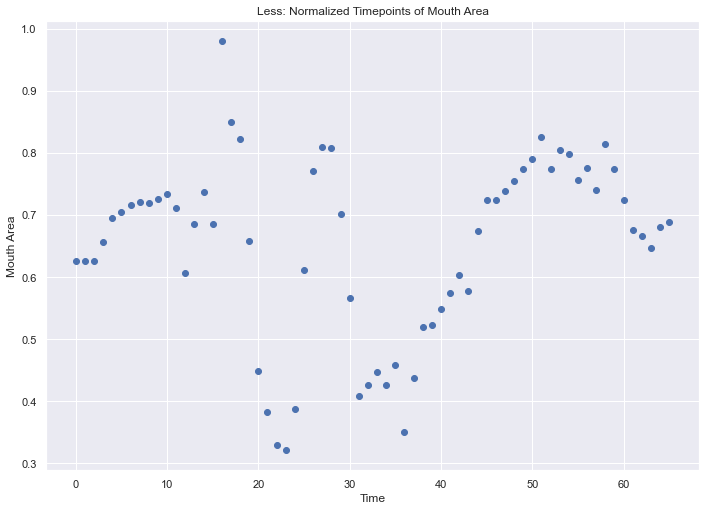

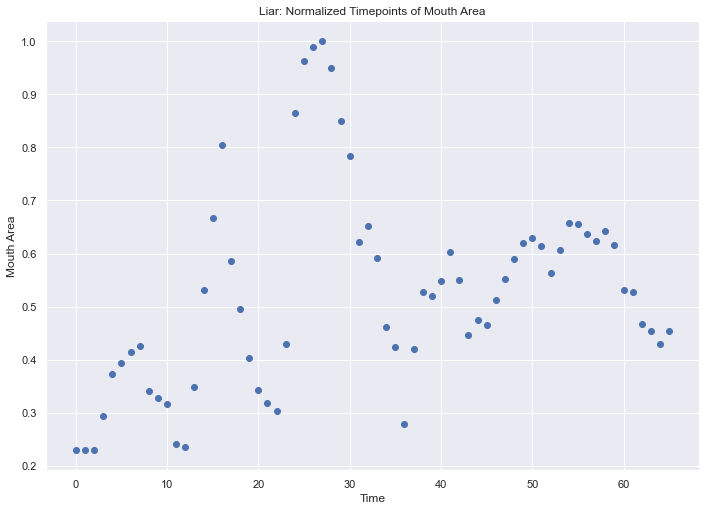

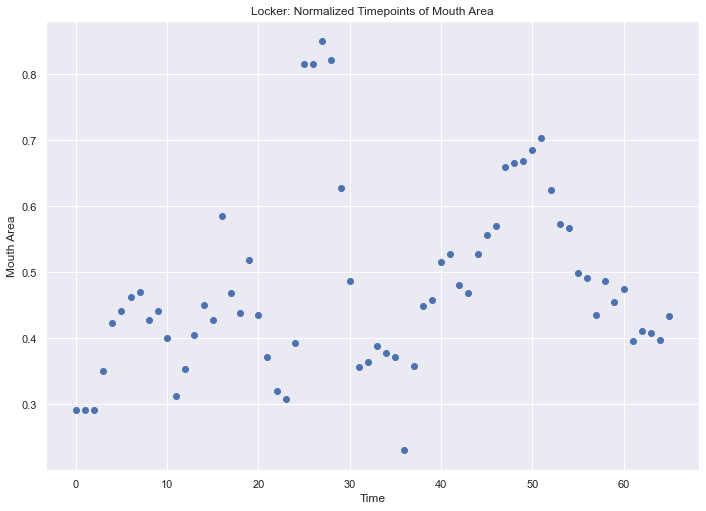

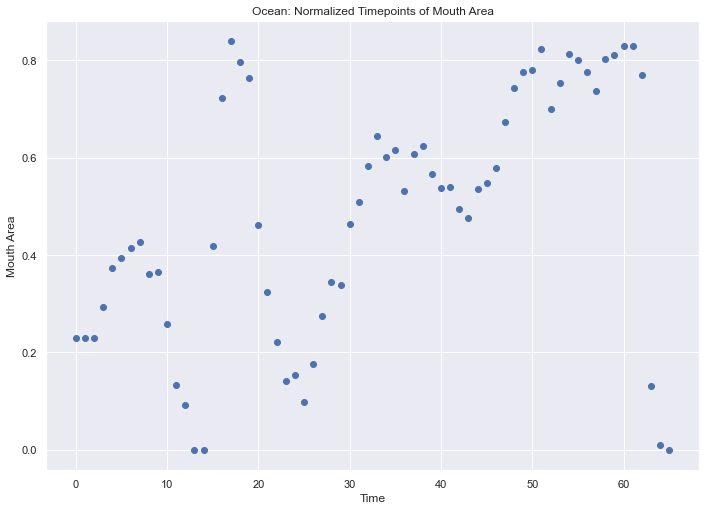

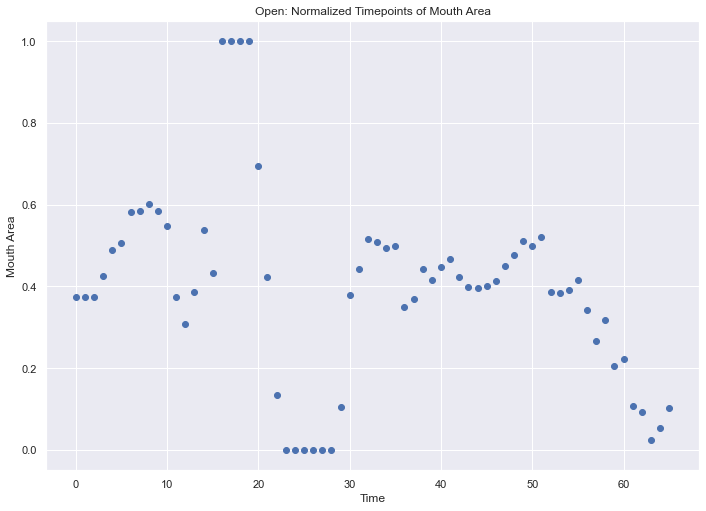

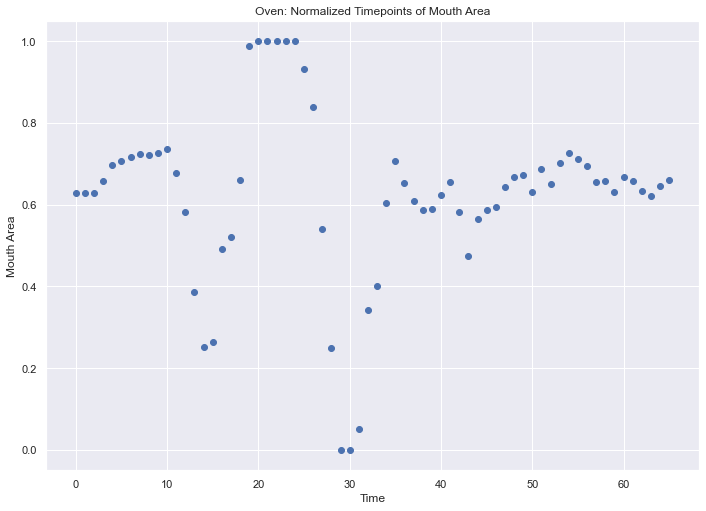

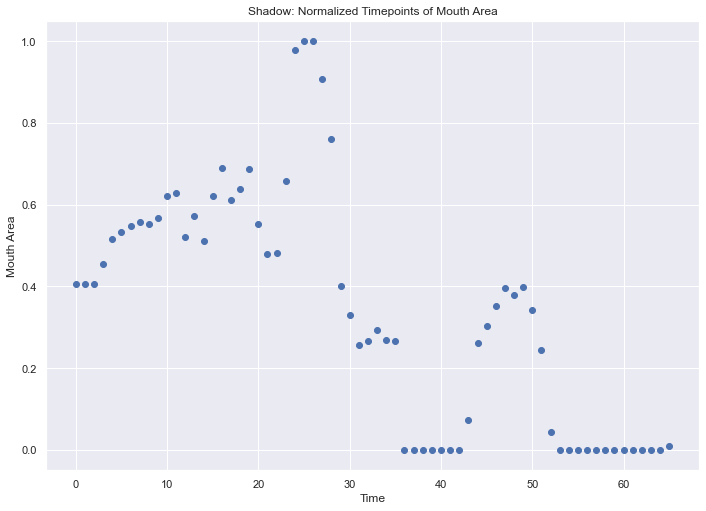

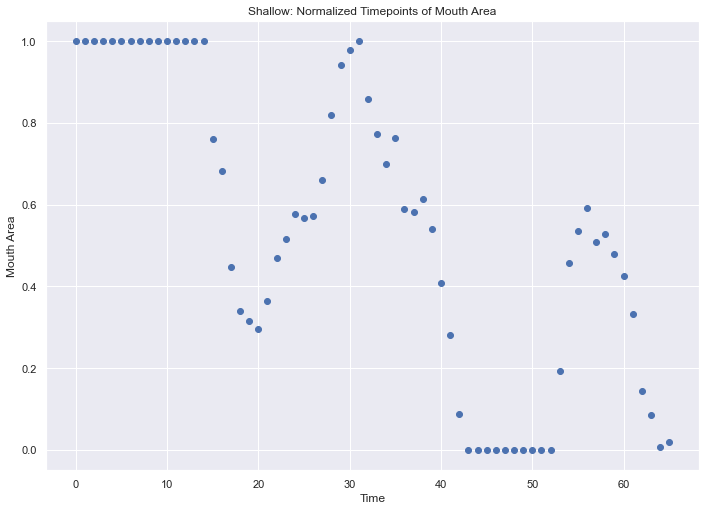

In [83]:
for i in range(len(df_new_features)):
    plt.figure()
    plt.scatter(range(len(df_new_features[0])), mouth_areas_scaled[i,:])
    plt.title(f"{words[i].capitalize()}: Normalized Timepoints of Mouth Area")
    plt.xlabel("Time")
    plt.ylabel("Mouth Area")

plt.show()

In [84]:
scaler = MinMaxScaler()
mouth_shapes_scaled = np.zeros((len(df_new_features), len(df_new_features[0])))
for i, df in enumerate(df_new_features):
    mouth_shapes_scaled[i,:] = df["MouthArea"]
    
mouth_shapes_scaled = scaler.fit_transform(mouth_shapes_scaled)
mouth_shapes_scaled_flat = mouth_shapes_scaled.reshape(-1)

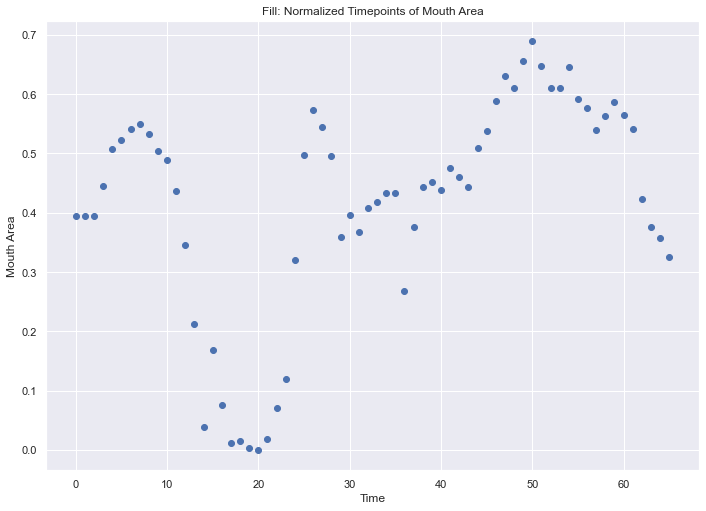

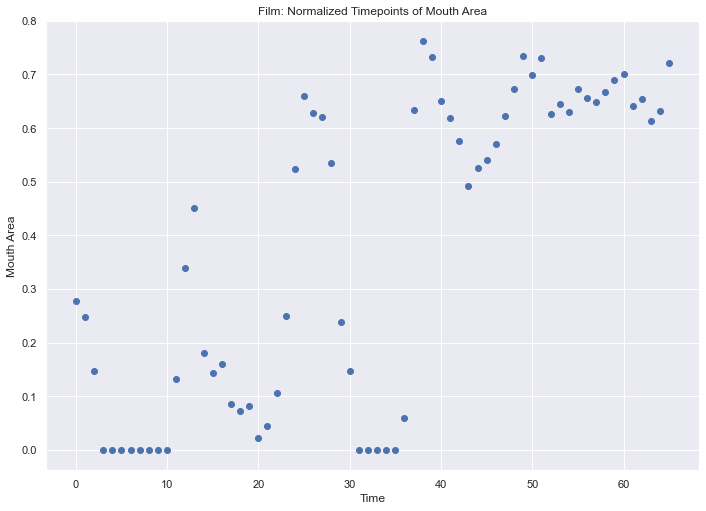

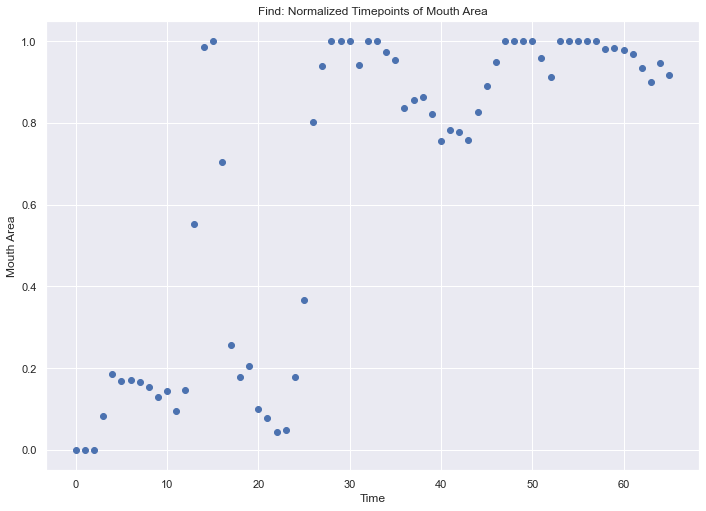

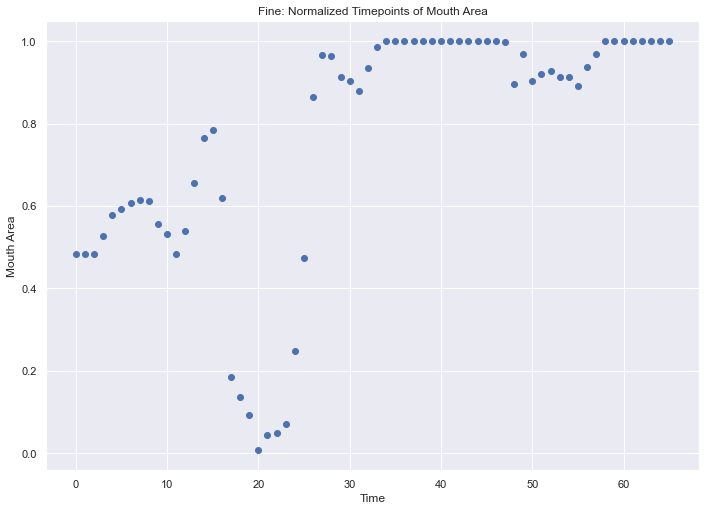

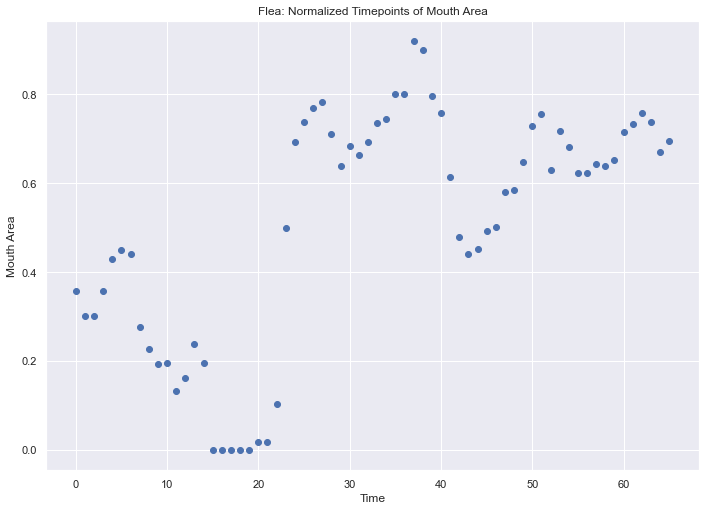

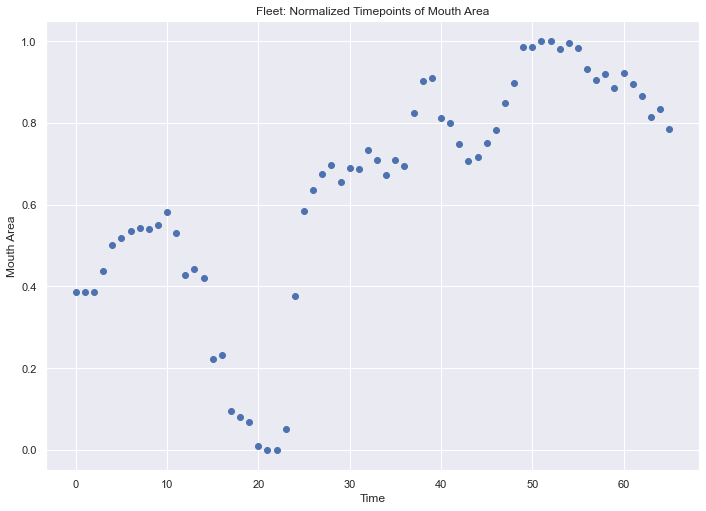

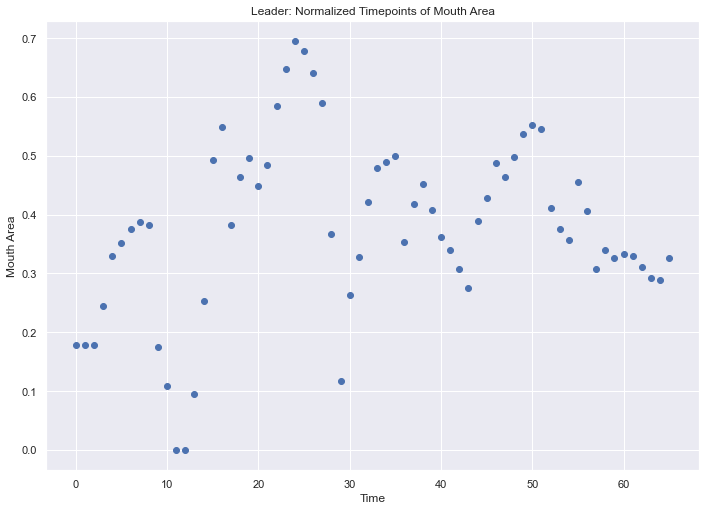

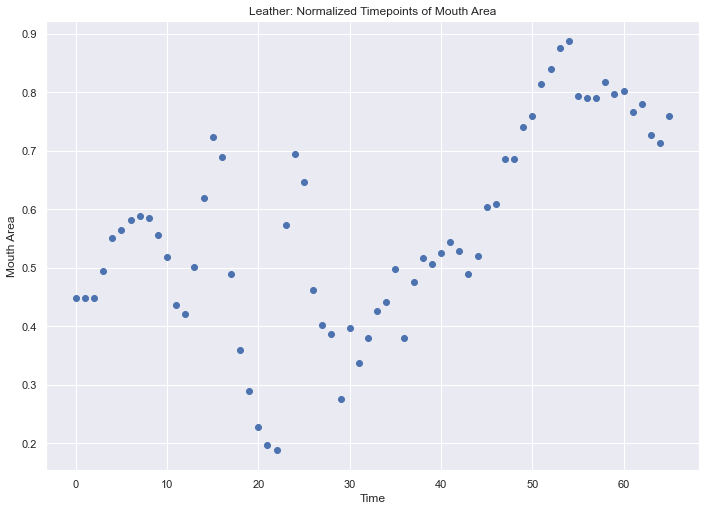

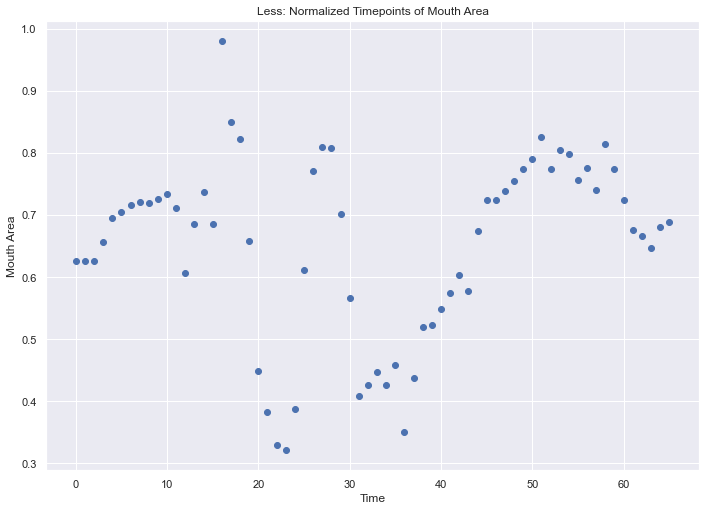

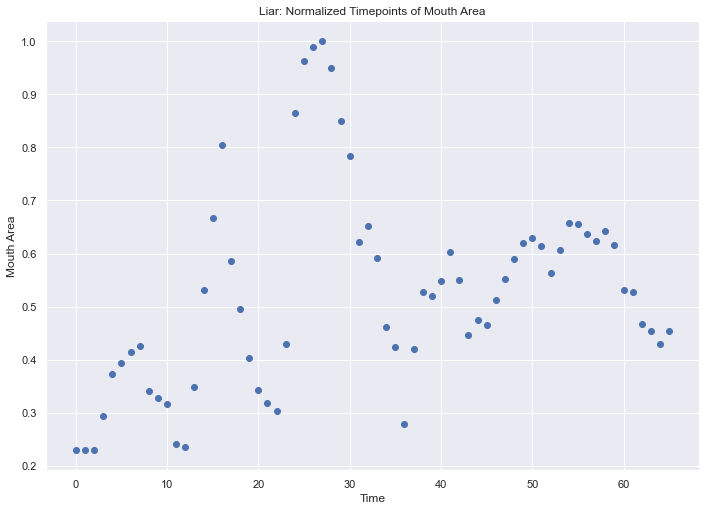

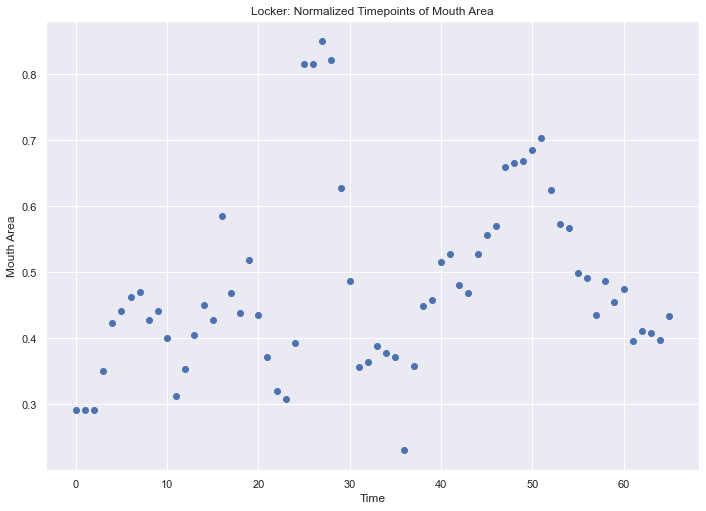

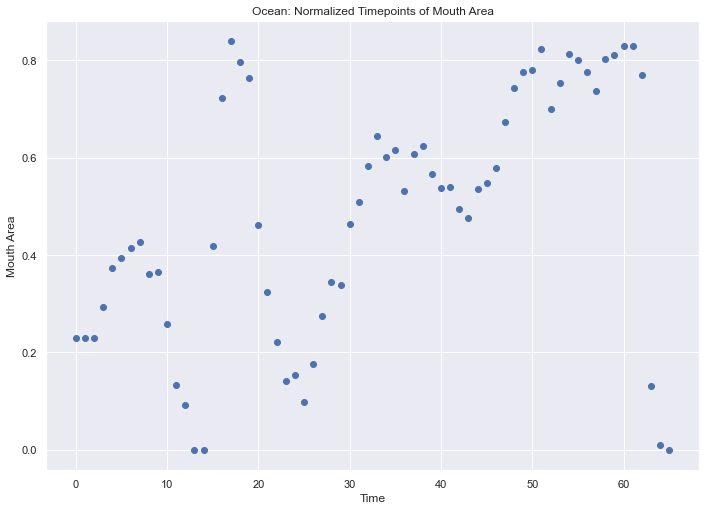

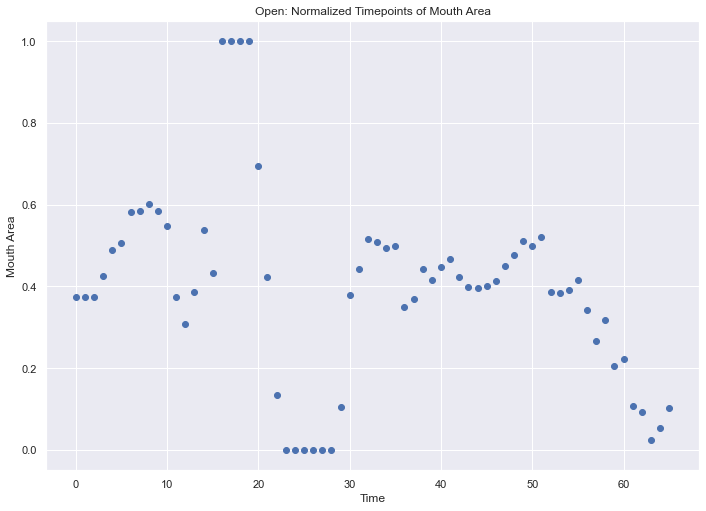

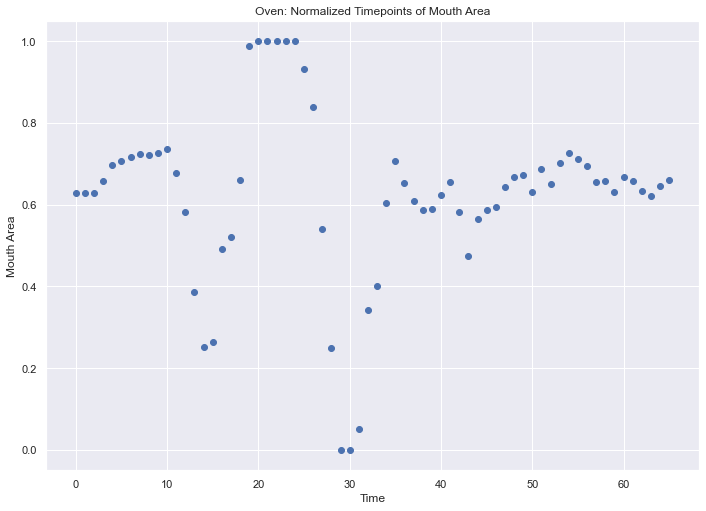

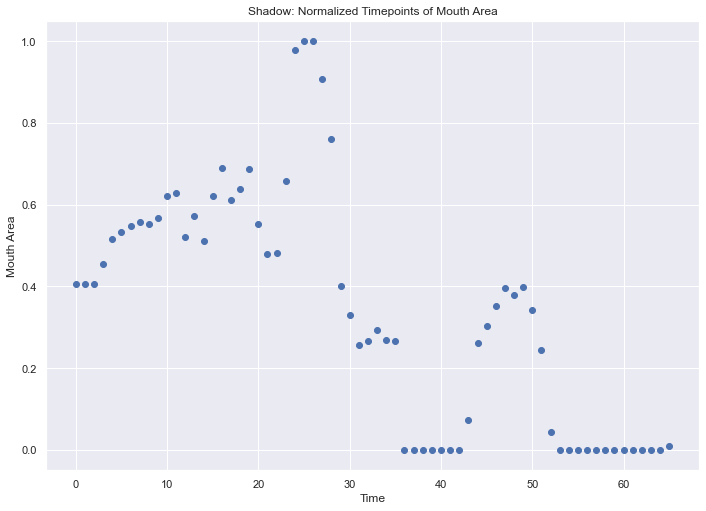

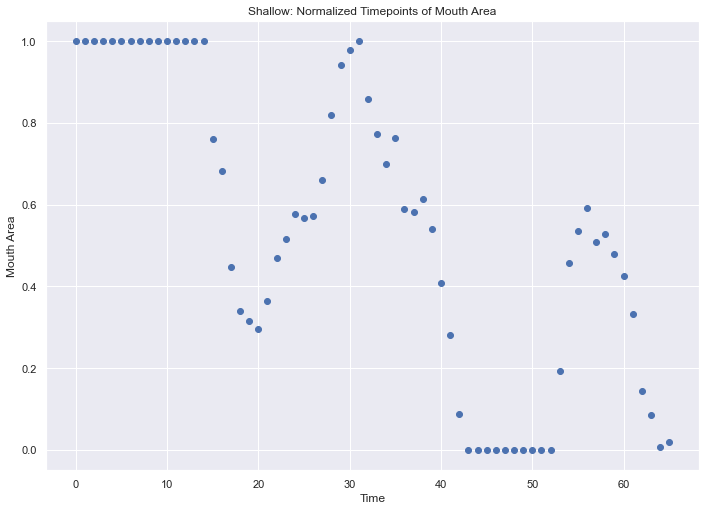

In [85]:
for i in range(len(df_new_features)):
    plt.figure()
    plt.scatter(range(len(df_new_features[0])), mouth_areas_scaled[i,:])
    plt.title(f"{words[i].capitalize()}: Normalized Timepoints of Mouth Area")
    plt.xlabel("Time")
    plt.ylabel("Mouth Area")

plt.show()

In [86]:
# run cross-correlations on each 
# TODO: need to have x_y and z as a separate thing... maybe put likelihoods by bodypart and then x y can be fine as is?

for i in range(len(df_videos)-1):
    assert df_videos[i].shape[0] == df_videos[i+1].shape[0], f'Checking {i} and {i+1}: {df_videos[i].shape} vs {df_videos[i+1].shape}'
    

# Features over time:
    # TODO: calculate mouth opening (area) [then it's independent of actual location in video space]
    # tongue present/absent (proba threshold)
    # top teeth present/absent
    # bottom teeth present/absent
    
    
# later on, prolly do distance between matrices ("average over time window" bc need to take acct time)
    